In [143]:
# import libraries
import pandas as pd
import numpy as np
import emoji
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.cluster import KMeans
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# For BERTopic
import os
import random
import numpy as np
import torch

os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["HDBSCAN_RANDOM_STATE"] = "42"

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

from hdbscan import HDBSCAN
from umap import UMAP

umap_model = UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    random_state=SEED
)

hdbscan_model = HDBSCAN(
    min_cluster_size=20,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)



In [144]:
# Load the datasets
threads_df = pd.read_csv("Data/threads_reviews_labelled.csv")     
twitter_df = pd.read_csv("Data/twitter_reviews_labelled.csv") 

### Looking at Threads dataset

In [145]:
# First 5 Threads
print(threads_df.head())

        source                                 review_description  rating  \
0  Google Play  Meh. Not the greatest experience on a Chromebo...       2   
1  Google Play  Pretty good for a first launch!! Its easy to u...       3   
2  Google Play  For a brand new app, it's very well optimized....       3   
3  Google Play  Great app with a lot of potential! However, th...       3   
4  Google Play  The app is good, but it needs a lot of functio...       3   

     review_date sentiment_true  
0   7/8/23 14:18       negative  
1  7/19/23 20:52        neutral  
2   7/6/23 23:03        neutral  
3   7/10/23 0:53        neutral  
4   7/6/23 16:57        neutral  


In [146]:
# Last 5 threads
print(threads_df.tail())

          source                                 review_description  rating  \
32905  App Store  This killed my dog. Mark zuckerburg strangled ...       1   
32906  App Store              Add Search and hashtag like Twitter !       1   
32907  App Store                                        bad twister       1   
32908  App Store                       Yet another trash from Meta.       1   
32909  App Store  Nothing special this app is just a copy of twi...       1   

        review_date sentiment_true  
32905   7/6/23 1:23            NaN  
32906  7/19/23 8:01            NaN  
32907  7/17/23 6:39            NaN  
32908  7/7/23 17:47            NaN  
32909   7/7/23 7:01            NaN  


- threads dataset has few 'app_store' data points.
- to check how many 'app_store' and handle

In [147]:
threads_df["source"].value_counts()

source
Google Play    30270
App Store       2640
Name: count, dtype: int64

- There are 2640 rows for data from app_store.

### Looking at Twitter dataset

In [148]:
# First 5 Twitter
print(twitter_df.head())

   Unnamed: 0                             review_id  pseudo_author_id  \
0     1988084  f1584af1-3c91-4b7b-ade9-bd88c8d7a057      2.184470e+20   
1     1988085  3244b60a-8656-4fad-aaa6-7f199b6bf5bd      2.702280e+20   
2     1988086  f6aa48d3-e35a-454f-8eb2-b2605fbd5632      2.379510e+20   
3     1988087  00d82206-a895-432f-9761-baa3eb181749      1.530330e+20   
4     1988088  34a514ff-8f35-4e57-a667-18adfe416f25      1.743680e+20   

           author_name                                        review_text  \
0         Ay********an                                                 Ok   
1          Pr*******ai  App and website quality has consistently been ...   
2  St***************ch                          Great app; no complaints.   
3          A.*******ey                App crashes whenever I try to post.   
4        TA*********AT  Forced to download app cos I cant see tweets w...   

   review_rating  review_likes author_app_version review_timestamp  \
0              5            

In [149]:
# Last 5 twitter
print(twitter_df.tail())

       Unnamed: 0                             review_id  pseudo_author_id  \
34783     2022867  8eb3e09e-0269-4000-bf1d-bca068aab0d4      1.831740e+20   
34784     2022868  07147f9e-12e2-41e5-9909-9fd58833b9b1      4.070130e+20   
34785     2022869  2993c3c6-ae99-4b7a-922b-2f9ad4cc8fd1      6.310000e+20   
34786     2022870  4e199ee2-5d5a-4250-8d33-c616c9a425d3      2.912830e+20   
34787     2022871  3ef51c55-d534-45cb-847c-94a7f1fcc8a2      1.487260e+20   

         author_name                                        review_text  \
34783  Av*********an                                 This app is a cyst   
34784             **  見つける機能廃止の代わりのハイライトの通信がやたら時間かかる。タイムラインも読み込みに時間か...   
34785       In****r8                                        It's so bad   
34786   Ro********er  Horrible because Elon doesn't know how to do a...   
34787  Al*********ić                                Bro wachu mean "X"💀   

       review_rating  review_likes author_app_version review_timestamp  \
34783       

- the twitter dataset has many unwanted columns, should handle this
- it also has different language other tha english, should handle this

### Threads Info

In [150]:
# Info print for threads
print(threads_df.info(), "\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32910 entries, 0 to 32909
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   source              32910 non-null  object
 1   review_description  32910 non-null  object
 2   rating              32910 non-null  int64 
 3   review_date         32910 non-null  object
 4   sentiment_true      3165 non-null   object
dtypes: int64(1), object(4)
memory usage: 1.3+ MB
None 



### Twitter Info

In [151]:
# Info print for twitter
print(twitter_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34788 entries, 0 to 34787
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          34788 non-null  int64  
 1   review_id           34788 non-null  object 
 2   pseudo_author_id    34788 non-null  float64
 3   author_name         34788 non-null  object 
 4   review_text         34785 non-null  object 
 5   review_rating       34788 non-null  int64  
 6   review_likes        34788 non-null  int64  
 7   author_app_version  27874 non-null  object 
 8   review_timestamp    34788 non-null  object 
 9   sentiment_true      3027 non-null   object 
dtypes: float64(1), int64(3), object(6)
memory usage: 2.7+ MB
None


In [152]:
# Columns for confirmation
print("Threads columns:", threads_df.columns.tolist())
print("Twitter columns:", twitter_df.columns.tolist())

Threads columns: ['source', 'review_description', 'rating', 'review_date', 'sentiment_true']
Twitter columns: ['Unnamed: 0', 'review_id', 'pseudo_author_id', 'author_name', 'review_text', 'review_rating', 'review_likes', 'author_app_version', 'review_timestamp', 'sentiment_true']


- We see Twitter has unwanted columns not required for our project

#### Missing values - Threads

In [153]:
# Missing Values of Threads
print("\nMissing values (Threads):\n", threads_df.isnull().sum())



Missing values (Threads):
 source                    0
review_description        0
rating                    0
review_date               0
sentiment_true        29745
dtype: int64


#### Missing Values - Twitter

In [154]:
# Missing Values of Twitter
print("\nMissing values (Twitter):\n", twitter_df.isnull().sum())


Missing values (Twitter):
 Unnamed: 0                0
review_id                 0
pseudo_author_id          0
author_name               0
review_text               3
review_rating             0
review_likes              0
author_app_version     6914
review_timestamp          0
sentiment_true        31761
dtype: int64


- Twitter has missing values in 2 columns - should handle this

## Data Cleaning Pipeline 1 (base)

### Data cleaning for threads

- Removed duplicated content (raw + long-review duplicates)
- Standardized brand names
- Removed noise, emojis, special chars, stopwords
- Handled negations properly
- Removed empty texts after cleaning
- Detected language and removed unwanted languages

In [155]:
import re
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd

# ===========================================================
# 1. DUPLICATE DETECTION (RAW TEXT)
# ===========================================================

print("\n===== RAW DUPLICATE CHECK =====")
df = threads_df.copy()
dups_raw = df[df.duplicated(subset=["review_description"], keep=False)]
dups_raw_idx = dups_raw.reset_index()[["index", "review_description"]]

print("Total RAW duplicate rows:", len(dups_raw_idx))
print("\n--- SAMPLE RAW DUPLICATES ---")
print(dups_raw_idx.head(10))


# ===========================================================
# 2. LONG-REVIEW DUPLICATE REMOVAL
# ===========================================================

def is_long_review(text, min_words=15):
    return len(str(text).split()) >= min_words

df["is_long"] = df["review_description"].apply(is_long_review)

df_long = df[df["is_long"] == True].copy()
df_short = df[df["is_long"] == False].copy()

print("\n===== LONG REVIEW STATS =====")
print("Long reviews:", df_long.shape[0])
print("Short reviews:", df_short.shape[0])

dup_long_mask = df_long.duplicated(subset=["review_description"], keep=False)
df_long_dups = df_long[dup_long_mask]

print("\n===== LONG DUPLICATES FOUND =====")
print("Total long duplicate rows:", df_long_dups.shape[0])

dup_groups_long = (
    df_long_dups.reset_index()
                .groupby("review_description")["index"]
                .apply(list)
                .reset_index(name="row_numbers")
)

print("Distinct long duplicated texts:", len(dup_groups_long))
print("\n--- SAMPLE LONG DUPLICATE GROUPS ---")
print(dup_groups_long.head(10))

before_long = df_long.shape[0]
df_long_clean = df_long.drop_duplicates(subset=["review_description"], keep="first")
after_long = df_long_clean.shape[0]

print("\n===== LONG DUPLICATE REMOVAL =====")
print("Before:", before_long)
print("After :", after_long)
print("Removed:", before_long - after_long)

df = pd.concat([df_long_clean, df_short], ignore_index=True)
df.drop(columns=["is_long"], inplace=True)

print("\n===== AFTER LONG-DEDUPE: df.shape =====")
print(df.shape)

# ===========================================================
# 3. BRAND NORMALIZATION MAP
# ===========================================================

brand_map = {
    # Twitter / X
    r"\btwitter\b": "twitter",
    r"\btwt\b": "twitter",
    r"\btwit\b": "twitter",
    r"\btwwitter\b": "twitter",
    r"\btwiter\b": "twitter",
    r"\bx\b": "twitter",

    # Threads
    r"\bthreads\b": "threads",
    r"\bthread\b": "threads",
    r"\btread\b": "threads",
    r"\btreads\b": "threads",
    r"\bthreds\b": "threads",

    # Instagram
    r"\binstagram\b": "instagram",
    r"\binsta\b": "instagram",
    r"\binstgram\b": "instagram",
    r"\binstragram\b": "instagram",

    # Facebook + Meta
    r"\bfacebook\b": "facebook",
    r"\bfacebok\b": "facebook",
    r"\bfb\b": "facebook",
    r"\bmeta\b": "facebook",
}

def normalize_brands(text):
    text = str(text).lower()
    for pattern, repl in brand_map.items():
        text = re.sub(pattern, repl, text)
    return text


# ===========================================================
# 4. CLEANING PIPELINE (COMBINED)
# ===========================================================

stop_words = set(stopwords.words("english"))
negations = {"no", "not", "nor", "dont", "can't", "cannot", "never"}
stop_words = stop_words - negations

lemmatizer = WordNetLemmatizer()

# Custom stopwords - INCLUDING normalized brand names
custom_stopwords = set([
    "app", "apps", "application", "applications",
    "threads", "experience", "im", "account"
])

def clean_text(text):
    # Step 1: Normalize brands FIRST (before any other processing)
    text = normalize_brands(text)
    
    # Step 2: Basic cleaning
    text = str(text)
    text = text.lower()
    text = emoji.replace_emoji(text, replace="")
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z0-9 ]", " ", text)  # Remove special chars (added space)
    text = re.sub(r"\s+", " ", text).strip()    # Normalize whitespace
    
    # Step 3: Tokenization and stopword removal
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if word not in custom_stopwords]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return " ".join(tokens)


# Apply cleaning
df["review_cleaned"] = df["review_description"].apply(clean_text)


print("\n===== CLEANING CHECK =====")
for i in range(5):
    print("\nOriginal:", df.loc[i, "review_description"])
    print("Cleaned :", df.loc[i, "review_cleaned"])


# ===========================================================
# 5. REMOVE EMPTY CLEANED ROWS
# ===========================================================

before = df.shape[0]
df = df[df["review_cleaned"].str.strip() != ""]
after = df.shape[0]

print("\n===== EMPTY CLEANED TEXT REMOVAL =====")
print("Before:", before)
print("After:", after)
print("Removed:", before - after)


#==============================================
# 5.5 LANGUAGE DETECTION & FILTERING 
#=============================================

from langdetect import detect, LangDetectException, DetectorFactory
DetectorFactory.seed = 42
# ==============================================
# MINIMAL LANGUAGE DETECTION & FILTERING
# ==============================================

from langdetect import detect, LangDetectException

REMOVE_LANGS = {"vi","tr","sw","sq","so","pt","lv","lt","id","hr","et","es"}

def detect_language(text):
    try:
        text_str = str(text).strip()
        if len(text_str) < 10:
            return 'unknown'
        return detect(text_str)
    except LangDetectException:
        return 'unknown'
    except:
        return 'unknown'

# Detect languages
df["detected_lang"] = df["review_cleaned"].apply(detect_language)

print("\n===== LANGUAGE DISTRIBUTION =====")
print(df["detected_lang"].value_counts())


# -----------------------------------------------------
# REMOVE ONLY SPECIFIED LANGUAGES
# keep English + unknown + any other safe languages
# -----------------------------------------------------
before = df.shape[0]

df = df[~df["detected_lang"].isin(REMOVE_LANGS)].copy()
df = df.reset_index(drop=True)

print(f"\nRemoved {before - df.shape[0]} rows from unwanted languages.")
print("\n===== FINAL DATASET SHAPE =====")
print(df.shape)




===== RAW DUPLICATE CHECK =====
Total RAW duplicate rows: 7124

--- SAMPLE RAW DUPLICATES ---
   index                                 review_description
0     23  It's a good start but they have to add some th...
1    105  It's a great start! I do feel like when adding...
2    222  The user experience so far so good, clean and ...
3   3773  It's a good start but they have to add some th...
4   4516  It's a great start! I do feel like when adding...
5   4604  The user experience so far so good, clean and ...
6   5915                               Not working properly
7   5938                               Not working properly
8   5939                               Not working properly
9   6050                               Not working properly

===== LONG REVIEW STATS =====
Long reviews: 8300
Short reviews: 24610

===== LONG DUPLICATES FOUND =====
Total long duplicate rows: 6
Distinct long duplicated texts: 3

--- SAMPLE LONG DUPLICATE GROUPS ---
                                  revi

- Original rows ≈ 33,000
- Final rows = 29,646
- Total removed ≈ 3,300 rows (≈10%)

In [156]:
# Apply cleaning
threads_clean  =  df.copy()
threads_clean["review_cleaned"] = threads_clean["review_description"].apply(clean_text)


print("\n--- CLEANING CHECK: original vs cleaned ---")
for i in range(3):
    print("\nOriginal:", threads_clean.loc[i, "review_description"])
    print("Cleaned :", threads_clean.loc[i, "review_cleaned"])



--- CLEANING CHECK: original vs cleaned ---

Original: Meh. Not the greatest experience on a Chromebook. Seems to be customized for phones only. Opens in a little screen that you can't expand or resize - for reasons that are a complete mystery to me. Judging from the fact that every other app I know of is resizeable, this seems like it was a conscious choice by the developers . Why you'd do something like this is beyond understanding and suggests a control freak approach. Not a great way to make a first impression.
Cleaned : meh not greatest chromebook seems customized phone open little screen expand resize reason complete mystery judging fact every know resizeable seems like conscious choice developer something like beyond understanding suggests control freak approach not great way make first impression

Original: Pretty good for a first launch!! Its easy to use and self-explanatory and I'd say the algorithm is good as well. It has great *potential* but a few things need improvement:

### Data Cleaning for twitter

- Applied different custom stopwords, language filtering rules (Twitter tends to have much more global usage → more foreign languages)
- Everything else (duplicate logic, text cleaning, brand normalization workflow) is the same.

In [157]:

# ===========================================================
# 1. DUPLICATE DETECTION (RAW TEXT)
# ===========================================================

print("\n===== RAW DUPLICATE CHECK =====")
df = twitter_df.copy()
dups_raw = df[df.duplicated(subset=["review_text"], keep=False)]
dups_raw_idx = dups_raw.reset_index()[["index", "review_text"]]

print("Total RAW duplicate rows:", len(dups_raw_idx))
print("\n--- SAMPLE RAW DUPLICATES ---")
print(dups_raw_idx.head(10))


# ===========================================================
# 2. LONG-REVIEW DUPLICATE REMOVAL
# ===========================================================

def is_long_review(text, min_words=15):
    return len(str(text).split()) >= min_words

df["is_long"] = df["review_text"].apply(is_long_review)

df_long = df[df["is_long"] == True].copy()
df_short = df[df["is_long"] == False].copy()

print("\n===== LONG REVIEW STATS =====")
print("Long reviews:", df_long.shape[0])
print("Short reviews:", df_short.shape[0])

dup_long_mask = df_long.duplicated(subset=["review_text"], keep=False)
df_long_dups = df_long[dup_long_mask]

print("\n===== LONG DUPLICATES FOUND =====")
print("Total long duplicate rows:", df_long_dups.shape[0])

dup_groups_long = (
    df_long_dups.reset_index()
                .groupby("review_text")["index"]
                .apply(list)
                .reset_index(name="row_numbers")
)

print("Distinct long duplicated texts:", len(dup_groups_long))
print("\n--- SAMPLE LONG DUPLICATE GROUPS ---")
print(dup_groups_long.head(10))

before_long = df_long.shape[0]
df_long_clean = df_long.drop_duplicates(subset=["review_text"], keep="first")
after_long = df_long_clean.shape[0]

print("\n===== LONG DUPLICATE REMOVAL =====")
print("Before:", before_long)
print("After :", after_long)
print("Removed:", before_long - after_long)

df = pd.concat([df_long_clean, df_short], ignore_index=True)
df.drop(columns=["is_long"], inplace=True)

print("\n===== AFTER LONG-DEDUPE: df.shape =====")
print(df.shape)


# ===========================================================
# 3. BRAND NORMALIZATION MAP
# ===========================================================

brand_map = {
    # Twitter / X
    r"\btwitter\b": "twitter",
    r"\btwt\b": "twitter",
    r"\btwit\b": "twitter",
    r"\btwwitter\b": "twitter",
    r"\btwiter\b": "twitter",
    r"\bx\b": "twitter",

    # Threads
    r"\bthreads\b": "threads",
    r"\bthread\b": "threads",
    r"\btread\b": "threads",
    r"\btreads\b": "threads",
    r"\bthreds\b": "threads",

    # Instagram
    r"\binstagram\b": "instagram",
    r"\binsta\b": "instagram",
    r"\binstgram\b": "instagram",
    r"\binstragram\b": "instagram",

    # Facebook + Meta
    r"\bfacebook\b": "facebook",
    r"\bfacebok\b": "facebook",
    r"\bfb\b": "facebook",
    r"\bmeta\b": "facebook",
}

def normalize_brands(text):
    text = str(text).lower()
    for pattern, repl in brand_map.items():
        text = re.sub(pattern, repl, text)
    return text


# ===========================================================
# 4. CLEANING PIPELINE (COMBINED)
# ===========================================================

stop_words = set(stopwords.words("english"))
negations = {"no", "not", "nor", "dont", "can't", "cannot", "never"}
stop_words = stop_words - negations

lemmatizer = WordNetLemmatizer()

# Custom stopwords - INCLUDING normalized brand names
custom_stopwords = set([
    "app", "apps", "application", "applications",
    "twitter", "im", "account"
])

def clean_text(text):
    # Step 1: Normalize brands FIRST (before any other processing)
    text = normalize_brands(text)
    
    # Step 2: Basic cleaning
    text = str(text)
    text = text.lower()
    text = emoji.replace_emoji(text, replace="")
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z0-9 ]", " ", text)  # Remove special chars (added space)
    text = re.sub(r"\s+", " ", text).strip()    # Normalize whitespace
    
    # Step 3: Tokenization and stopword removal
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if word not in custom_stopwords]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return " ".join(tokens)

# Apply cleaning
df["review_cleaned"] = df["review_text"].apply(clean_text)

print("\n===== CLEANING CHECK =====")
for i in range(5):
    print("\nOriginal:", df.loc[i, "review_text"])
    print("Cleaned :", df.loc[i, "review_cleaned"])


# ===========================================================
# 5. REMOVE EMPTY CLEANED ROWS
# ===========================================================

before = df.shape[0]
df = df[df["review_cleaned"].str.strip() != ""]
after = df.shape[0]

print("\n===== EMPTY CLEANED TEXT REMOVAL =====")
print("Before:", before)
print("After:", after)
print("Removed:", before - after)

# ==============================================
# MINIMAL LANGUAGE DETECTION & FILTERING
# ==============================================

from langdetect import detect, LangDetectException, DetectorFactory
DetectorFactory.seed = 42

REMOVE_LANGS = {"vi","tr","tl","sw","sq","so","sl","pl","pt","lv","lt","id","hr","es","ca","cy","de","fi","hu"}

def detect_language(text):
    try:
        text_str = str(text).strip()
        if len(text_str) < 10:
            return 'unknown'
        return detect(text_str)
    except LangDetectException:
        return 'unknown'
    except:
        return 'unknown'

# Detect languages
df["detected_lang"] = df["review_cleaned"].apply(detect_language)

print("\n===== LANGUAGE DISTRIBUTION =====")
print(df["detected_lang"].value_counts())

# -----------------------------------------------------
# REMOVE ONLY SPECIFIED LANGUAGES
# keep English + unknown + any other safe languages
# -----------------------------------------------------
before = df.shape[0]

df = df[~df["detected_lang"].isin(REMOVE_LANGS)].copy()
df = df.reset_index(drop=True)

print(f"\nRemoved {before - df.shape[0]} rows from unwanted languages.")
print("\n===== FINAL DATASET SHAPE =====")
print(df.shape)


===== RAW DUPLICATE CHECK =====
Total RAW duplicate rows: 5490

--- SAMPLE RAW DUPLICATES ---
   index      review_text
0      0               Ok
1      7             Nice
2     11         Good app
3     14             Good
4     17        Great app
5     19             Good
6     24        Nice Apps
7     25               Ok
8     26         Terrible
9     27  Good experience

===== LONG REVIEW STATS =====
Long reviews: 8616
Short reviews: 26172

===== LONG DUPLICATES FOUND =====
Total long duplicate rows: 0
Distinct long duplicated texts: 0

--- SAMPLE LONG DUPLICATE GROUPS ---
Empty DataFrame
Columns: [review_text, row_numbers]
Index: []

===== LONG DUPLICATE REMOVAL =====
Before: 8616
After : 8616
Removed: 0

===== AFTER LONG-DEDUPE: df.shape =====
(34788, 10)

===== CLEANING CHECK =====

Original: Bahut hi ghatiya app hai aapki id dubara nhi milti hai or dusra account bhi nhi banta
Cleaned : bahut hi ghatiya hai aapki id dubara nhi milti hai dusra bhi nhi banta

Original: A cessp

- Original rows ≈ 34,788
- Final rows = 29,611
- Total removed ≈ 5,177 rows (≈14.9%)

In [158]:
# Apply cleaning
twitter_clean = df.copy()

print("\n--- CLEANING CHECK: original vs cleaned ---")
for i in range(3):
    print("\nOriginal:", twitter_clean.loc[i, "review_text"])
    print("Cleaned :", twitter_clean.loc[i, "review_cleaned"])


--- CLEANING CHECK: original vs cleaned ---

Original: A cesspool of bigotry, rascism, homophobia, transphobia, misogyny and fascism, all lead by the greediest narcissist of the all.
Cleaned : cesspool bigotry rascism homophobia transphobia misogyny fascism lead greediest narcissist

Original: It is good to see there are a lot of people that believe the same things I do. The government and deep state are out of control and we the people are powerless against this bloated over reaching and corrupt system that is now in place. The FBI is working for the Democratic Party with little regard for the rule of law. The mainstream media is the epitome of corruption with not one real journalist seeking the real truth. The current administration gaslights the American people with no consequence
Cleaned : good see lot people believe thing government deep state control people powerless bloated reaching corrupt system place fbi working democratic party little regard rule law mainstream medium epito

## Major Insights from Top-20 Words: Threads vs Twitter
- Threads shows early-stage excitement + requests:
“Threads is promising and feels good to use. But to compete with Twitter and Instagram, it needs more features”
- Twitter shows dissatisfaction tied to leadership:
“Elon/Musk made updates that made things worse

## Threads frequent Words

In [159]:
import nltk
from nltk.probability import FreqDist

# Make sure you have NLTK punkt tokenizer
nltk.download("punkt")

# Combine all reviews (or you can do per cluster)
all_words = " ".join(threads_clean["review_cleaned"]).split()  # or nltk.word_tokenize(text)
freq_dist = FreqDist(all_words)

# Top 20 words overall
print("Top 20 words overall:")
for word, freq in freq_dist.most_common(20):
    print(f"{word}: {freq}")


Top 20 words overall:
twitter: 5806
good: 4250
instagram: 3644
not: 3392
like: 3092
nice: 2229
better: 1779
post: 1765
no: 1672
people: 1579
see: 1540
need: 1448
use: 1365
follow: 1362
great: 1236
feature: 1203
please: 1148
facebook: 1135
want: 1088
new: 1043


[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


- twitter (5806), instagram (3644), facebook (1135) → heavy cross-platform comparison
- good, nice, great, better → positive onboarding sentiment
- follow, people, see, post → emphasis on social interaction and discovering content
- feature, please, need, want → strong demand for missing functionality
- use, new → early adoption and first-time user experience

Threads comments show:
- Users are actively comparing Threads with Twitter, Instagram, and Facebook.
- The overall tone is positive, with many users praising the app’s feel and design.
- Feedback is constructive and improvement-focused, with repeated requests for features.
- Early users want Threads to expand functionality to become competitive with Twitter/Instagram.

### Twitter Frequent words

In [160]:
import nltk
from nltk.probability import FreqDist

# Make sure you have NLTK punkt tokenizer
nltk.download("punkt")

# Combine all reviews (or you can do per cluster)
all_words = " ".join(twitter_clean["review_cleaned"]).split()  # or nltk.word_tokenize(text)
freq_dist = FreqDist(all_words)

# Top 20 words overall
print("Top 20 words overall:")
for word, freq in freq_dist.most_common(20):
    print(f"{word}: {freq}")


Top 20 words overall:
elon: 3885
not: 3122
good: 2839
like: 2131
musk: 1907
tweet: 1871
new: 1715
change: 1565
no: 1485
back: 1402
name: 1370
better: 1297
update: 1248
great: 1185
even: 1142
best: 1129
since: 1102
worse: 1068
social: 1061
get: 1058


[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


- elon (3885), musk (1907) → extremely Musk-centric discussion
- tweet, name, change, update → focused on platform changes under Musk
- not, no, worse, even → negative sentiment
- get, back, since → reactions to changes and reversions
- social → identity as a social platform under debate

Twitter comments show:
- The platform identity is tightly tied to Elon Musk.
- Users comment heavily on updates, renaming (Twitter → X), UI changes, etc.
- Much more complaining, negativity

## SENTIMENT ANALYSIS : USING VADER + KNN FOR THREADS

By applying KMeans clustering to the compound sentiment scores, we could segment reviews into three clusters. The centroids of these clusters inform the thresholds for classifying sentiment, allowing for more objective labeling than manual cutoff values.

In [161]:

# ----------- LOAD DATA --------------
df = threads_clean.copy()     
# ------------------------------------


# ---------- VADER SCORES -----------
analyzer = SentimentIntensityAnalyzer()
df["compound"] = df["review_cleaned"].apply(lambda x: analyzer.polarity_scores(x)["compound"])
compound_array = df["compound"].values.reshape(-1,1)
# ------------------------------------

# ----------- KMEANS 3 CLUSTERS -----
kmeans = KMeans(n_clusters=3, random_state=42, n_init=20)
clusters = kmeans.fit_predict(compound_array)
df["cluster"] = clusters

# map centroids -> pos/neu/neg
centroids = kmeans.cluster_centers_.flatten()
order = np.argsort(centroids)
label_map = {order[0]: "negative", order[1]: "neutral", order[2]: "positive"}

df["sentiment"] = df["cluster"].map(label_map)
# ------------------------------------

print(df[["review_description","review_cleaned","compound","sentiment"]].head())
df_threads = df.copy()

                                  review_description  \
0  Meh. Not the greatest experience on a Chromebo...   
1  Pretty good for a first launch!! Its easy to u...   
2  For a brand new app, it's very well optimized....   
3  Great app with a lot of potential! However, th...   
4  The app is good, but it needs a lot of functio...   

                                      review_cleaned  compound sentiment  
0  meh not greatest chromebook seems customized p...   -0.4479  negative  
1  pretty good first launch easy use self explana...    0.9893  positive  
2  brand new well optimized however missing quite...    0.9017  positive  
3  great lot potential however lot need fixed exa...    0.1280   neutral  
4  good need lot functionality example searching ...    0.8176  positive  


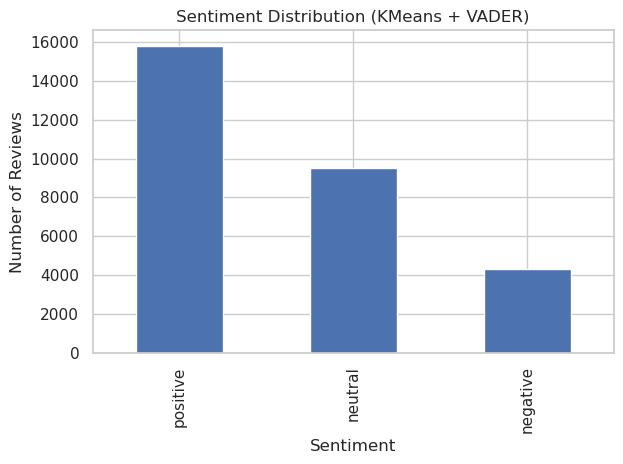

In [162]:
import matplotlib.pyplot as plt

df["sentiment"].value_counts().plot(kind="bar")

plt.title("Sentiment Distribution (KMeans + VADER)")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.tight_layout()
plt.show()


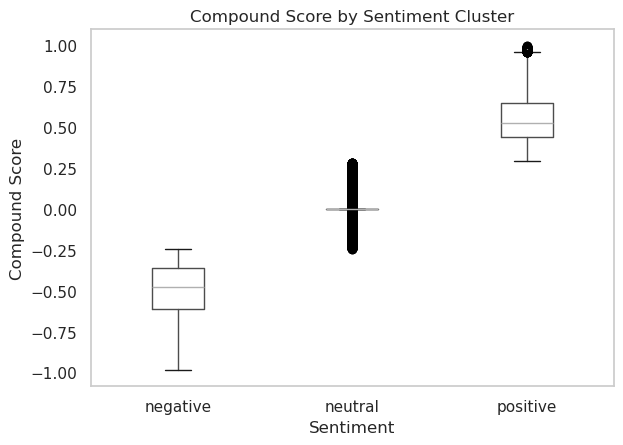

In [163]:
df.boxplot(column="compound", by="sentiment", grid=False)

plt.title("Compound Score by Sentiment Cluster")
plt.suptitle("")
plt.xlabel("Sentiment")
plt.ylabel("Compound Score")
plt.tight_layout()
plt.show()


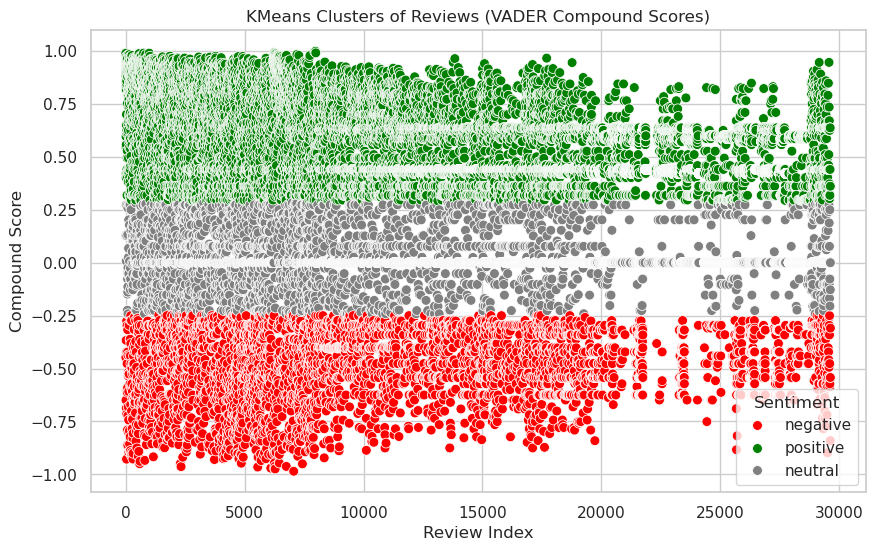

In [164]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Plot the clusters along the compound score
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=range(len(df)), 
    y="compound", 
    hue="sentiment", 
    palette={"negative":"red", "neutral":"gray", "positive":"green"},
    data=df,
    s=50
)
plt.title("KMeans Clusters of Reviews (VADER Compound Scores)")
plt.xlabel("Review Index")
plt.ylabel("Compound Score")
plt.legend(title="Sentiment")
plt.show()


The KNN clustering makes a custom threshold for us without us needing to have a hard coded threshold for different sentiments.The reviews seem to be perfectly clustered with respect to their respective scores.

Top words in negative cluster: [('not', 1043), ('twitter', 875), ('no', 863), ('instagram', 826), ('bad', 486), ('post', 452), ('people', 363), ('worst', 325), ('like', 323), ('see', 321)]
Top words in positive cluster: [('good', 3850), ('twitter', 3220), ('like', 2429), ('nice', 2177), ('instagram', 1673), ('better', 1599), ('great', 1178), ('not', 1133), ('best', 985), ('love', 930)]
Top words in neutral cluster: [('twitter', 1711), ('not', 1216), ('instagram', 1145), ('copy', 503), ('post', 456), ('need', 414), ('see', 390), ('use', 379), ('no', 374), ('follow', 350)]


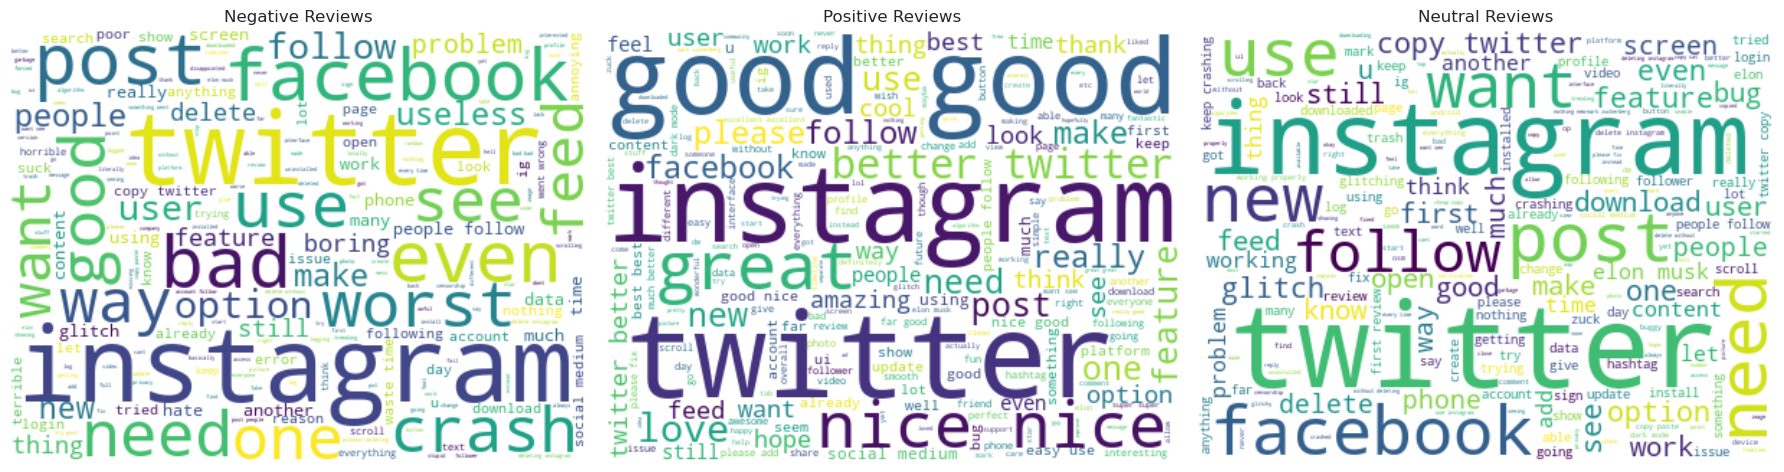

In [165]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Define a function to get top words
def get_top_words(text_series, n=10):
    words = " ".join(text_series).split()
    counter = Counter(words)
    return counter.most_common(n)

# Plot word clouds for each sentiment cluster
sentiments = df["sentiment"].unique()
plt.figure(figsize=(18,6))

for i, sentiment in enumerate(sentiments, 1):
    text = df[df["sentiment"] == sentiment]["review_cleaned"]
    
    # Generate word cloud
    wordcloud = WordCloud(width=400, height=300, background_color="white").generate(" ".join(text))
    
    # Plot
    plt.subplot(1, len(sentiments), i)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"{sentiment.capitalize()} Reviews")
    
    # Print top 10 words in console
    print(f"Top words in {sentiment} cluster:", get_top_words(text))

plt.tight_layout()
plt.show()

threads_pos = df[df["sentiment"] == "positive"]
threads_neu = df[df["sentiment"] == "neutral"]
threads_neg = df[df["sentiment"] == "negative"]


- The negative word cloud shows frustrations about posting, missing features, and comparisons where Threads feels worse than Twitter/Instagram.
- The positive word cloud highlights enthusiasm, with words like good, nice, great, and love showing strong early satisfaction.
- The neutral word cloud reflects general observations about usage: copying, posting, following, and feature needs without strong sentiment.

In [166]:
# Stabdardize manual labelling

# Make a copy
df_threads = df.copy()

# Clean label mapping
label_mapping = {
    'negative': 'negative',
    'positive': 'positive',
    'neutral': 'neutral',
    'Negative': 'negative',
    'Positive': 'positive',
    'Neutral': 'neutral',
}

# Create cleaned labels column
df_threads["sentiment_true_clean"] = df_threads["sentiment_true"].map(label_mapping)

# Check unmapped labels
unmapped = df_threads[df_threads["sentiment_true_clean"].isna()]["sentiment_true"].unique()
print("Unmapped labels:", unmapped)

print(df_threads["sentiment_true_clean"].value_counts())


Unmapped labels: [nan 'negatie' 'positive ' 'negtaive' 'neutral ' 'negative ']
sentiment_true_clean
neutral     1398
positive     867
negative     782
Name: count, dtype: int64


In [167]:
# Use only manually labeled rows
from sklearn.model_selection import train_test_split

df_gold = df_threads[df_threads["sentiment_true_clean"].notna()].copy()

# Train/test split on labeled subset
train_df, test_df = train_test_split(
    df_gold,
    test_size=0.2,
    random_state=42,
    stratify=df_gold["sentiment_true_clean"]
)

print("Train distribution:\n", train_df["sentiment_true_clean"].value_counts())
print("Test distribution:\n", test_df["sentiment_true_clean"].value_counts())


Train distribution:
 sentiment_true_clean
neutral     1118
positive     693
negative     626
Name: count, dtype: int64
Test distribution:
 sentiment_true_clean
neutral     280
positive    174
negative    156
Name: count, dtype: int64


THREADS — VADER SENTIMENT RELIABILITY CHECK

Total manually labeled samples: 3047

Distribution of manual labels:
sentiment_true_clean
neutral     1398
positive     867
negative     782
Name: count, dtype: int64

Distribution of VADER predictions:
sentiment
positive    1582
neutral      893
negative     572
Name: count, dtype: int64

OVERALL METRICS:
Accuracy:          0.5445 (54.45%)
Precision (Macro): 0.5533
Recall (Macro):    0.5710
F1-Score (Macro):  0.5299

DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    negative     0.5402    0.3951    0.4564       782
     neutral     0.6114    0.3906    0.4766      1398
    positive     0.5082    0.9273    0.6566       867

    accuracy                         0.5445      3047
   macro avg     0.5533    0.5710    0.5299      3047
weighted avg     0.5638    0.5445    0.5227      3047



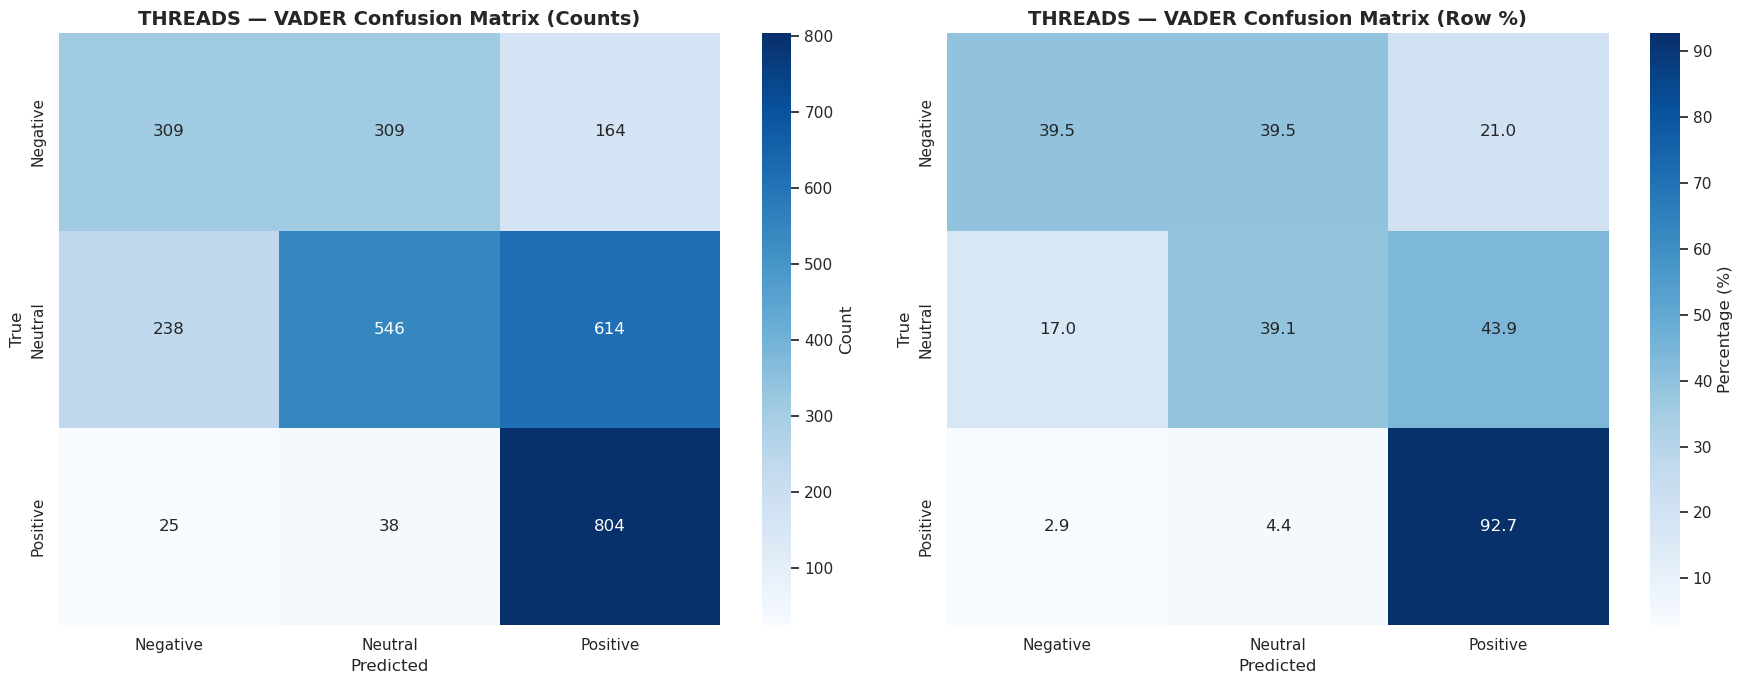

In [168]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# ============================================
# VADER RELIABILITY CHECK WITH CLEAN LABELS (THREADS)
# ============================================
print("THREADS — VADER SENTIMENT RELIABILITY CHECK")

# Filter only manually labeled rows
df_labeled = df_threads[df_threads['sentiment_true_clean'].notna()].copy()

print(f"\nTotal manually labeled samples: {len(df_labeled)}")
print("\nDistribution of manual labels:")
print(df_labeled['sentiment_true_clean'].value_counts())

print("\nDistribution of VADER predictions:")
print(df_labeled['sentiment'].value_counts())

# Calculate metrics
y_true = df_labeled['sentiment_true_clean']
y_pred = df_labeled['sentiment']

# Overall metrics
accuracy = accuracy_score(y_true, y_pred)
precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)

print("\nOVERALL METRICS:")
print(f"Accuracy:          {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro):    {recall_macro:.4f}")
print(f"F1-Score (Macro):  {f1_macro:.4f}")

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_true, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=['negative', 'neutral', 'positive'])

# Row % matrix
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# =============================
# PLOT CONFUSION MATRICES
# =============================
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# COUNTS PLOT
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'],
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('THREADS — VADER Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('True', fontsize=12)

# PERCENTAGES PLOT
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'],
            ax=axes[1], cbar_kws={'label': 'Percentage (%)'})
axes[1].set_title('THREADS — VADER Confusion Matrix (Row %)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('True', fontsize=12)

plt.tight_layout()
plt.show()


[Overall Summary]
We validated VADER sentiment predictions using 3,047 manually labeled Threads reviews.
VADER’s overall accuracy was 54.45%, with macro F1 of 0.53, indicating modest performance.
The confusion matrix shows that VADER tends to overpredict positive sentiment and struggles with neutral or negative statements, largely due to slang and informal writing in user-generated social media data.

[Detailed]
To evaluate the reliability of VADER sentiment classification for our Threads dataset, we manually labelled a validation set of 3,047 comments. VADER achieved an accuracy of 54.45% and a macro F1-score of 0.53, indicating moderate but limited performance as a lexicon-based, unsupervised baseline. This is expected because Threads comments contain slang and conversational tone that are difficult for rule-based models to interpret.
VADER performed well for positive sentiment, achieving a high recall of 92.73% and an F1-score of 0.66, suggesting that it reliably recognises positive language on Threads. However, the model showed substantial challenges with neutral and negative sentiment. Negative comments were identified with reasonable precision (54.02%) but low recall (39.51%), meaning many negative posts were incorrectly classified as neutral or positive. Neutral sentiment was particularly difficult (F1: 0.48), which aligns with known limitations of lexicon-based approaches when dealing with ambiguous, informal, or context-heavy text. Human labelling may also include subjectivity, contributing to inconsistencies in this category.
Overall, VADER provides a useful initial baseline for sentiment labeling on Threads data, but its limitations—especially around neutral and negative sentiment.

In [169]:
## Sentiment Classification: TF-IDF + Logistic regression

In [170]:
# Use the full dataset with VADER+KMeans sentiment
df_vader = df_threads.copy()

# Only keep rows where VADER assigned a label (it should be all)
df_vader = df_vader[df_vader["sentiment"].notna()]

print(df_vader["sentiment"].value_counts())


sentiment
positive    15800
neutral      9525
negative     4321
Name: count, dtype: int64


In [171]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2),
    min_df=3,
    stop_words="english"
)

X_train = tfidf.fit_transform(train_df["review_cleaned"])
X_test = tfidf.transform(test_df["review_cleaned"])

y_train = train_df["sentiment"]
y_test = test_df["sentiment"]


In [172]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    n_jobs=-1
)

model.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=2000, n_jobs=-1)

In [173]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Accuracy: 0.7442622950819672

Classification Report:
              precision    recall  f1-score   support

    negative     0.5122    0.5888    0.5478       107
     neutral     0.6298    0.7401    0.6805       177
    positive     0.9319    0.7975    0.8595       326

    accuracy                         0.7443       610
   macro avg     0.6913    0.7088    0.6959       610
weighted avg     0.7706    0.7443    0.7529       610



[Summary]

We trained a TF-IDF + Logistic Regression classifier on the Threads dataset using VADER-generated sentiment labels.
The model achieved an accuracy of 74.43% with a macro F1-score of 0.70, which represents a clear improvement compared to VADER’s direct predictions.

Performance varies across sentiment classes:

- Positive sentiment was detected most reliably (F1 = 0.86) with strong precision (0.93).
- Neutral class achieved moderate performance (F1 = 0.68) and was generally well-recalled (0.74).
- Negative sentiment remained the most challenging (F1 = 0.55), though the classifier still outperformed VADER in this category.

[Can be revised based on other model results]

Overall, these results show that a traditional machine-learning model like TF-IDF + Logistic Regression can still provide strong performance for social media sentiment classification. Despite being trained on weak (auto-generated) labels, the model captures meaningful textual patterns and offers more stable, consistent predictions than lexicon-based approaches such as VADER.

In [174]:
## Sentiment Classification: DistilBERT Fine-Tuning

In [175]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import TrainingArguments, Trainer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import torch

# Encode Labels
label_encoder = LabelEncoder()
y_train_bert = label_encoder.fit_transform(train_df["sentiment"])
y_test_bert = label_encoder.transform(test_df["sentiment"])

In [176]:
# Tokenize Text for BERT
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

train_enc = tokenizer(
    train_df["review_description"].tolist(), # used raw data, not cleaned one
    truncation=True,
    padding=True,
    max_length=128
)

test_enc = tokenizer(
    test_df["review_description"].tolist(),
    truncation=True,
    padding=True,
    max_length=128
)

In [177]:
# Build Dataset Objects
class BERTDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k,v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = BERTDataset(train_enc, y_train_bert)
test_dataset = BERTDataset(test_enc, y_test_bert)

In [178]:
# Load DistilBERT Model+ Define TrainingArguments + Trainer
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3
)

training_args = TrainingArguments(
    output_dir="./bert_results",
    eval_strategy="epoch", #  evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    seed=SEED  
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [179]:
# Train and Evaluation
trainer.train()

preds = trainer.predict(test_dataset)
y_pred_bert = np.argmax(preds.predictions, axis=1)

print("BERT Accuracy:", accuracy_score(y_test_bert, y_pred_bert))
print(classification_report(
    y_test_bert,
    y_pred_bert,
    target_names=label_encoder.classes_,
    digits=4
))

BERT Accuracy: 0.8442622950819673
              precision    recall  f1-score   support

    negative     0.6641    0.8131    0.7311       107
     neutral     0.7988    0.7401    0.7683       177
    positive     0.9429    0.9110    0.9267       326

    accuracy                         0.8443       610
   macro avg     0.8019    0.8214    0.8087       610
weighted avg     0.8522    0.8443    0.8464       610



[Summary]

Fine-tuning DistilBERT on the Threads dataset significantly improved sentiment classification performance.
The model achieved 84.43% accuracy and a macro F1-score of 0.81, outperforming both VADER (≈54% accuracy) and the TF-IDF + Logistic Regression baseline (macro F1 ≈0.70).

Performance gains were especially strong for negative and neutral categories—classes that rule-based approaches typically struggle with:

Negative: F1 = 0.73

Neutral: F1 = 0.77

Positive: F1 = 0.93

These results demonstrate that pretrained transformer models can effectively capture nuanced linguistic cues even when trained on noisy, weakly labeled data.
Overall, DistilBERT provides a much more robust and reliable method for real-world social media sentiment analysis compared to lexicon-based or classical machine-learning baselines.

## SENTIMENT ANALYSIS : USING VADER + KNN FOR TWITTER

By applying KMeans clustering to the compound sentiment scores, we could segment reviews into three clusters. The centroids of these clusters inform the thresholds for classifying sentiment, allowing for more objective labeling than manual cutoff values.

In [180]:

# ----------- LOAD DATA --------------
df = twitter_clean.copy()     
# ------------------------------------


# ---------- VADER SCORES -----------
analyzer = SentimentIntensityAnalyzer()
df["compound"] = df["review_cleaned"].apply(lambda x: analyzer.polarity_scores(x)["compound"])
compound_array = df["compound"].values.reshape(-1,1)
# ------------------------------------

# ----------- KMEANS 3 CLUSTERS -----
kmeans = KMeans(n_clusters=3, random_state=42, n_init=20)
clusters = kmeans.fit_predict(compound_array)
df["cluster"] = clusters

# map centroids -> pos/neu/neg
centroids = kmeans.cluster_centers_.flatten()
order = np.argsort(centroids)
label_map = {order[0]: "negative", order[1]: "neutral", order[2]: "positive"}

df["sentiment"] = df["cluster"].map(label_map)
# ------------------------------------

print(df[["review_text","review_cleaned","compound","sentiment"]].head())


                                         review_text  \
0  A cesspool of bigotry, rascism, homophobia, tr...   
1  It is good to see there are a lot of people th...   
2  I am removing this app because I abuse Manoj M...   
3  Twitter is nice but my account often got locke...   
4  It's better actually. Just improve the video w...   

                                      review_cleaned  compound sentiment  
0  cesspool bigotry rascism homophobia transphobi...   -0.5859  negative  
1  good see lot people believe thing government d...    0.5106  positive  
2  removing abuse manoj muntasir tweet happened p...    0.8885  positive  
3  nice often got locked lot violation even know ...   -0.0772   neutral  
4  better actually improve video watching experie...    0.7003  positive  


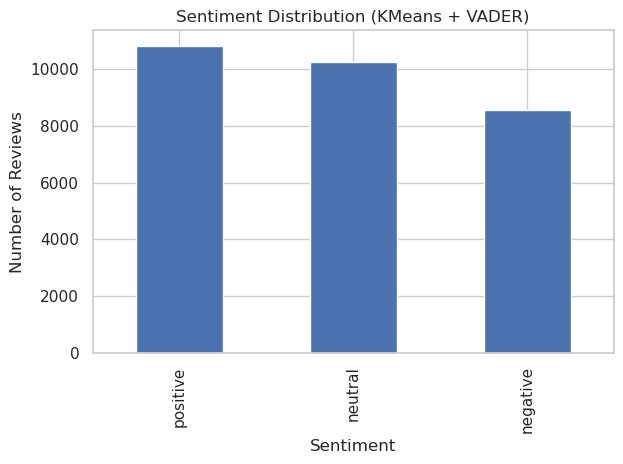

In [181]:
import matplotlib.pyplot as plt

df["sentiment"].value_counts().plot(kind="bar")

plt.title("Sentiment Distribution (KMeans + VADER)")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.tight_layout()
plt.show()


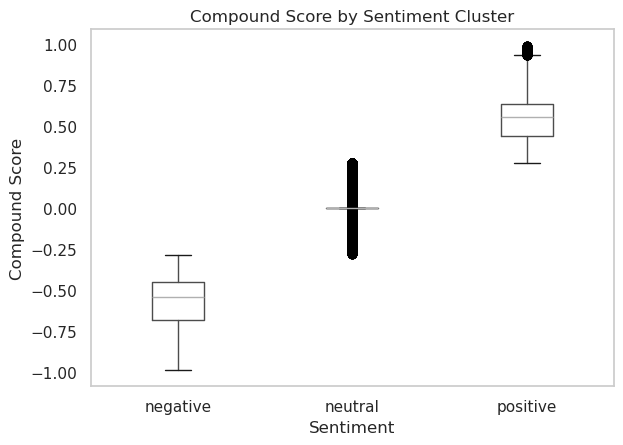

In [182]:
df.boxplot(column="compound", by="sentiment", grid=False)

plt.title("Compound Score by Sentiment Cluster")
plt.suptitle("")
plt.xlabel("Sentiment")
plt.ylabel("Compound Score")
plt.tight_layout()
plt.show()


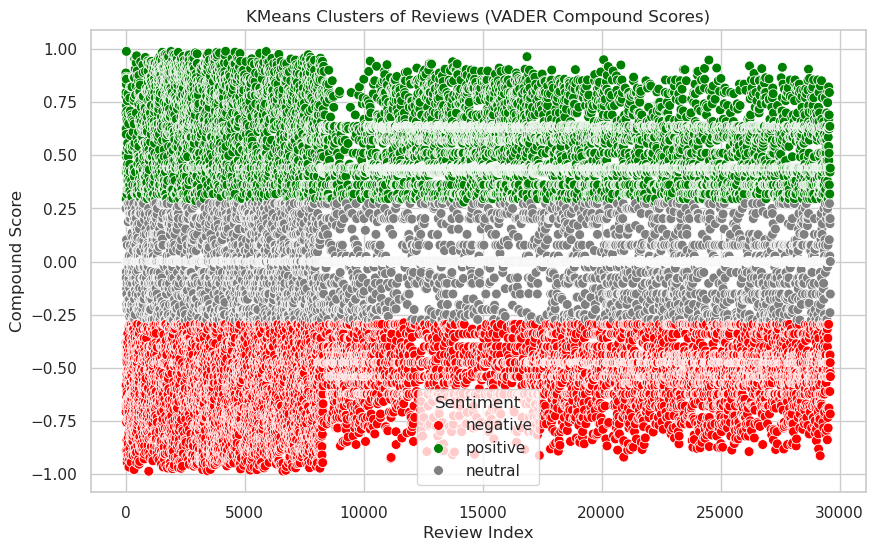

In [183]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Plot the clusters along the compound score
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=range(len(df)), 
    y="compound", 
    hue="sentiment", 
    palette={"negative":"red", "neutral":"gray", "positive":"green"},
    data=df,
    s=50
)
plt.title("KMeans Clusters of Reviews (VADER Compound Scores)")
plt.xlabel("Review Index")
plt.ylabel("Compound Score")
plt.legend(title="Sentiment")
plt.show()




Top words in negative cluster: [('elon', 1477), ('not', 1175), ('no', 963), ('worse', 870), ('bad', 865), ('new', 753), ('musk', 752), ('tweet', 746), ('ruined', 695), ('worst', 604)]
Top words in positive cluster: [('good', 2173), ('like', 1213), ('elon', 1103), ('best', 1043), ('great', 1015), ('better', 986), ('not', 800), ('love', 781), ('nice', 738), ('social', 563)]
Top words in neutral cluster: [('elon', 1305), ('not', 1147), ('tweet', 667), ('back', 654), ('musk', 644), ('change', 568), ('like', 464), ('new', 447), ('name', 440), ('bird', 416)]


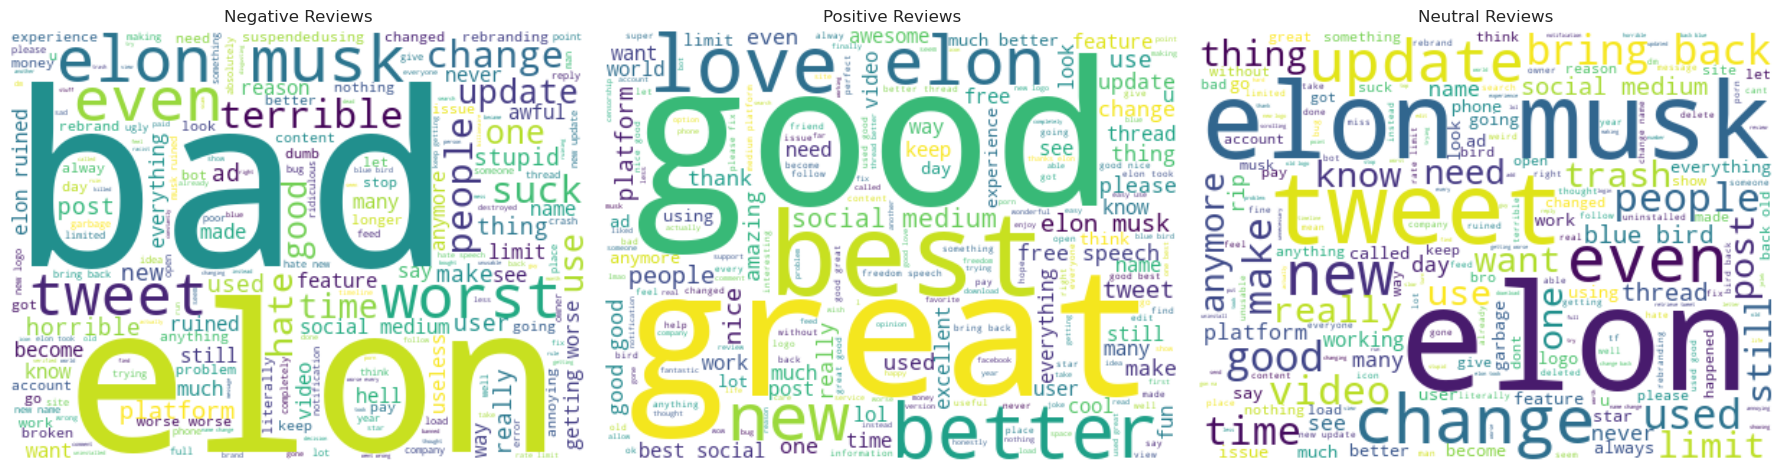

In [184]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Define a function to get top words
def get_top_words(text_series, n=10):
    words = " ".join(text_series).split()
    counter = Counter(words)
    return counter.most_common(n)

# Plot word clouds for each sentiment cluster
sentiments = df["sentiment"].unique()
plt.figure(figsize=(18,6))

for i, sentiment in enumerate(sentiments, 1):
    text = df[df["sentiment"] == sentiment]["review_cleaned"]
    
    # Generate word cloud
    wordcloud = WordCloud(width=400, height=300, background_color="white").generate(" ".join(text))
    
    # Plot
    plt.subplot(1, len(sentiments), i)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"{sentiment.capitalize()} Reviews")
    
    # Print top 10 words in console
    print(f"Top words in {sentiment} cluster:", get_top_words(text))

plt.tight_layout()
plt.show()


- The negative word cloud shows frustration with Elon/Musk, worsening updates, and strong complaints about the platform becoming “bad,” “worse,” and “ruined.”
- The positive word cloud highlights appreciation for certain features and updates, with users expressing satisfaction through words like good, great, best, and love.
- The neutral word cloud reflects general discussion around Elon/Musk, tweets, changes, and platform updates without strong emotional tone.

In [185]:
df_twitter = df.copy()

from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df_twitter, 
    test_size=0.2, 
    random_state=42,
    stratify=df_twitter['sentiment'] 
)
twitter_pos = df[df["sentiment"] == "positive"]
twitter_neu = df[df["sentiment"] == "neutral"]
twitter_neg = df[df["sentiment"] == "negative"]


twitter_pos_train = train_df[train_df["sentiment"] == "positive"]
twitter_neu_train = train_df[train_df["sentiment"] == "neutral"]
twitter_neg_train = train_df[train_df["sentiment"] == "negative"]

twitter_pos_test = test_df[test_df["sentiment"] == "positive"]
twitter_neu_test = test_df[test_df["sentiment"] == "neutral"]
twitter_neg_test = test_df[test_df["sentiment"] == "negative"]


### Correlation between Rating and VADER sentiment for Twitter

In [186]:
# ============================================
# 4. CORRELATION ANALYSIS
# ============================================
print("CORRELATION ANALYSIS")
'''
# Pearson correlation between rating and compound score
from scipy.stats import pearsonr, spearmanr

correlation_pearson, p_value_pearson = pearsonr(df_threads['review_rating'], df_threads['compound'])
correlation_spearman, p_value_spearman = spearmanr(df_threads['review_rating'], df_threads['compound'])

print(f"\nPearson Correlation (Rating vs Compound):  {correlation_pearson:.4f} (p-value: {p_value_pearson:.4e})")
print(f"Spearman Correlation (Rating vs Compound): {correlation_spearman:.4f} (p-value: {p_value_spearman:.4e})")

# Scatter plot with trend line
plt.figure(figsize=(10, 6))
plt.scatter(df_threads['review_rating'], df_threads['compound'], alpha=0.5, s=30)
z = np.polyfit(df_threads['review_rating'], df_threads['compound'], 1)
p = np.poly1d(z)
plt.plot(df_threads['review_rating'].unique(), p(df_threads['review_rating'].unique()), "r--", linewidth=2, label=f'Trend line (r={correlation_pearson:.3f})')
plt.xlabel('Rating', fontsize=12)
plt.ylabel('VADER Compound Score', fontsize=12)
plt.title('Rating vs VADER Compound Score\nWith Correlation Trend', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
'''


CORRELATION ANALYSIS


'\n# Pearson correlation between rating and compound score\nfrom scipy.stats import pearsonr, spearmanr\n\ncorrelation_pearson, p_value_pearson = pearsonr(df_threads[\'review_rating\'], df_threads[\'compound\'])\ncorrelation_spearman, p_value_spearman = spearmanr(df_threads[\'review_rating\'], df_threads[\'compound\'])\n\nprint(f"\nPearson Correlation (Rating vs Compound):  {correlation_pearson:.4f} (p-value: {p_value_pearson:.4e})")\nprint(f"Spearman Correlation (Rating vs Compound): {correlation_spearman:.4f} (p-value: {p_value_spearman:.4e})")\n\n# Scatter plot with trend line\nplt.figure(figsize=(10, 6))\nplt.scatter(df_threads[\'review_rating\'], df_threads[\'compound\'], alpha=0.5, s=30)\nz = np.polyfit(df_threads[\'review_rating\'], df_threads[\'compound\'], 1)\np = np.poly1d(z)\nplt.plot(df_threads[\'review_rating\'].unique(), p(df_threads[\'review_rating\'].unique()), "r--", linewidth=2, label=f\'Trend line (r={correlation_pearson:.3f})\')\nplt.xlabel(\'Rating\', fontsize=12)\

### Checking Reliability of VADER labelling

In [187]:
print(df_twitter['sentiment_true'].value_counts())


sentiment_true
Negative    1783
Positive     855
Neutral      170
ngea           6
negative       5
Nge            3
neag           3
neha           2
nga            1
Negaive        1
NGEA           1
[ps            1
N              1
bega           1
pnega          1
spos           1
Name: count, dtype: int64


In [188]:
# ============================================
# FIX AND STANDARDIZE LABELS
# ============================================
print("\n" + "="*60)
print("CLEANING AND STANDARDIZING LABELS")
print("="*60)

# Create mapping dictionary for typos and variations
label_mapping = {
    # Negative variations
    'Negative': 'negative',
    'ngea': 'negative',
    'negative': 'negative',
    'Nge': 'negative',
    'neag': 'negative',
    'nega': 'negative',
    'Negaive': 'negative',
    'nga': 'negative',
    'NGEA': 'negative',
    'N': 'negative',
    'bega': 'negative',
    'pnega': 'negative',
    'npega': 'negative',
    
    # Positive variations
    'Positive': 'positive',
    'spos': 'positive',
    '[ps': 'positive',
    
    # Neutral variations
    'Neutral': 'neutral',
    'neha': 'neutral'  # Assuming this is a typo for neutral
}

# Apply mapping
df_twitter['sentiment_true_clean'] = df_twitter['sentiment_true'].map(label_mapping)

# Check for any unmapped values
unmapped = df_twitter[df_twitter['sentiment_true'].notna() & df_twitter['sentiment_true_clean'].isna()]['sentiment_true'].unique()
if len(unmapped) > 0:
    print(f"\nWARNING: Found unmapped values: {unmapped}")
    print("These will be treated as NaN. Please add them to the mapping if needed.\n")

print("\nAfter cleaning - Value counts for 'sentiment_true_clean':")
print(df_twitter['sentiment_true_clean'].value_counts())

print("\nLabels successfully standardized!")
print(f"  - Total labeled: {df_twitter['sentiment_true_clean'].notna().sum()}")
print(f"  - Negative: {(df_twitter['sentiment_true_clean'] == 'negative').sum()}")
print(f"  - Positive: {(df_twitter['sentiment_true_clean'] == 'positive').sum()}")
print(f"  - Neutral: {(df_twitter['sentiment_true_clean'] == 'neutral').sum()}")




CLEANING AND STANDARDIZING LABELS

After cleaning - Value counts for 'sentiment_true_clean':
sentiment_true_clean
negative    1806
positive     857
neutral      172
Name: count, dtype: int64

Labels successfully standardized!
  - Total labeled: 2835
  - Negative: 1806
  - Positive: 857
  - Neutral: 172


VADER SENTIMENT RELIABILITY CHECK

Total manually labeled samples: 2835

Distribution of manual labels:
sentiment_true_clean
negative    1806
positive     857
neutral      172
Name: count, dtype: int64

Distribution of VADER predictions:
sentiment
positive    1073
negative     909
neutral      853
Name: count, dtype: int64
OVERALL METRICS:
Accuracy:          0.6085 (60.85%)
Precision (Macro): 0.5933
Recall (Macro):    0.6421
F1-Score (Macro):  0.5375
DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    negative     0.9725    0.4895    0.6512      1806
     neutral     0.1149    0.5698    0.1912       172
    positive     0.6925    0.8670    0.7699       857

    accuracy                         0.6085      2835
   macro avg     0.5933    0.6421    0.5375      2835
weighted avg     0.8358    0.6085    0.6592      2835



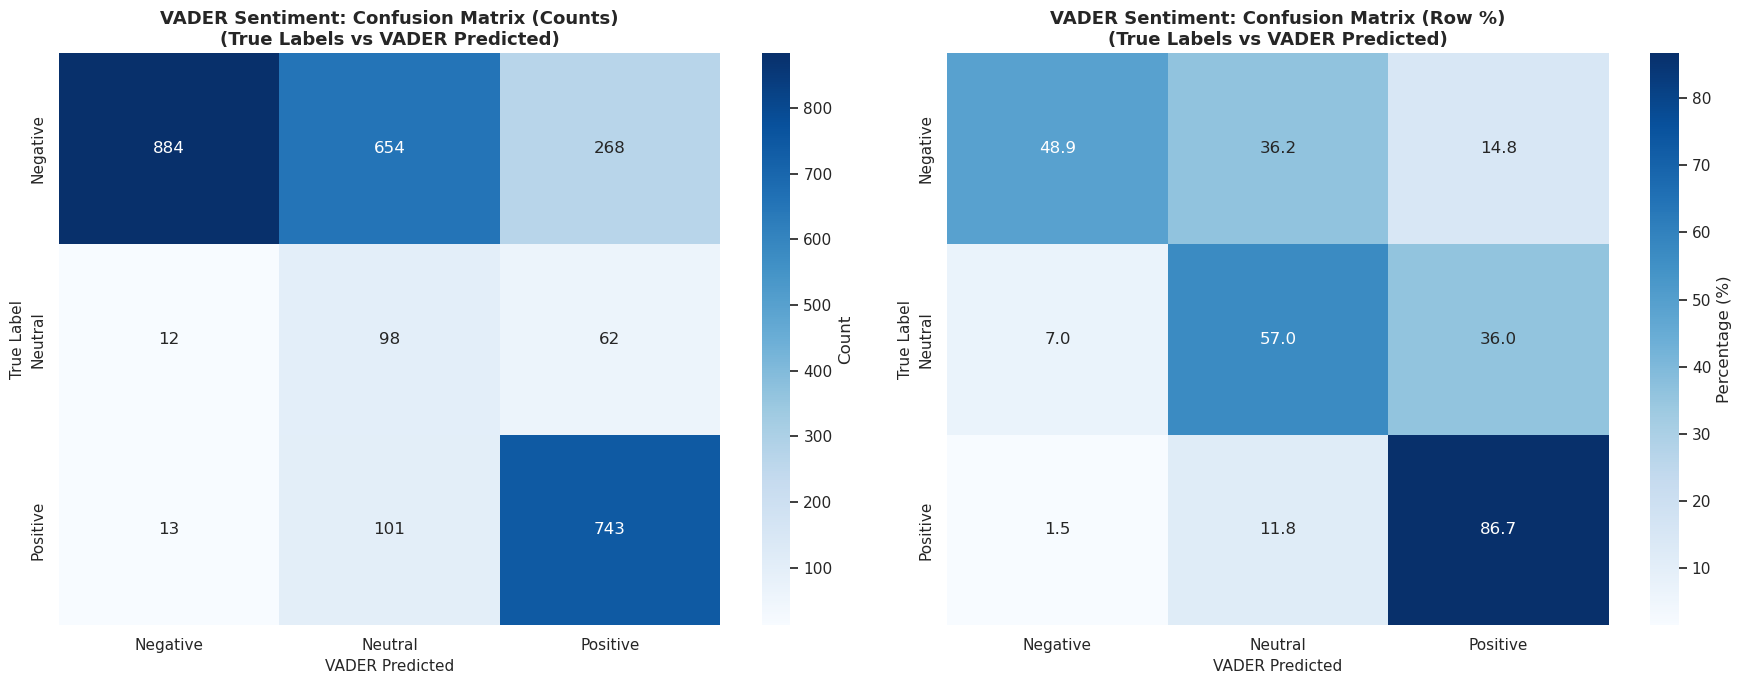

In [189]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# ============================================
# VADER RELIABILITY CHECK WITH CLEAN LABELS
# ============================================
print("VADER SENTIMENT RELIABILITY CHECK")

# Filter non-null sentiment_true values
df_labeled = df_twitter[df_twitter['sentiment_true_clean'].notna()].copy()
print(f"\nTotal manually labeled samples: {len(df_labeled)}")
print(f"\nDistribution of manual labels:")
print(df_labeled['sentiment_true_clean'].value_counts())
print(f"\nDistribution of VADER predictions:")
print(df_labeled['sentiment'].value_counts())

# Calculate metrics
y_true = df_labeled['sentiment_true_clean']
y_pred = df_labeled['sentiment']

# Overall metrics
accuracy = accuracy_score(y_true, y_pred)
precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)

print("OVERALL METRICS:")
print(f"Accuracy:          {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro):    {recall_macro:.4f}")
print(f"F1-Score (Macro):  {f1_macro:.4f}")

print("DETAILED CLASSIFICATION REPORT:")
print(classification_report(y_true, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=['negative', 'neutral', 'positive'])

# Calculate percentages for each row
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'],
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('VADER Sentiment: Confusion Matrix (Counts)\n(True Labels vs VADER Predicted)', 
                  fontsize=13, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=11)
axes[0].set_xlabel('VADER Predicted', fontsize=11)

# Percentages
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues', 
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'],
            ax=axes[1], cbar_kws={'label': 'Percentage (%)'})
axes[1].set_title('VADER Sentiment: Confusion Matrix (Row %)\n(True Labels vs VADER Predicted)', 
                  fontsize=13, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=11)
axes[1].set_xlabel('VADER Predicted', fontsize=11)

plt.tight_layout()
plt.show()


##### To evaluate the reliability of VADER sentiment classification for our Twitter dataset, we manually labelled a subset of around 3k reviews as a validation set. VADER achieved an overall accuracy of 60.85% with a macro F1-score of 0.54, showing reasonable performance as an unsupervised, lexicon-based baseline for social media sentiment analysis.

##### The model worked very well for for negative sentiment with precision (97.25%), indicating high confidence when classifying negative reviews, though with moderate recall (48.95%). Positive sentiment detection was really accurate as well , with 86.70% recall and an F1-score of 0.77, suggesting VADER effectively captures positive expressions on Twitter data. As expected with rule-based approaches, neutral sentiment proved challenging (F1: 0.19), a common issue when analysing context-dependent langauge in social media. The manual labelling could also be dependent on an individual hence, making it ambiguous for humans as well

##### These results validate VADER as a suitable tool for initial sentiment labeling and could be used for sentiment classification. 


## Data Cleaning Pipeline 2 (for topic modelling) 

In [190]:
# Data Cleaning 2
from gensim.utils import simple_preprocess
from gensim.models import Phrases
from gensim.models.phrases import Phraser

negations = {"no", "not", "nor", "dont", "can't", "cannot", "never"}
stop_words = stop_words - negations

# App-specific words to remove
custom_stopwords_tm = set([
    "app", "apps", "application", "applications",
    "experience", "account", 
])

# ============================
#  Cleaning Function
# ============================
def clean_text_for_tm(text):
    # text = str(text).lower()
    # text = emoji.replace_emoji(text, replace="")
    # text = re.sub(r"http\S+|www\S+", "", text)
    # text = re.sub(r"[^a-zA-Z\s]", " ", text)  # keep only letters
    
    tokens = simple_preprocess(text, deacc=True)

    # # remove stopwords
    # tokens = [t for t in tokens if t not in stop_words]
    # tokens = [t for t in tokens if t not in custom_stopwords_tm]

    return tokens

# ============================
#  Bigram Builder
# ============================
def create_bigrams(texts):
    bigram = Phrases(texts, min_count=10, threshold=10)
    bigram_mod = Phraser(bigram)
    return [bigram_mod[doc] for doc in texts]

# ============================
# Prepare Dataset for Topic Modeling
# ============================
def prepare_tm_texts(df):
    docs = df["review_cleaned"].apply(clean_text_for_tm).tolist()
    docs_bigrams = create_bigrams(docs)
    return docs_bigrams



## Topic Modelling 1 with sentiment labels (pos, neu, neg)

In [191]:


from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel


def train_lda_model(docs_bigrams, num_topics=5):

    dictionary = Dictionary(docs_bigrams)
    dictionary.filter_extremes(no_below=10, no_above=0.5)

    corpus = [dictionary.doc2bow(doc) for doc in docs_bigrams]

    lda_model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=42,
        chunksize=2000,
        passes=10,
        alpha='auto'
    )

    coherence_model = CoherenceModel(
        model=lda_model,
        texts=docs_bigrams,
        dictionary=dictionary,
        coherence='c_v'
    )

    coherence_score = coherence_model.get_coherence()

    return lda_model, corpus, dictionary, coherence_score



def run_lda(docs_df):
    docs_bigrams = prepare_tm_texts(docs_df)

    topic_range = range(3, 7)
    coherence_scores = {}

    for k in topic_range:
        lda_model, corpus, dictionary, coherence = train_lda_model(docs_bigrams, num_topics=k)
        coherence_scores[k] = coherence
        print(f"k={k} Coherence={coherence:.4f}")

    best_k = max(coherence_scores, key=coherence_scores.get)
    print("\nBest number of topics =", best_k)

    final_lda, corpus, dictionary, coherence = train_lda_model(docs_bigrams, num_topics=best_k)

    print("Final Coherence Score:", coherence)

    topics = final_lda.show_topics(num_topics=-1, num_words=15, formatted=False)

    for topic_id, words in topics:
        print(f"TOPIC {topic_id+1}:")
        top_terms = [w for w, weight in words]
        print(", ".join(top_terms))
        print()

    return final_lda    # 


print("\n===== POSITIVE TOPICS =====")
def run_lda_block(df_input):
    print("\n===== RUNNING LDA BLOCK =====")
    return run_lda(df_input)

# print("\n===== THREADS NEUTRAL TOPICS =====")
# lda_neu = run_lda(threads_neu)

# print("\n===== THREADS NEGATIVE TOPICS =====")
# lda_neg = run_lda(threads_neg)



===== POSITIVE TOPICS =====


### Visulaizing the Topics in pos, neu, neg (LDA)

In [192]:
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# Visualization helper
# ---------------------------------------------------------
def plot_lda_topic(words, weights, title):
    plt.figure(figsize=(10, 5))
    plt.barh(words[::-1], weights[::-1], color='royalblue')
    plt.title(title)
    plt.xlabel("Topic Weight")
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------
# Function to visualize topics for a trained LDA model
# ---------------------------------------------------------
def visualize_lda_topics(lda_model, sentiment_label, num_words=12):
    print(f"\n--- VISUALIZING LDA TOPICS: {sentiment_label.upper()} ---")

    topics = lda_model.show_topics(num_topics=-1, num_words=num_words, formatted=False)

    for topic_id, topic in topics:
        words = [w for w, wt in topic]
        weights = [wt for w, wt in topic]

        title = f"{sentiment_label.upper()} - LDA Topic {topic_id+1}"
        plot_lda_topic(words, weights, title)

# ---------------------------------------------------------
# Call this after you finish training lda_pos, lda_neu, lda_neg
# ---------------------------------------------------------

def visualize_lda_block(lda_model, sentiment_label):
    visualize_lda_topics(lda_model, sentiment_label)

# visualize_lda_topics(lda_pos, "Positive")
# visualize_lda_topics(lda_neu, "Neutral")
# visualize_lda_topics(lda_neg, "Negative")





## Threads LDA analysis


===== THREADS POSITIVE TOPICS =====

===== RUNNING LDA BLOCK =====
k=3 Coherence=0.5622
k=4 Coherence=0.5138
k=5 Coherence=0.5368
k=6 Coherence=0.5326

Best number of topics = 3
Final Coherence Score: 0.5621586612540163
TOPIC 1:
great, best, twitter, awesome, cool, excellent, instagram, new, facebook, like, thank, social_medium, use, platform, not_bad

TOPIC 2:
good, nice, twitter, better, love, amazing, super, wow, ok, like, perfect, far, aap, interesting, one

TOPIC 3:
like, instagram, not, post, need, please, see, feature, would, people, option, also, make, follow, add


===== THREADS NEUTRAL TOPICS =====

===== RUNNING LDA BLOCK =====
k=3 Coherence=0.5885
k=4 Coherence=0.5717
k=5 Coherence=0.5815
k=6 Coherence=0.5121

Best number of topics = 3
Final Coherence Score: 0.5885427701274883
TOPIC 1:
twitter, copy, elon_musk, elon, zuck, op, facebook, osm, trash, better, copied, mark, copy_cat, copy_paste, bakwas

TOPIC 2:
instagram, not, use, first, new, glitch, bug, even, delete, one, 

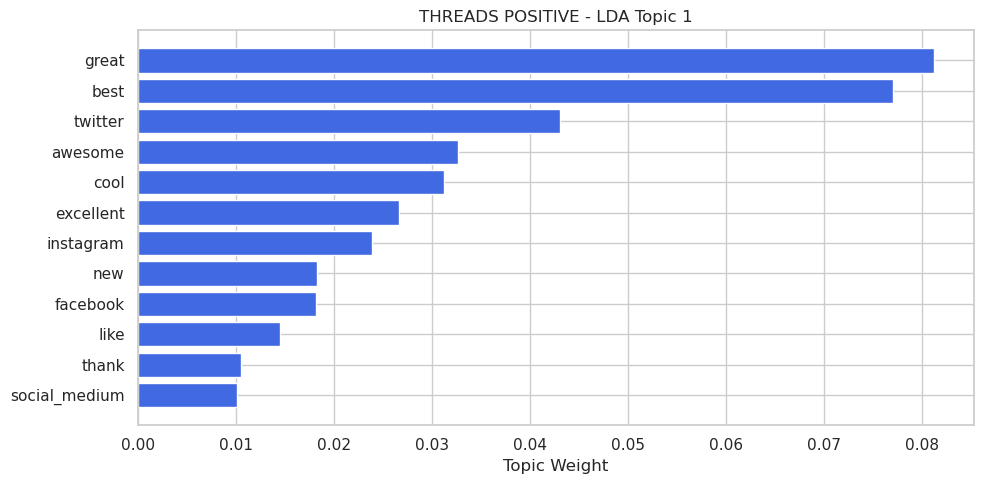

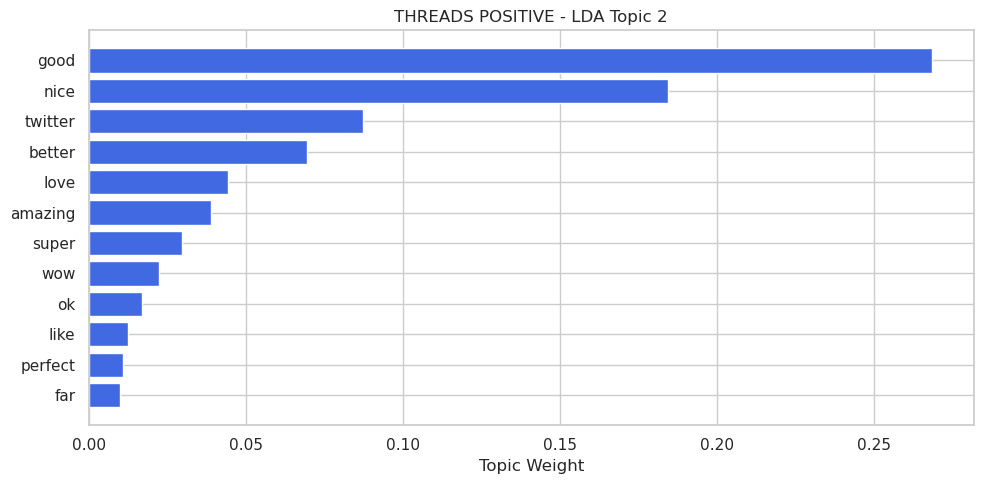

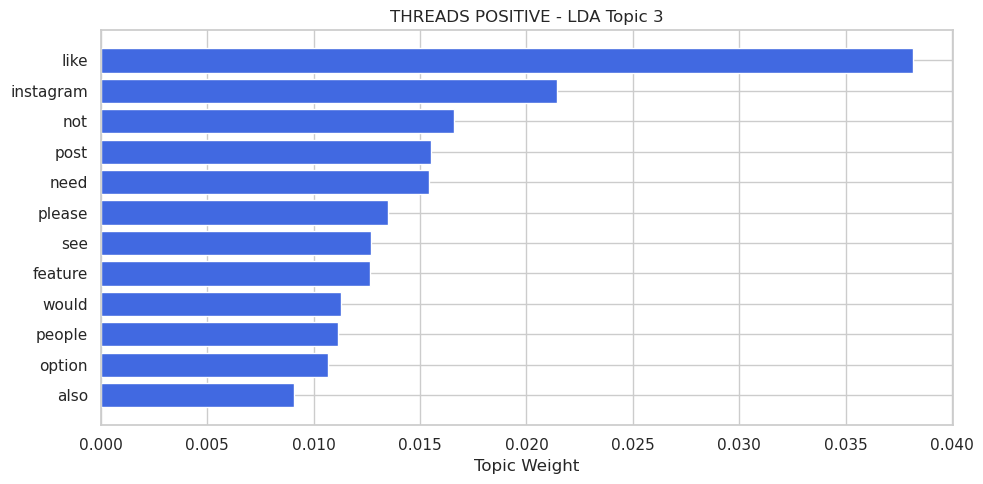


--- VISUALIZING LDA TOPICS: THREADS NEUTRAL ---


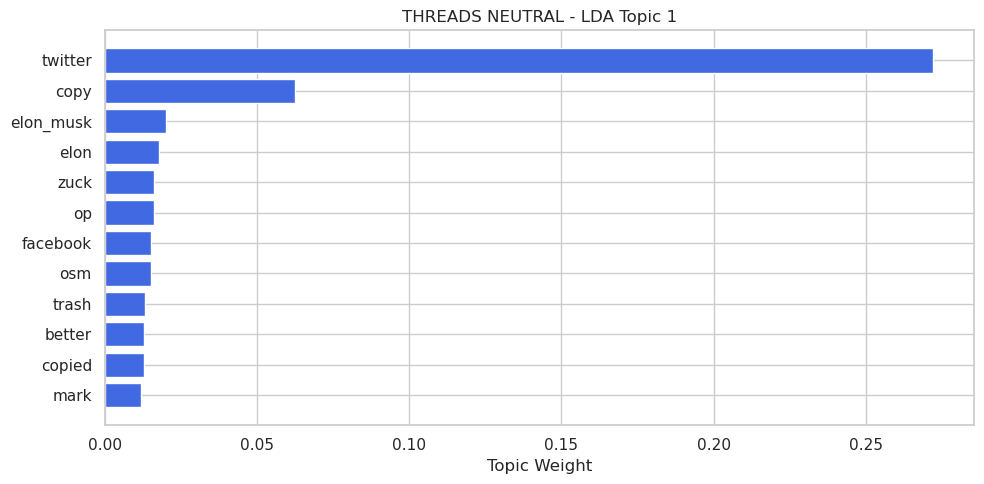

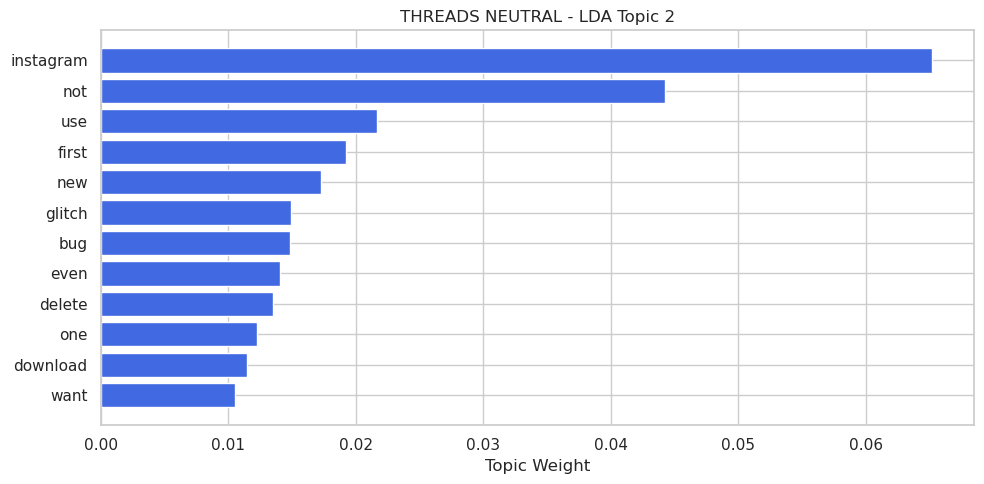

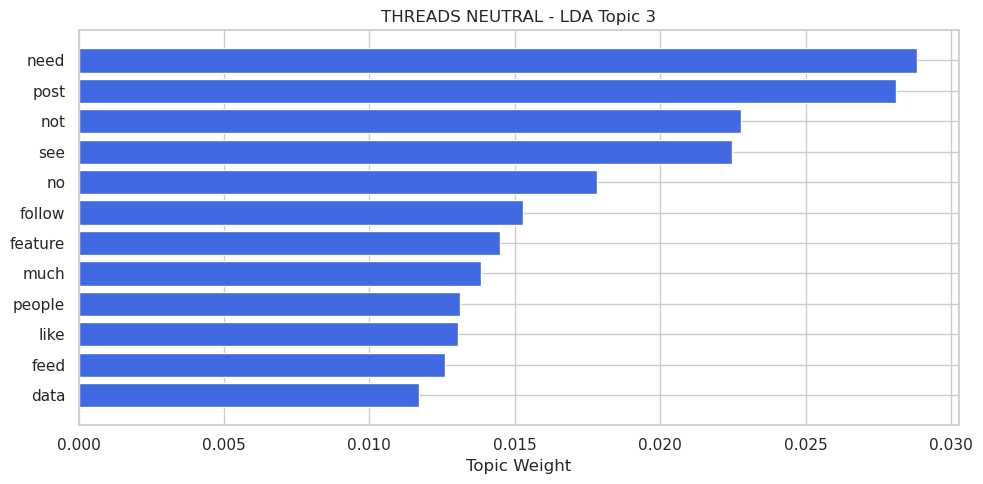


--- VISUALIZING LDA TOPICS: THREADS NEGATIVE ---


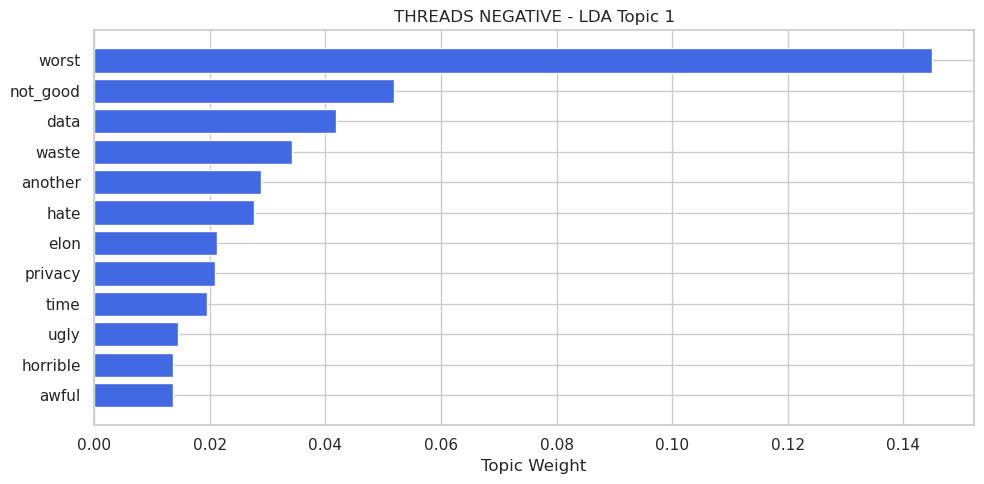

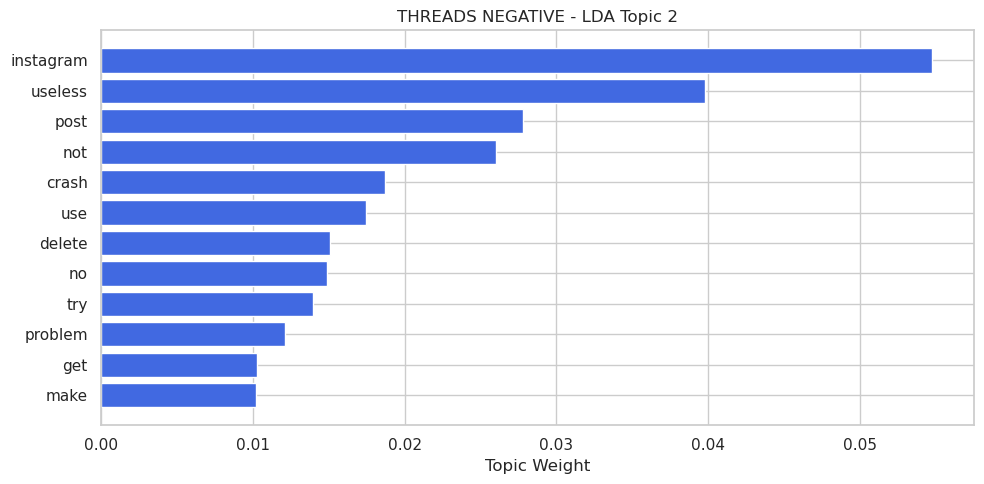

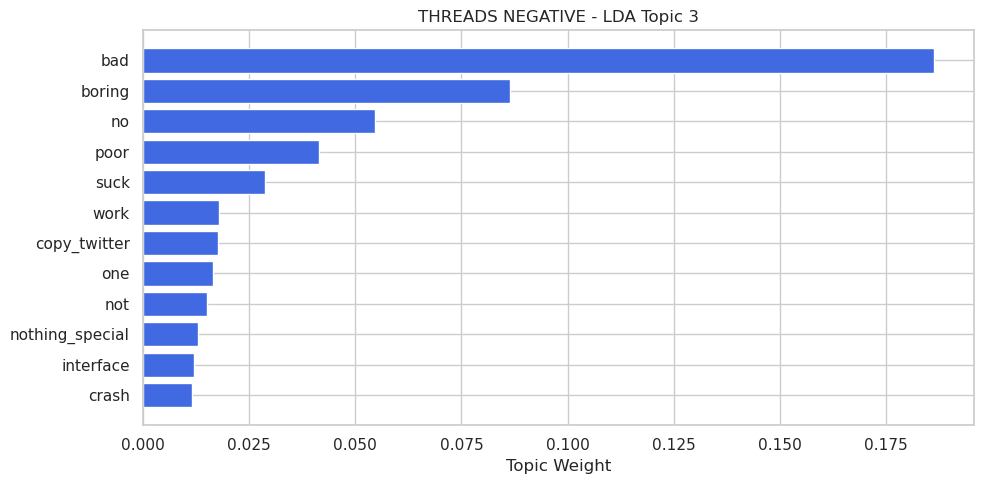

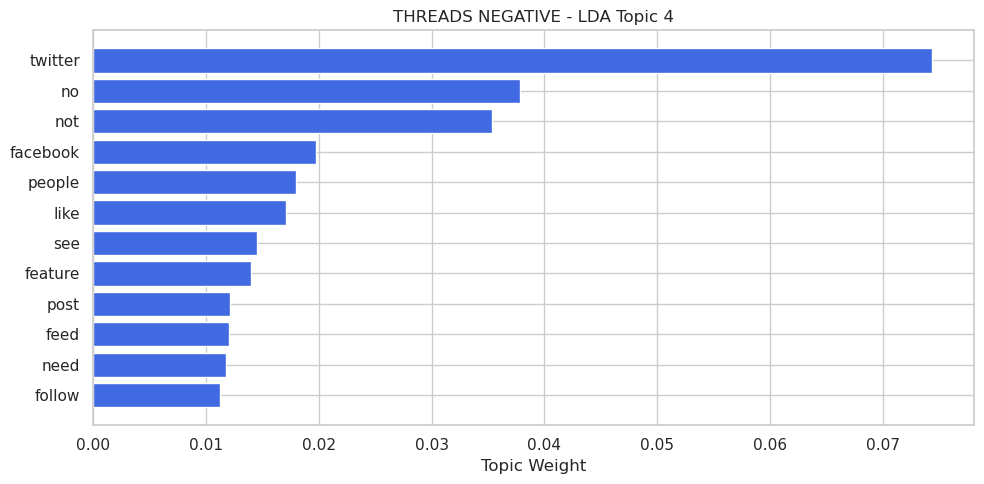

In [193]:


print("\n===== THREADS POSITIVE TOPICS =====")
lda_pos_threads = run_lda_block(threads_pos)
print("\n===== THREADS NEUTRAL TOPICS =====")
lda_neu_threads = run_lda_block(threads_neu)
print("\n===== THREADS NEGATIVE TOPICS =====")
lda_neg_threads = run_lda_block(threads_neg)

visualize_lda_block(lda_pos_threads, "Threads Positive")
visualize_lda_block(lda_neu_threads, "Threads Neutral")
visualize_lda_block(lda_neg_threads, "Threads Negative")


**Overall Summary:**
- Positive reviews: Users express generally positive impressions and note that the app works well, while also offering polite suggestions for additional features.
- Neutral reviews: Comments focus on platform comparisons, technical observations, and practical usage notes without strong emotional tone.
- Negative reviews: Users report dissatisfaction related to crashes, missing features, feed issues, and comparisons where Threads feels weaker than alternatives.

-------

**Positive Sentiment Analysis**
 
Best model: k = 3 topics — Coherence = 0.5622

**1. General Positivity** — *great, best, awesome, cool, excellent*

Users express broadly positive reactions toward the app.

**2. Basic Satisfaction** — *good, nice, better, love, amazing*

Many reviewers indicate they like using Threads and feel it works well.

**3. Polite Feature Requests** — *like, need, please, feature, option*

Even positive users mention improvements they would like to see added.

**Insight:**

Positive reviews reflect overall satisfaction, while still highlighting the need for additional features and refinements.

-------

**Neutral Sentiment Analysis**

Best model: k = 3 topics — Coherence = 0.5885

**1. Platform Comparisons & Commentary** — *twitter, copy, elon_musk, zuck, facebook*

Neutral discussions about the rivalry (Twitter vs Meta), copying debates, and general platform talk.

**2. Practical App Usage Notes** — *instagram, use, first, glitch, bug*

Matter-of-fact comments about using the app, early glitches, installations, or basic usability.

**3. Functional Suggestions** — *need, post, see, follow, feature*

Users provide neutral observations on feed behavior, posting, and missing features without emotional judgment.

**Insight:**
Neutral reviews are dominated by platform comparisons, technical notes, and feature suggestions, providing practical, non-emotional feedback.

-------

**Negative Sentiment Analysis**

Best model: k = 4 topics — Coherence = 0.5233

**1. Harsh Criticism & Rejection** — *worst, hate, horrible, awful, crazy*

Strongly emotional reactions rejecting the platform or complaining about Meta/Elon.

**2. Performance Failures** — *crash, useless, delete, problem, error*

Common frustrations with crashes, errors, and inability to post or use the app reliably.

**3. Low Quality & UX Problems** — *bad, boring, poor, suck, interface*

Complaints about dull design, poor content, or Threads feeling inferior to other platforms.

**4. Feature & Feed Issues** — *twitter, see, feature, feed, follow*

Users upset with missing features, bad feed sorting, and comparisons to Twitter/Instagram where Threads feels worse.

**Insight:**
Negative reviews center on crashes, missing features, feed visibility issues, and comparisons to competitors, showing clear pain-points affecting user retention.


## Twitter LDA analysis


===== TWITTER POSITIVE TOPICS =====

===== RUNNING LDA BLOCK =====
k=3 Coherence=0.4780
k=4 Coherence=0.4482
k=5 Coherence=0.4422
k=6 Coherence=0.4483

Best number of topics = 3
Final Coherence Score: 0.47797075184444004
TOPIC 1:
love, tweet, excellent, best_social, please, medium, video, time, keep, see, lmao, new, super, even, post

TOPIC 2:
better, best, nice, awesome, free_speech, amazing, thread, cool, one, ok, much_better, perfect, thanks, facebook, ever

TOPIC 3:
good, great, like, elon, not, used, name, change, elon_musk, logo, new, back, really, platform, people


===== TWITTER NEUTRAL TOPICS =====

===== RUNNING LDA BLOCK =====
k=3 Coherence=0.4305
k=4 Coherence=0.4128
k=5 Coherence=0.4394
k=6 Coherence=0.4553

Best number of topics = 6
Final Coherence Score: 0.4552627351787344
TOPIC 1:
elon_musk, musk, tf, cringe, gone, better, one, thread, no, feature, deleted, uninstalled, done, ruining, ever

TOPIC 2:
elon, not, even, garbage, rip, use, used, ruined, good, never, made, p

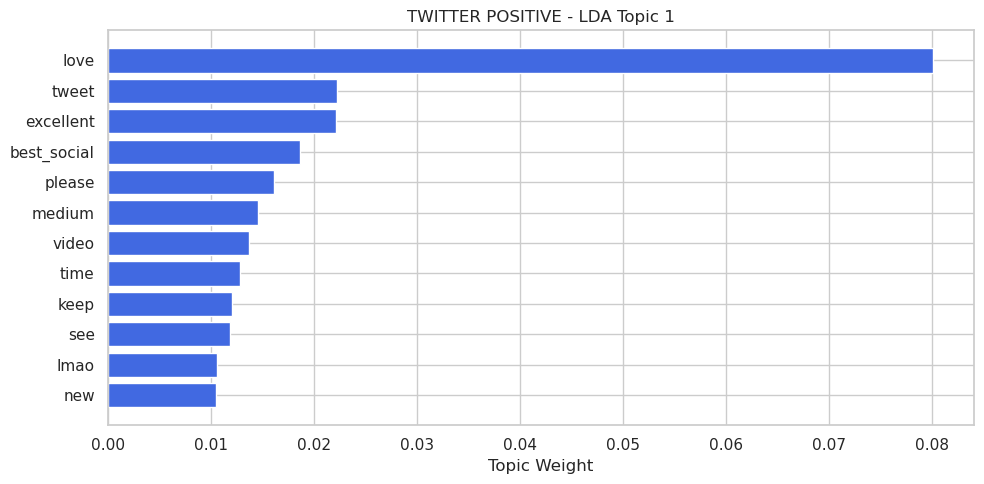

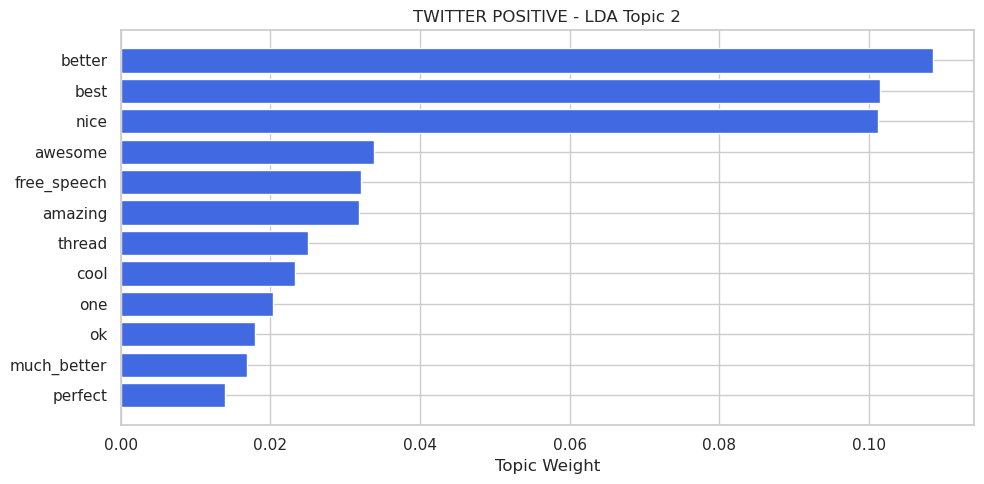

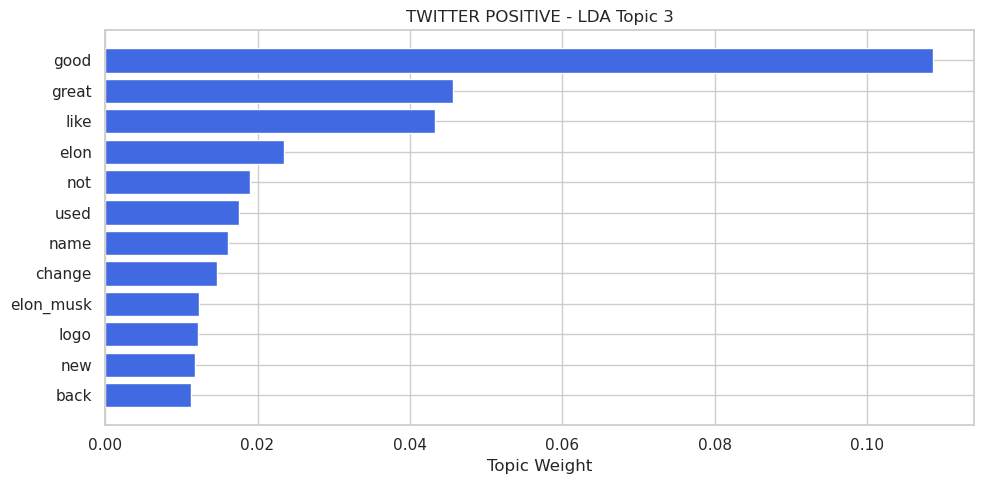


--- VISUALIZING LDA TOPICS: TWITTER NEUTRAL ---


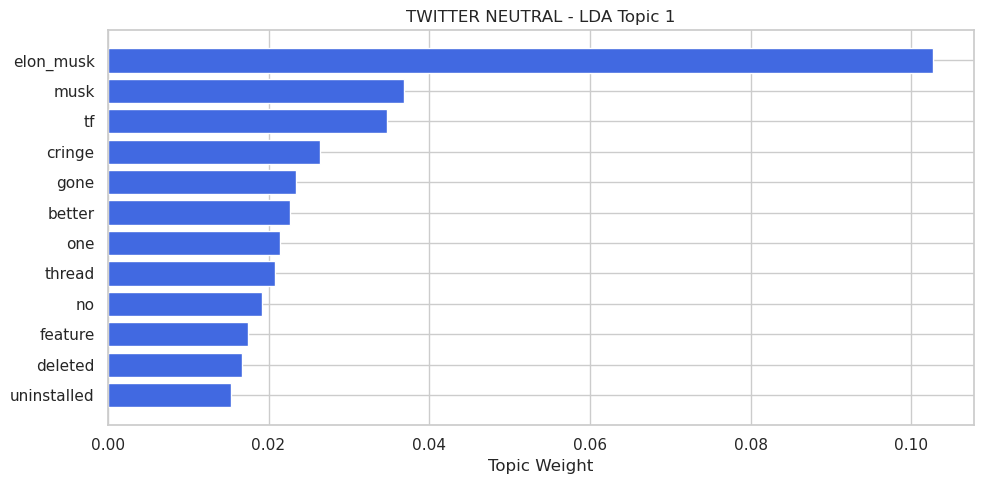

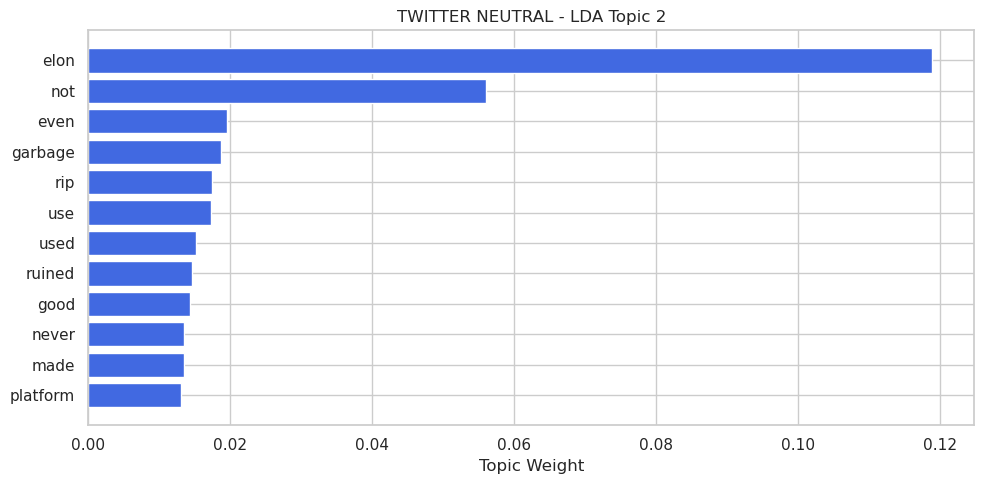

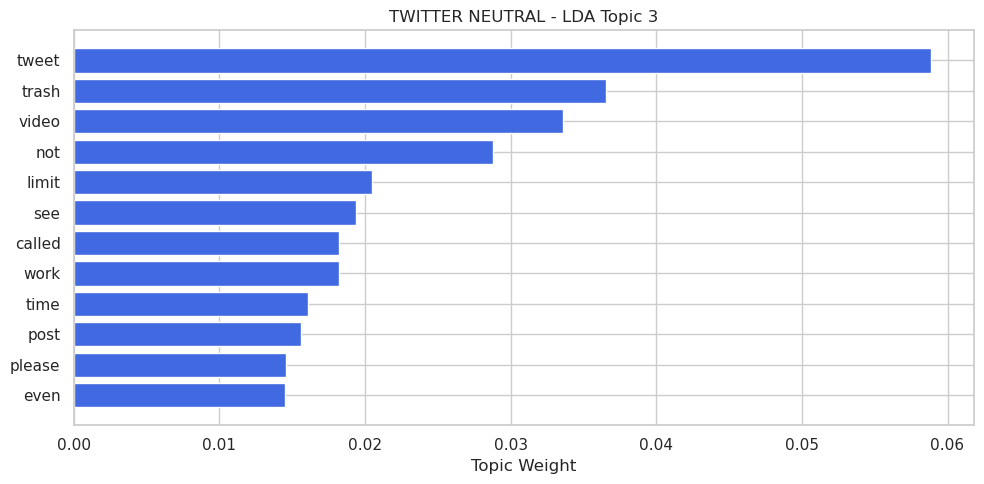

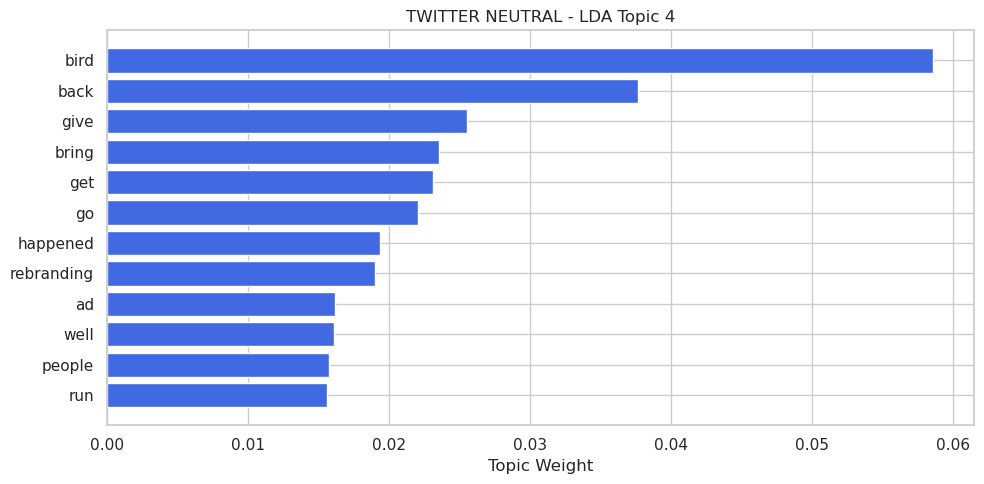

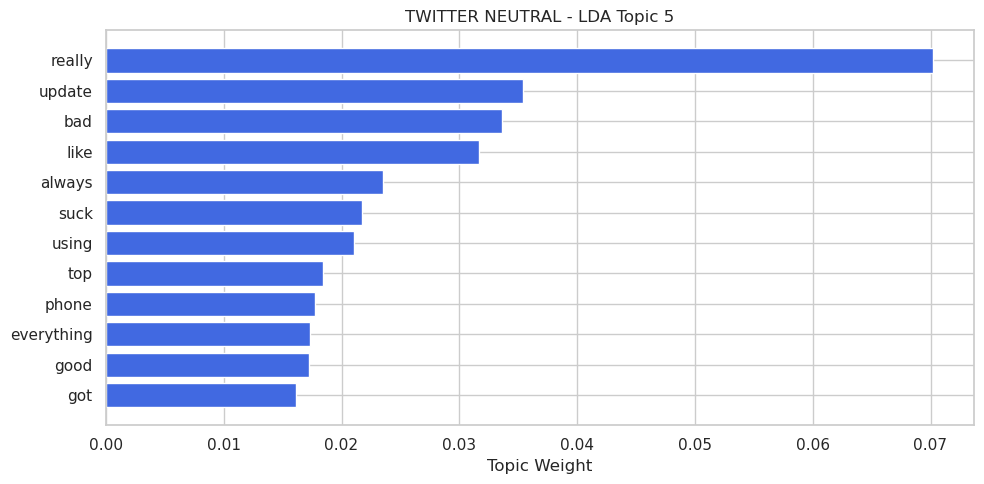

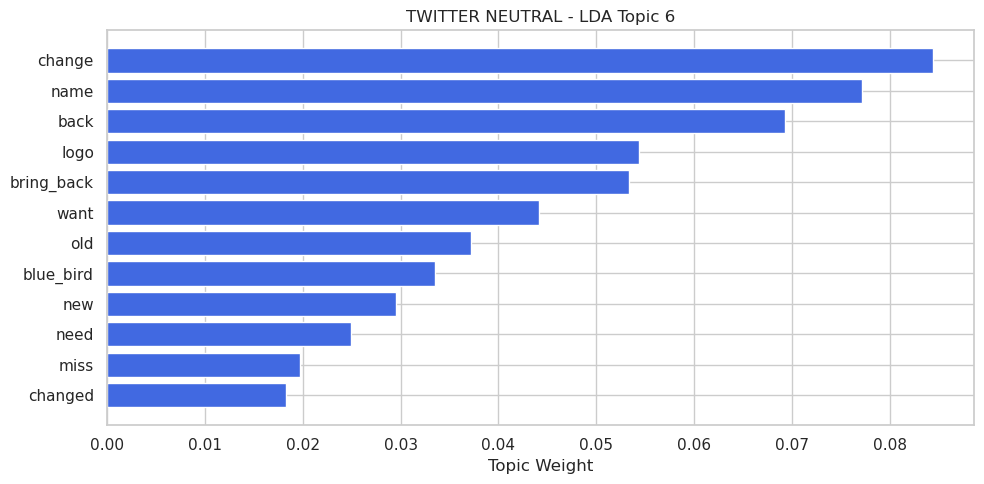


--- VISUALIZING LDA TOPICS: TWITTER NEGATIVE ---


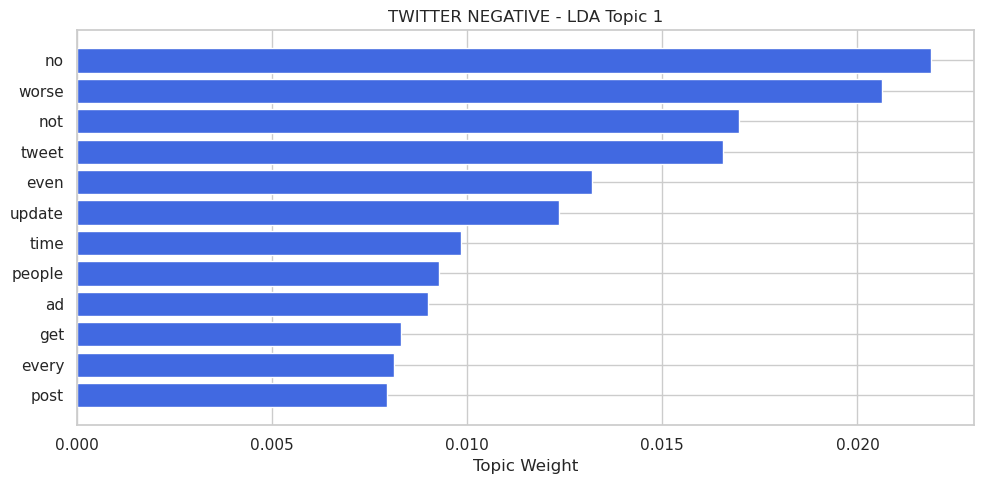

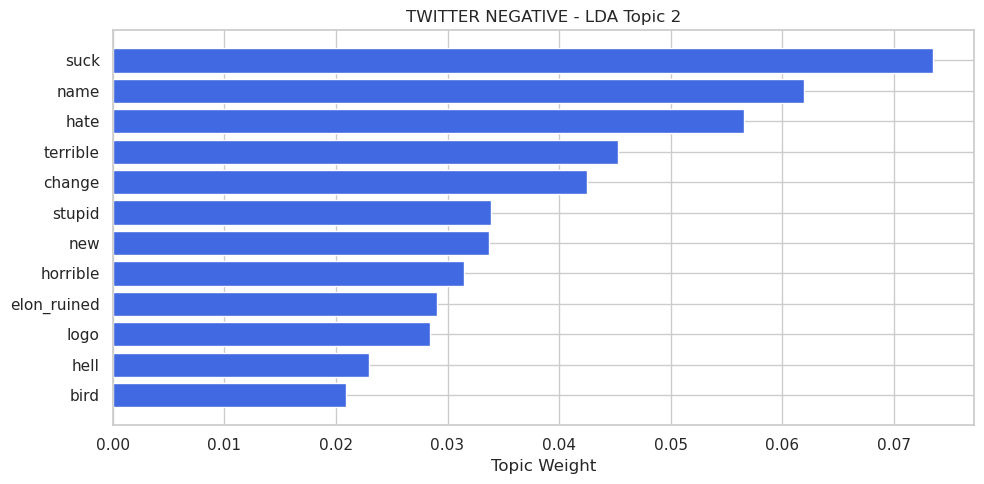

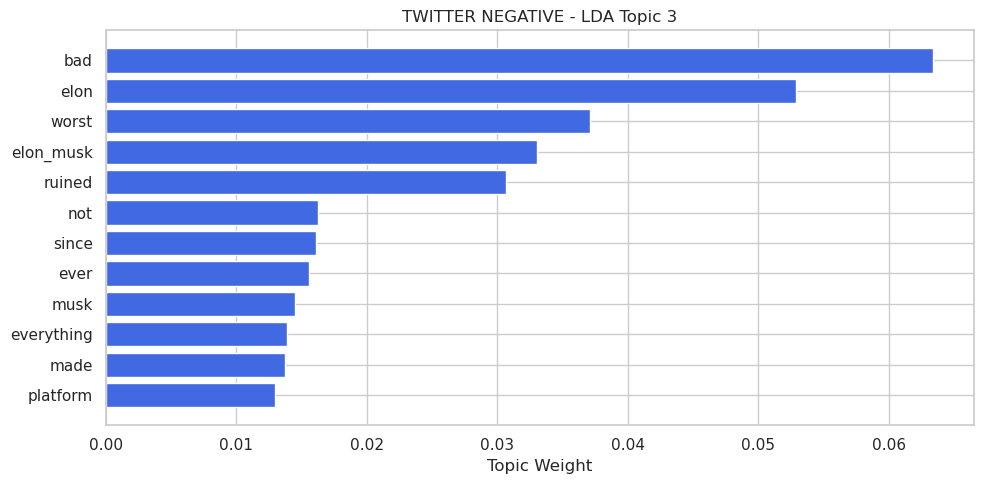

In [194]:


print("\n===== TWITTER POSITIVE TOPICS =====")
lda_pos_twitter = run_lda_block(twitter_pos)

print("\n===== TWITTER NEUTRAL TOPICS =====")
lda_neu_twitter = run_lda_block(twitter_neu)

print("\n===== TWITTER NEGATIVE TOPICS =====")
lda_neg_twitter = run_lda_block(twitter_neg)

visualize_lda_block(lda_pos_twitter, "Twitter Positive")
visualize_lda_block(lda_neu_twitter, "Twitter Neutral")
visualize_lda_block(lda_neg_twitter, "Twitter Negative")


**Overall Summary**

- Positive reviews: Users express favorable impressions, highlight improvements, and appreciate specific features or platform behavior.

- Neutral reviews: Comments focus on platform changes, updates, and general functionality, often mentioning rebranding or feature adjustments without strong emotion.

- Negative reviews: Users express dissatisfaction with updates, rebranding decisions, and limits, frequently criticizing how recent changes have affected the platform experience.

-------

**Positive Sentiment Analysis**

Best model: k = 3 topics — Coherence = 0.4780

**1. General Enthusiasm & Enjoyment** - *love, excellent, best_social, video, keep, lmao*

Users express overall enjoyment of the platform, praising content, interactions, and general experience.

**2. Positive Comparisons & Improvements** - *better, awesome, free_speech, amazing, cool, perfect*

Some reviewers highlight improvements and features they view favorably, including comments about free speech and comparative advantages.

**3. Satisfaction With Functionality or Changes** - *good, great, like, elon, name, change, logo*

Comments reflect satisfaction with how the platform works, including mentions of changes or updates viewed positively.

**Insight:**
Positive reviews tend to show approval toward platform performance, perceived improvements, and general enjoyment of using the app.

-------

**Neutral Sentiment Analysis**

Best model: k = 6 topics — Coherence = 0.4553

**1. Commentary on Leadership & Features** - *elon_musk, cringe, deleted, feature, uninstalled*

Users neutrally discuss leadership decisions, feature removals, or changes without strong positive or negative tone.

**2. General Observations About Platform Quality** - *elon, use, ruined, platform, anymore*

Matter-of-fact comments about how the platform behaves, often referencing performance or design changes.

**3. Practical Notes on Functionality** - *tweet, trash, video, limit, see, update*

Mentions of tweet limits, video behavior, or posting features presented neutrally.

**4. Rebranding & Logo Discussions** - * bird, back, bring, rebranding, toxic*

Users note the logo/name shift and its effects without clearly positive or negative sentiment.

**5. Comments on Updates & Usability** - *update, top, phone, everything, new*

Statements about app updates and usability, presented without strong emotion.

**6. Logo/Name Change Mentions** - *change, name, old, logo, bird, miss*

Neutral reactions to logo or name changes, often referencing the old design.

**Insight:**
Neutral comments primarily revolve around rebranding, updates, and general functionality, reflecting observations rather than emotional responses.

-------

**Negative Sentiment Analysis**

Best model: k = 3 topics — Coherence = 0.4849

**1. Complaints About Usability & Updates** - *no, worse, not, update, limit, post, people*

Users criticize issues such as tweet limits, posts not loading, or general disruptions caused by recent updates.

**2. Strong Disapproval of Rebranding** - *suck, name, terrible, logo, bird, ugly, back*

Many negative reviews express frustration with the new name and logo, often describing them as unattractive or unnecessary.

**3. Leadership-Focused Criticism** - *bad, elon, worst, ruined, musk, awful*

Users associate platform decline with leadership decisions and express concerns about the direction of the platform.

**Insight:**
Negative sentiment centers on update-related frustrations, dissatisfaction with the rebranding, and criticism aimed toward leadership decisions.

[REMOVE LATER]
##### On training data LDA performs well with coherence scores of 0.46 for Positive topics, 0.46 for Neutral Topics and 0.51 for Negative Topics
##### On an average LDA performs decently on all sentiments with average coherence score of 47.6

##### As per few reviews that we checked for the negative sentiment, LDA captures topics pretty well, which we could summarize as:
Many users companing about post limit, new update which has given few glitches in videos, bad experience due to bots and few services being available only for paid users, change of logo and sudden suspension of accounts

## Topic Modelling 2 NMF (using sentiment - pos, neu, neg)

In [195]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel

def run_nmf(docs_df):
    docs_bigrams = prepare_tm_texts(docs_df)
    docs_text = [" ".join(doc) for doc in docs_bigrams]

    tfidf_vectorizer = TfidfVectorizer(
        max_df=0.95,
        min_df=10,
        ngram_range=(1, 1),
    )

    tfidf = tfidf_vectorizer.fit_transform(docs_text)
    feature_names = tfidf_vectorizer.get_feature_names_out()

    dictionary = Dictionary(docs_bigrams)
    dictionary.filter_extremes(no_below=10, no_above=0.5)

    topic_range = range(3, 10)
    coherence_scores = {}

    for k in topic_range:
        nmf_model = NMF(
            n_components=k,
            random_state=42,
            init="nndsvda",
            max_iter=2000
        )
        
        W = nmf_model.fit_transform(tfidf)
        H = nmf_model.components_

        top_words = []
        for topic in H:
            idxs = topic.argsort()[-20:]
            top_words.append([feature_names[i] for i in idxs])

        coherence_model = CoherenceModel(
            topics=top_words,
            texts=docs_bigrams,
            dictionary=dictionary,
            coherence='c_v'
        )

        coherence = coherence_model.get_coherence()
        coherence_scores[k] = coherence
        print(f"k={k} Coherence={coherence:.4f}")

    best_k = max(coherence_scores, key=coherence_scores.get)
    print("\nBest number of NMF topics =", best_k)

    final_nmf = NMF(
        n_components=best_k,
        random_state=42,
        init="nndsvda",
        max_iter=400
    )

    W_final = final_nmf.fit_transform(tfidf)
    H_final = final_nmf.components_

    print("\n--- FINAL NMF TOPIC WORDS ---\n")
    for idx, topic in enumerate(H_final):
        indices = topic.argsort()[-15:]
        words = [feature_names[i] for i in indices]
        print(f"TOPIC {idx+1}: {', '.join(words)}")

    return final_nmf, feature_names



def run_nmf_block(df_input):
    print("\n===== RUNNING NMF BLOCK =====")
    return run_nmf(df_input)
# nmf_pos, pos_feats = run_nmf(threads_pos)

# print("\n===== NMF THREADS NEUTRAL =====")
# nmf_neu, neu_feats = run_nmf(threads_neu)

# print("\n===== NMF THREADS NEGATIVE =====")
# nmf_neg, neg_feats = run_nmf(threads_neg)



### Visulaizing the Topics in pos, neu, neg (NMF)

In [196]:
import matplotlib.pyplot as plt

def plot_topic(words, weights, title):
    plt.figure(figsize=(10, 5))
    plt.barh(words[::-1], weights[::-1], color='royalblue')
    plt.title(title)
    plt.xlabel("Topic Weight")
    plt.tight_layout()
    plt.show()

def visualize_nmf_topics(nmf_model, feature_names, sentiment_label):
    print(f"\n--- VISUALIZING NMF TOPICS: {sentiment_label.upper()} ---")
    
    H = nmf_model.components_

    for idx, topic in enumerate(H):
        top_idx = topic.argsort()[-15:][::-1]
        words = [feature_names[i] for i in top_idx]
        weights = [topic[i] for i in top_idx]

        title = f"{sentiment_label.upper()} - NMF Topic {idx+1}"
        plot_topic(words, weights, title)

def visualize_nmf_block(nmf_model, feature_names, sentiment_label):
    visualize_nmf_topics(nmf_model, feature_names, sentiment_label)


# visualize_nmf_topics(nmf_pos, pos_feats, "Positive")
# visualize_nmf_topics(nmf_neu, neu_feats, "Neutral")
# visualize_nmf_topics(nmf_neg, neg_feats, "Negative")


## NMF Threads Analysis


===== NMF THREADS POSITIVE =====

===== RUNNING NMF BLOCK =====
k=3 Coherence=0.5009
k=4 Coherence=0.5314
k=5 Coherence=0.5307
k=6 Coherence=0.5460
k=7 Coherence=0.5341
k=8 Coherence=0.5158
k=9 Coherence=0.5043

Best number of NMF topics = 6

--- FINAL NMF TOPIC WORDS ---

TOPIC 1: new, think, pretty, job, use, feature, need, aap, twitter, instagram, like, really, one, far, good
TOPIC 2: see, download, ui, platform, feature, new, twitter, instagram, work, really, like, one, wow, aap, nice
TOPIC 3: use, need, facebook, alternative, feature, not, copy, think, much_better, far, instagram, way, like, twitter, better
TOPIC 4: facebook, thing, far, new, social, use, feature, world, aap, platform, instagram, social_medium, one, twitter, best
TOPIC 5: work, not, would, one, job, alternative, new, start, really, need, feature, far, instagram, like, great
TOPIC 6: post, would, much, cool, super, new, feature, facebook, far, really, wow, instagram, like, amazing, love

===== NMF THREADS NEUTRAL 

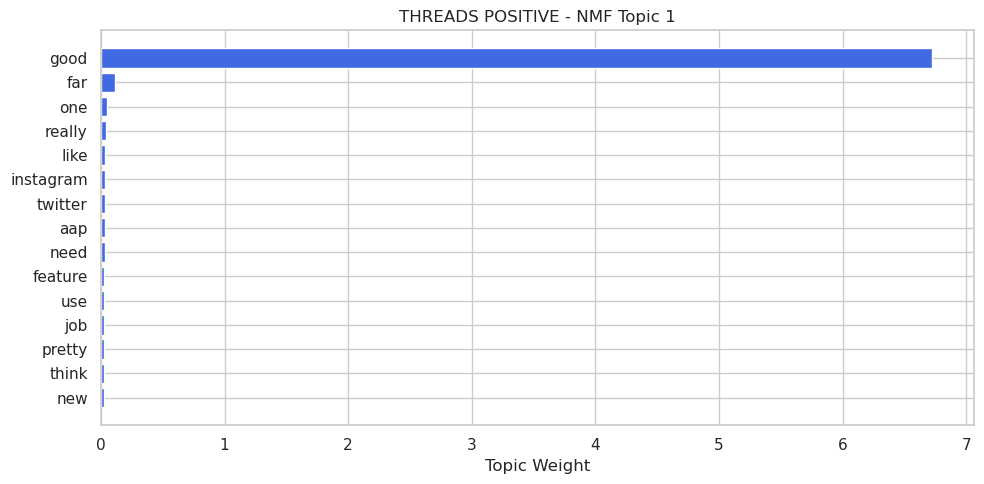

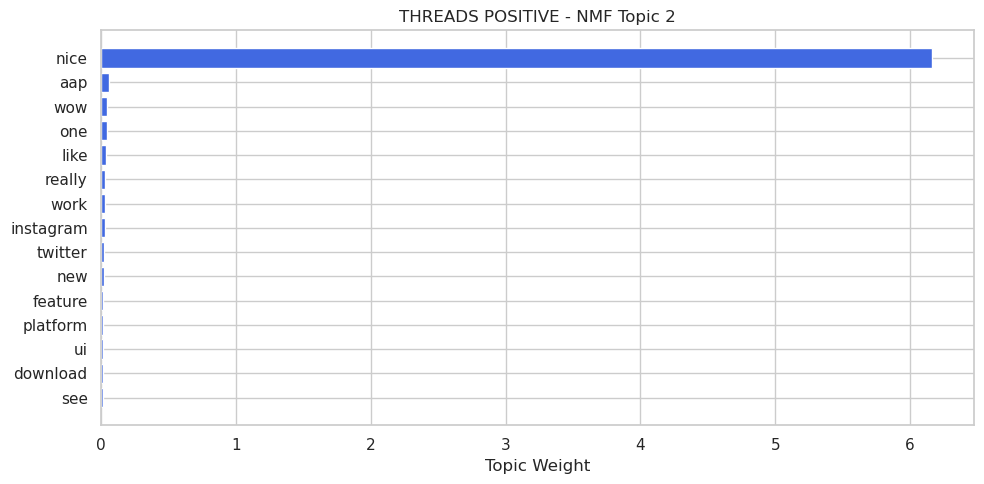

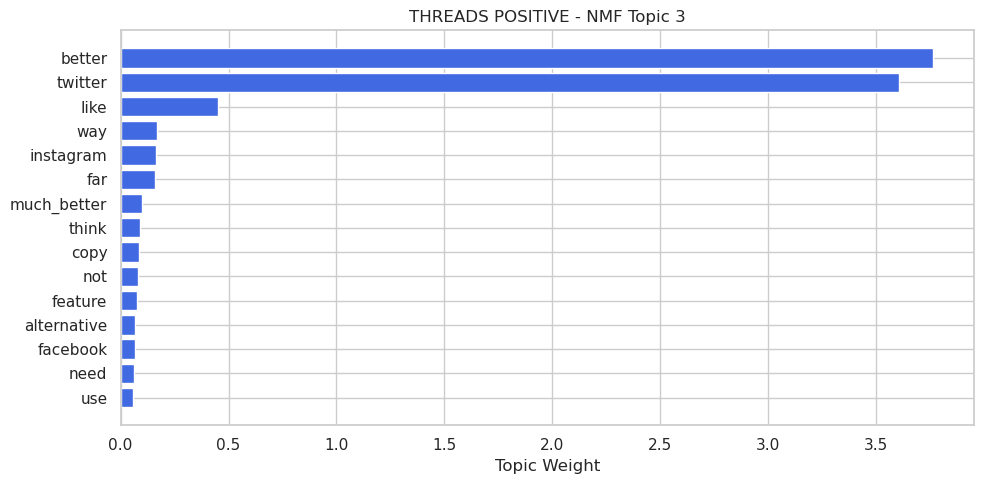

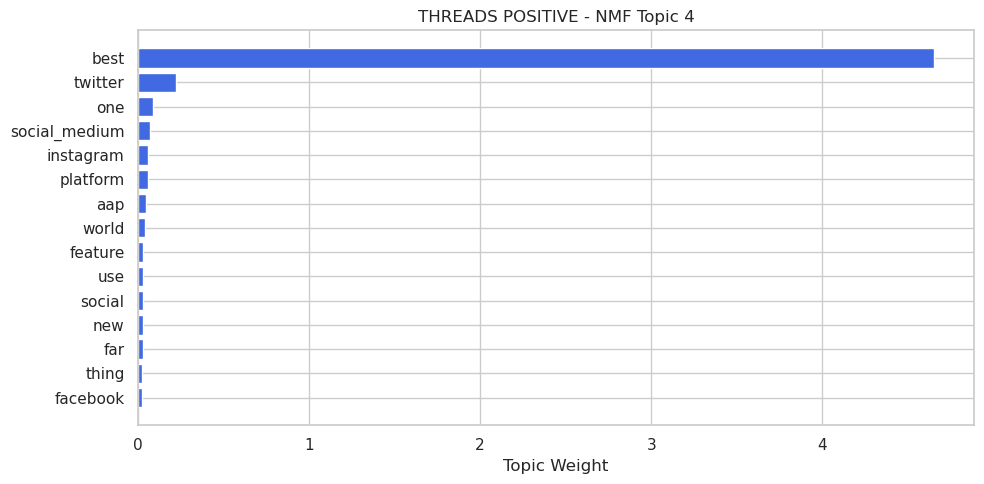

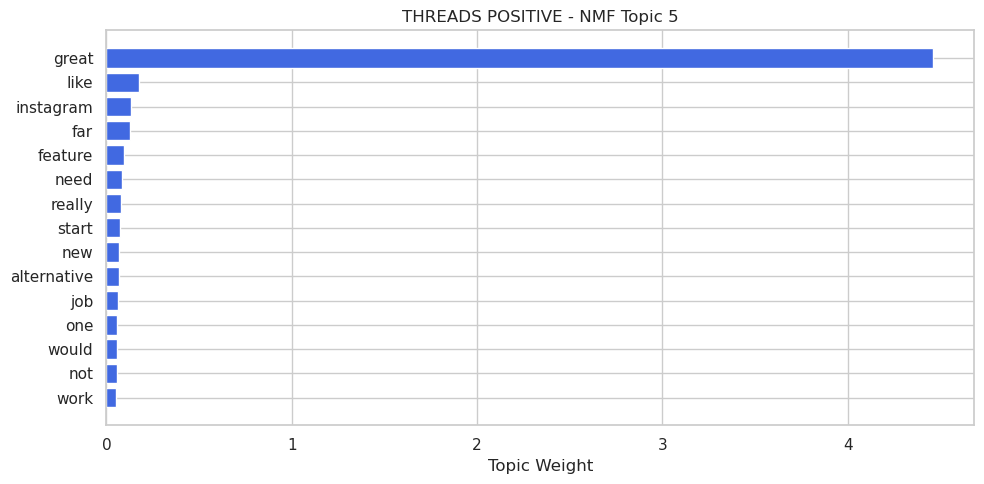

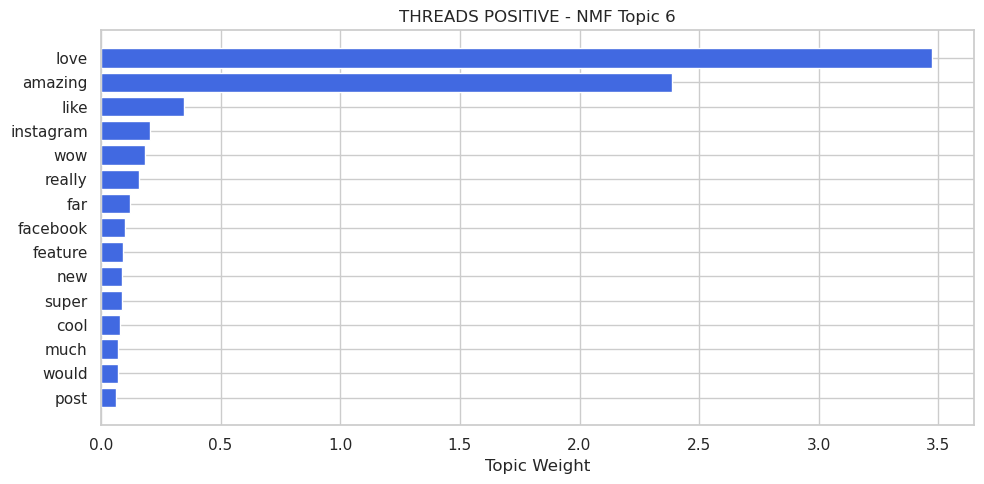


--- VISUALIZING NMF TOPICS: THREADS NEUTRAL ---


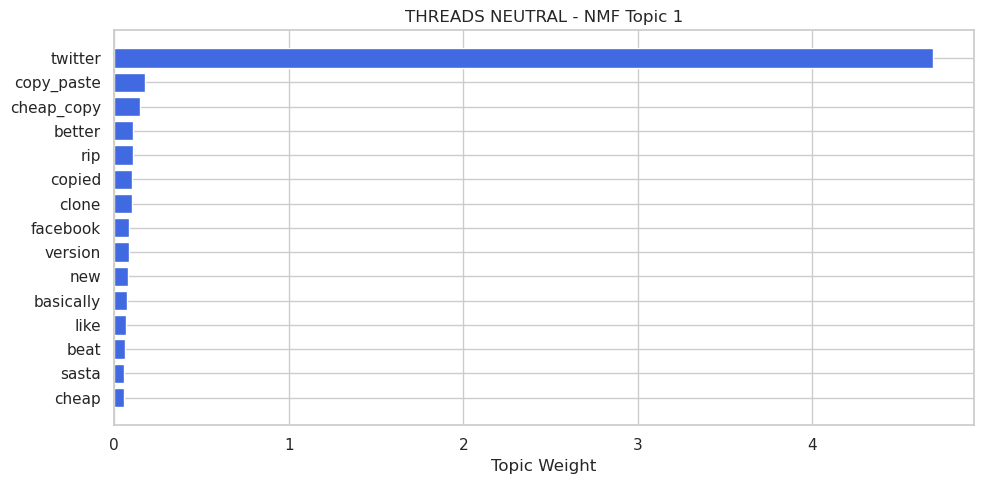

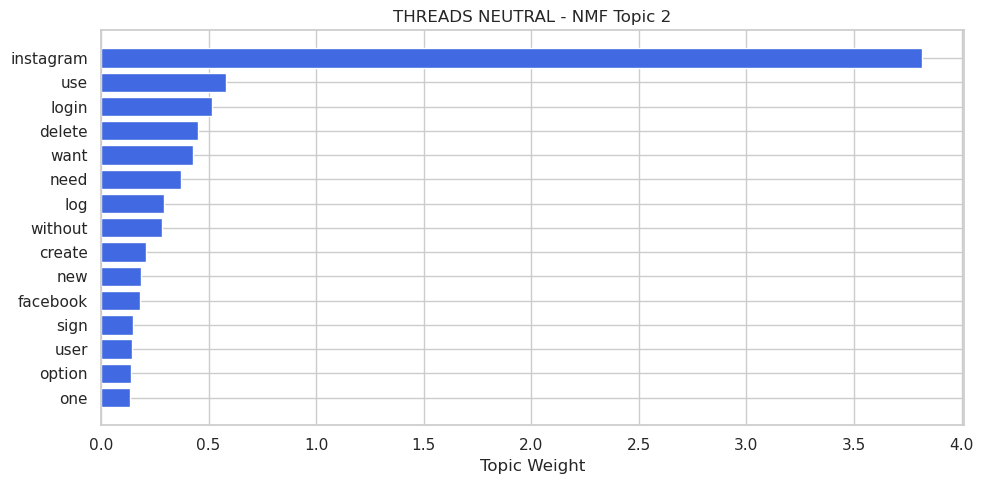

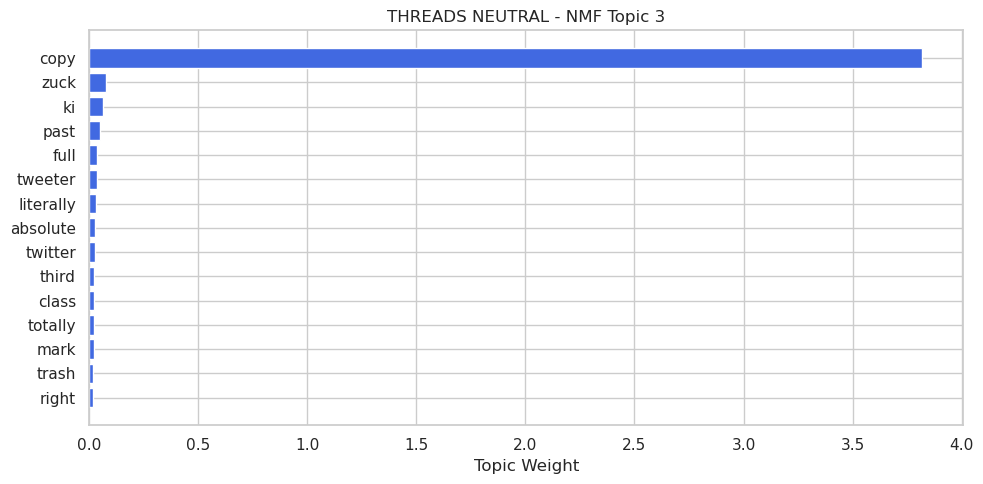

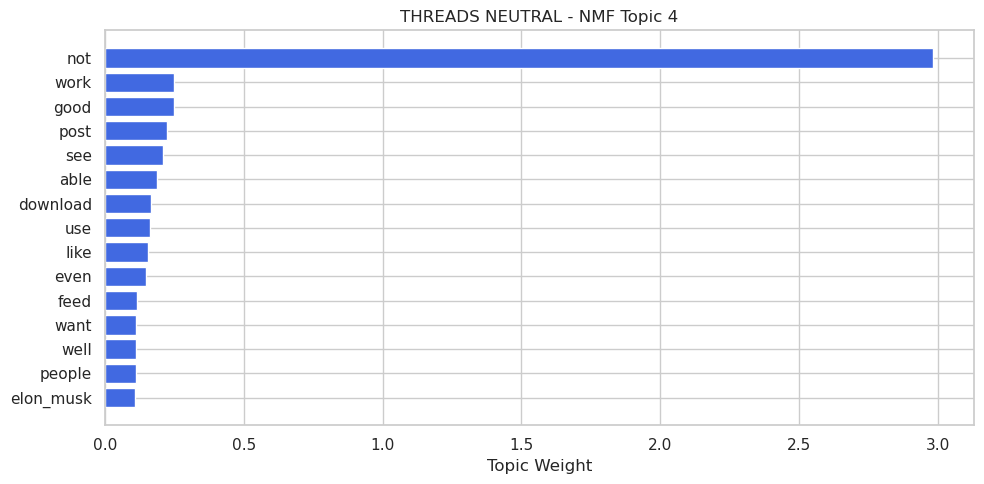

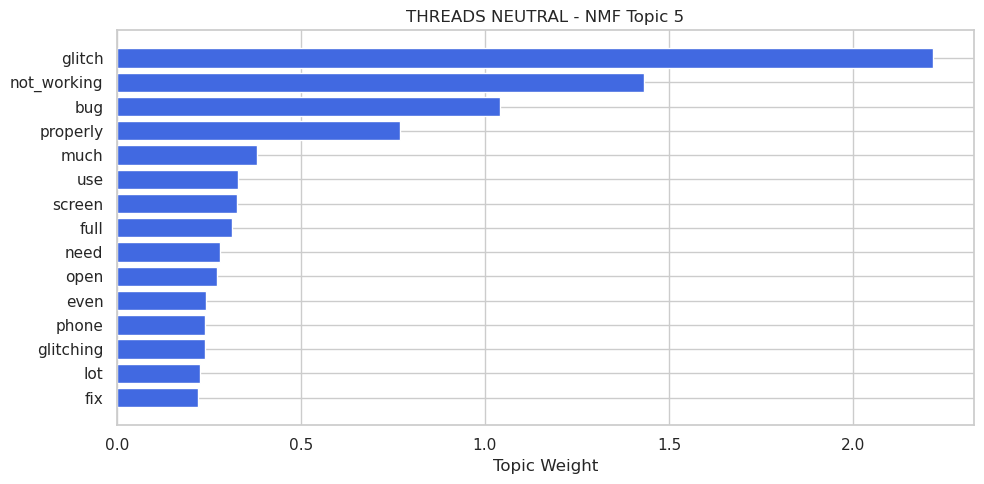

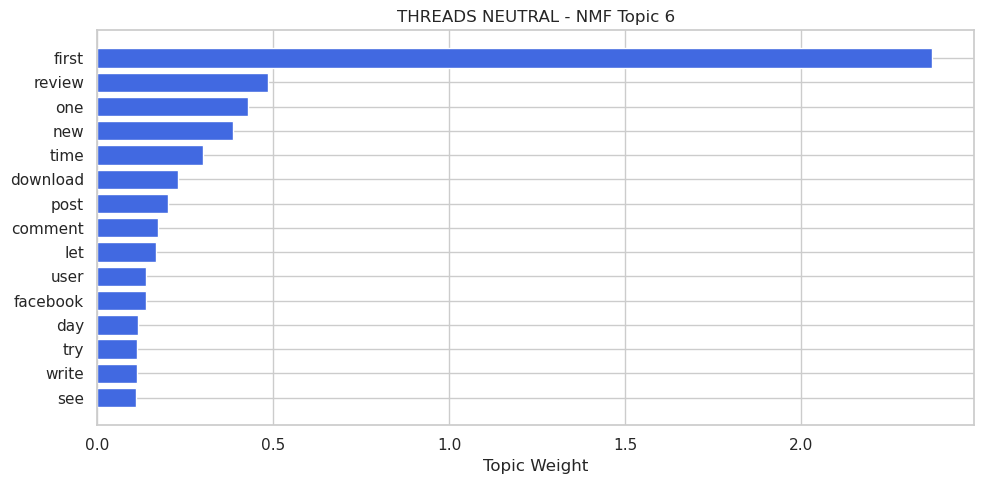


--- VISUALIZING NMF TOPICS: THREADS NEGATIVE ---


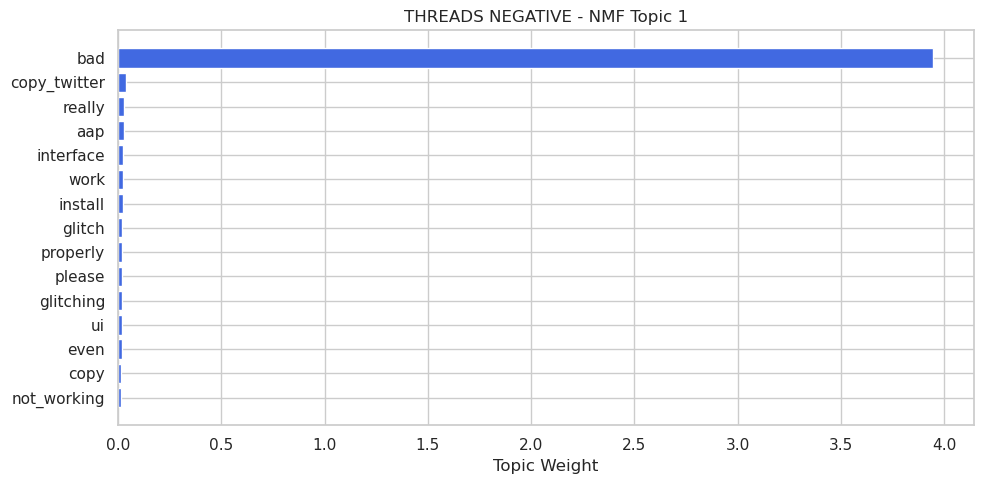

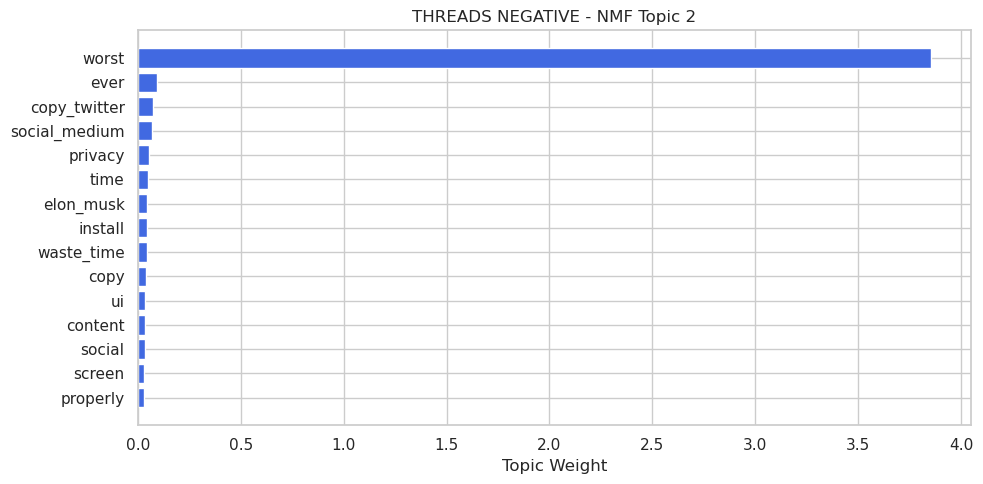

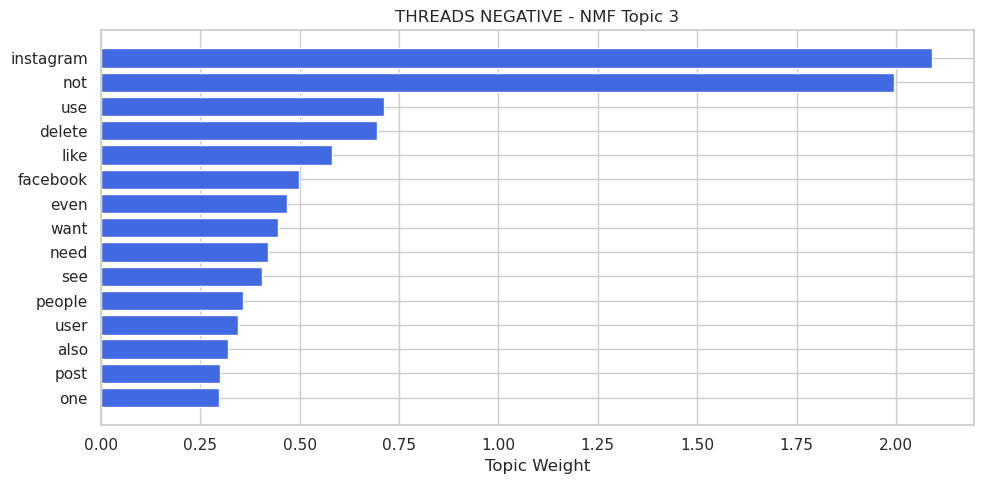

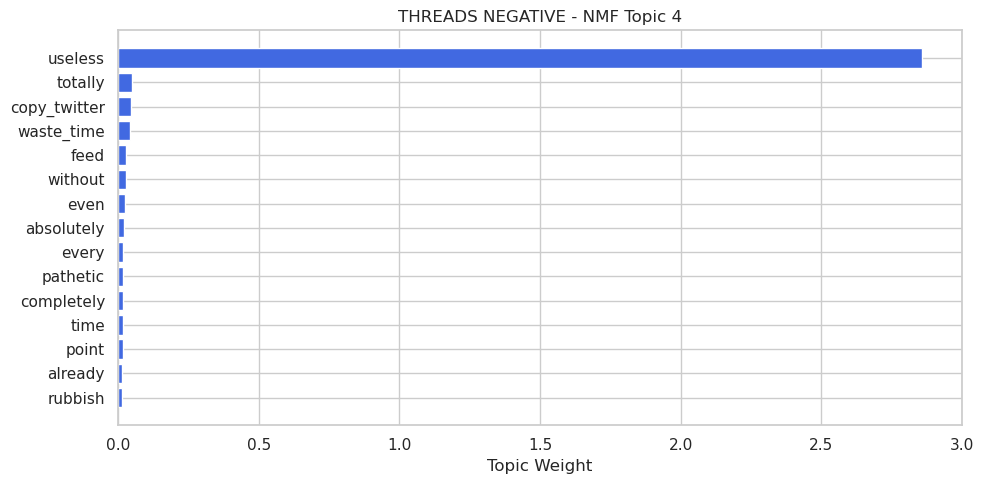

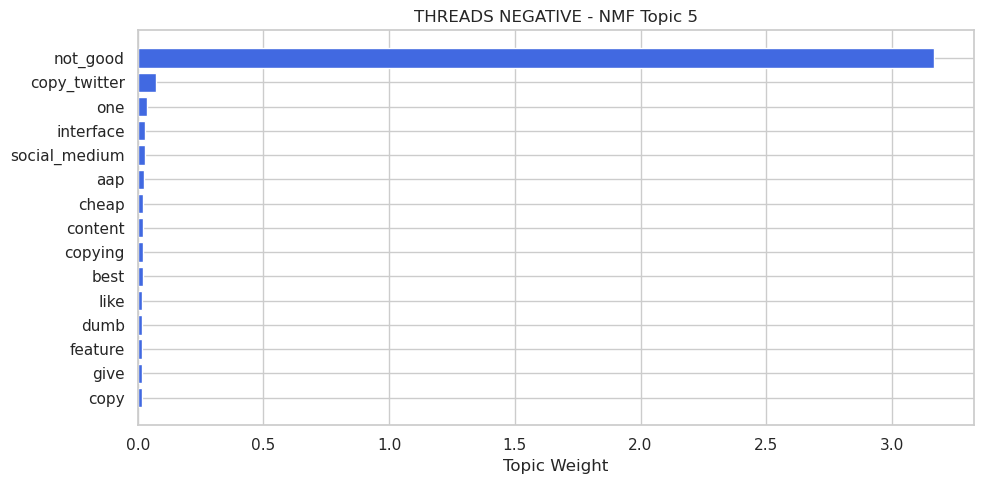

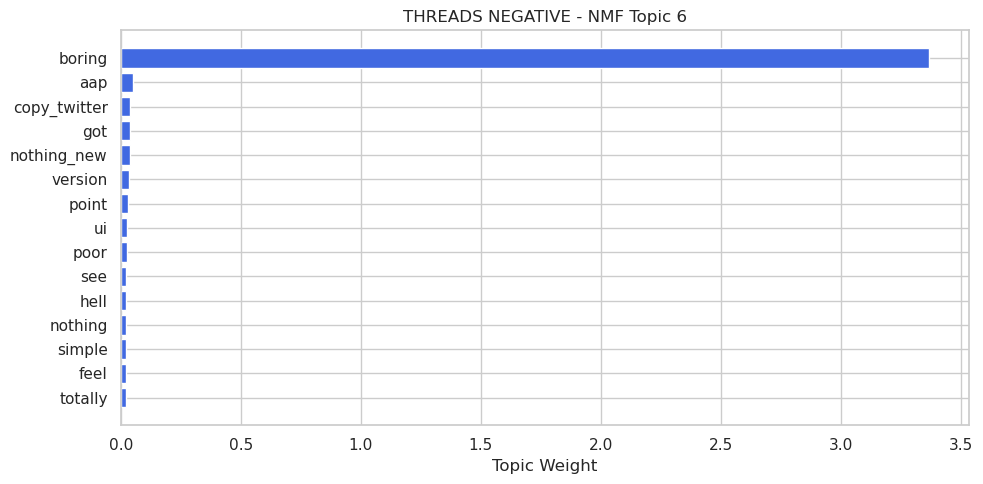

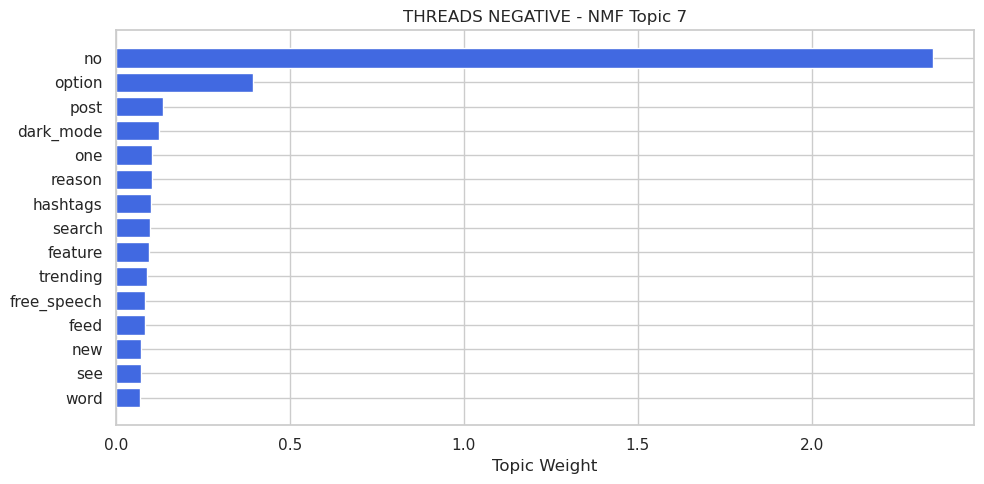

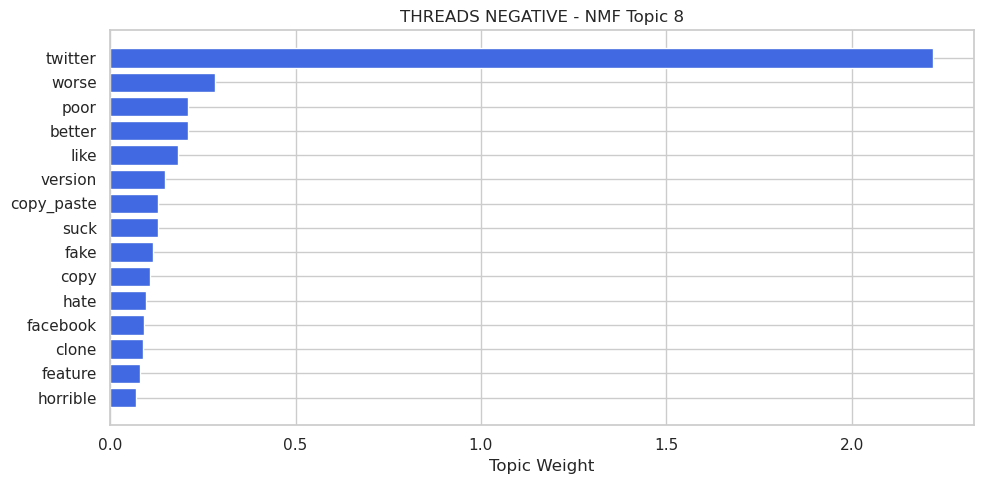

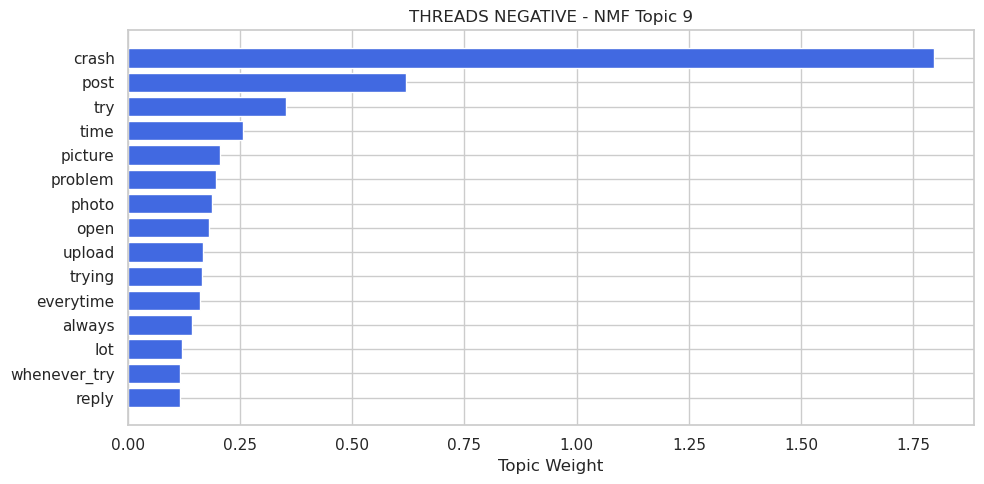

In [197]:
print("\n===== NMF THREADS POSITIVE =====")
nmf_pos, pos_feats = run_nmf_block(threads_pos)

print("\n===== NMF THREADS NEUTRAL =====")
nmf_neu, neu_feats = run_nmf_block(threads_neu)

print("\n===== NMF THREADS NEGATIVE =====")
nmf_neg, neg_feats = run_nmf_block(threads_neg)

visualize_nmf_block(nmf_pos, pos_feats, "Threads Positive")
visualize_nmf_block(nmf_neu, neu_feats, "Threads Neutral")
visualize_nmf_block(nmf_neg, neg_feats, "Threads Negative")


**Overall Summary:**
- Positive reviews: Users describe generally positive impressions of the app and note that certain features work well, while also mentioning additional functions they would like to see.

- Neutral reviews: Comments focus on comparisons with other platforms, account or login actions, and practical notes about usage, interface behavior, or minor technical issues.

- Negative reviews: Users report problems related to app performance, glitches, feed behavior, privacy, and copying concerns, with several comments noting limited functionality or instability. Negative sentiment shows more topic variety because NMF identified a wider range of issues (k = 9 topics).

-------

**Positive Sentiment Analysis**

Best model: k = 6 topics — Coherence = 0.5460

**1. General Impressions** — *new, think, use, feature, need*

Users share basic positive impressions and mention wanted features.

**2. UI & Platform Notes** — *see, ui, platform, download, work*

Comments reference the interface and general platform behavior.

**3. Comparisons to Other Apps** — *facebook, instagram, twitter, alternative, copy*

Neutral comparisons with other social platforms.

**4. Social Context** — *facebook, social, platform, world, social_medium*

Mentions relate Threads to the wider Meta ecosystem.

**5. Functional Notes** — *work, job, start, need, feature*

Users describe working features and areas needing improvement.

**6. Light Positive Reactions**— *cool, amazing, love, super, wow*

Short positive expressions paired with routine observations.

**Insight:**
Positive topics reflect basic satisfaction, platform observations, comparisons with competitors, and moderate feature requests.

-------

**Neutral Sentiment Analysis**

Best model: k = 6 topics — Coherence ≈ 0.57

**1. Copying Discussions** — *cheap, clone, copied, version, twitter*

Users neutrally point out similarities with other apps.

**2. Account & Login Notes** — *option, user, sign, create, login*

Comments describe account setup and login steps.

**3. Competitor Commentary** — *mark, twitter, tweeter, zuck, copy*

Neutral mentions involving competitors or platform leaders.

**4. Feed & Usage Observations** — *feed, people, see, post, work*

General comments on content visibility and usage patterns.

**5. Technical Issues** — *glitching, screen, properly, bug, not_working*

Reports of minor technical issues expressed neutrally.

**6. Routine Usage Notes** — *write, try, comment, review, time*

Neutral descriptions of typical app interactions.

**Insight:**
Neutral topics cover similarities with other platforms, account actions, general usage, and minor issues without emotional tone.

-------

**Negative Sentiment Analysis**

Best model: k = 9 topics — Coherence ≈ 0.40

**1. App Not Working** — *not_working, glitch, ui, install, properly*

Users report unreliable functionality and inconsistent performance.

**2. UI & Privacy Concerns** — *screen, privacy, content, waste_time, worst*

Concerns include interface issues and privacy expectations.

**3. Missing Functions** — *post, see, need, delete, use*

Users highlight difficulties completing basic actions.

**4. Strong Dissatisfaction** — *rubbish, pointless, useless, waste_time, pathetic*

Direct negative reactions expressing frustration.

**5. Clone Concerns** — *copy, copying, cheap, dumb, copy_twitter*

Complaints about the app feeling too similar to competitors.

**6. Design & Experience** — *boring, poor, nothing_new, simple, version*

Critical comments about the design or originality.

**7. Feed & Search Issues** — *feed, trending, hashtags, search, option*

Users note problems with the feed algorithm or discovery features.

**8. Clone & Quality Issues** — *clone, fake, worse, twitter, poor*

Complaints involving quality and unfavorable comparisons.

**9. Technical Failures** — *trying, upload, post, crash, photo*

Reports of crashes, upload failures, or instability.

**Insight:**
Negative topics reflect issues with performance, missing features, feed visibility, design limitations, copying concerns, and technical instability.

## Twitter NMF Analysis


===== NMF TWITTER POSITIVE =====

===== RUNNING NMF BLOCK =====
k=3 Coherence=0.4199
k=4 Coherence=0.4367
k=5 Coherence=0.4573
k=6 Coherence=0.4487
k=7 Coherence=0.4323
k=8 Coherence=0.4409
k=9 Coherence=0.4353

Best number of NMF topics = 5

--- FINAL NMF TOPIC WORDS ---

TOPIC 1: thing, not, information, news, pretty, work, one, social_medium, far, really, elon, platform, like, used, good
TOPIC 2: people, thread, super, easy_use, aap, like, elon, update, name, platform, really, logo, experience, one, nice
TOPIC 3: awesome, new, like, free_speech, update, not, elon_musk, better, news, elon, platform, used, work, experience, great
TOPIC 4: still, experience, ever, better, name, free_speech, news, like, elon, thread, world, platform, one, elon_musk, best
TOPIC 5: thread, name, platform, much, used, excellent, not, elon_musk, free_speech, really, new, better, like, elon, love

===== NMF TWITTER NEUTRAL =====

===== RUNNING NMF BLOCK =====
k=3 Coherence=0.3881
k=4 Coherence=0.4540
k=5 Co

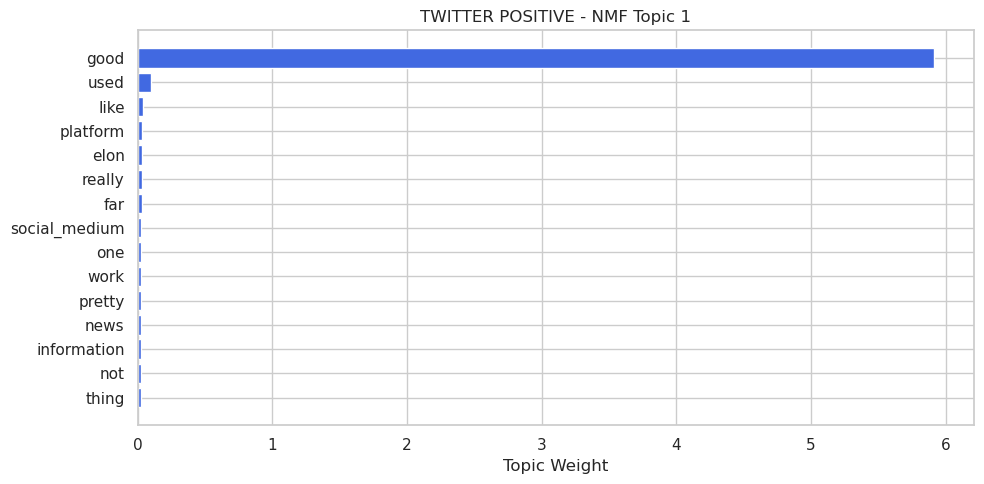

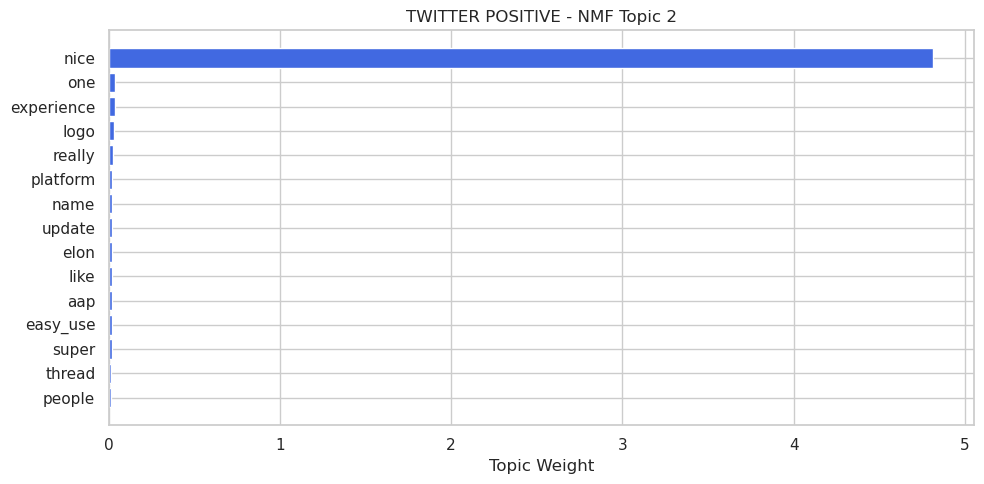

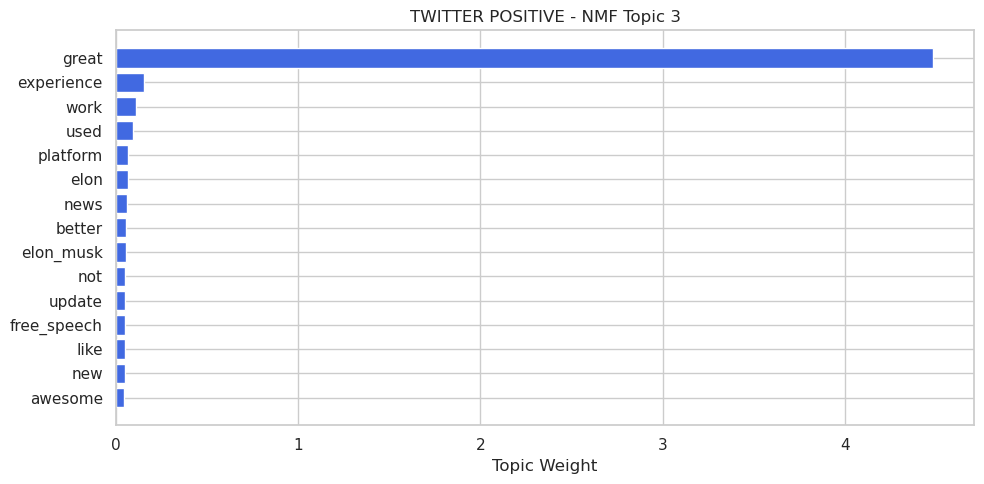

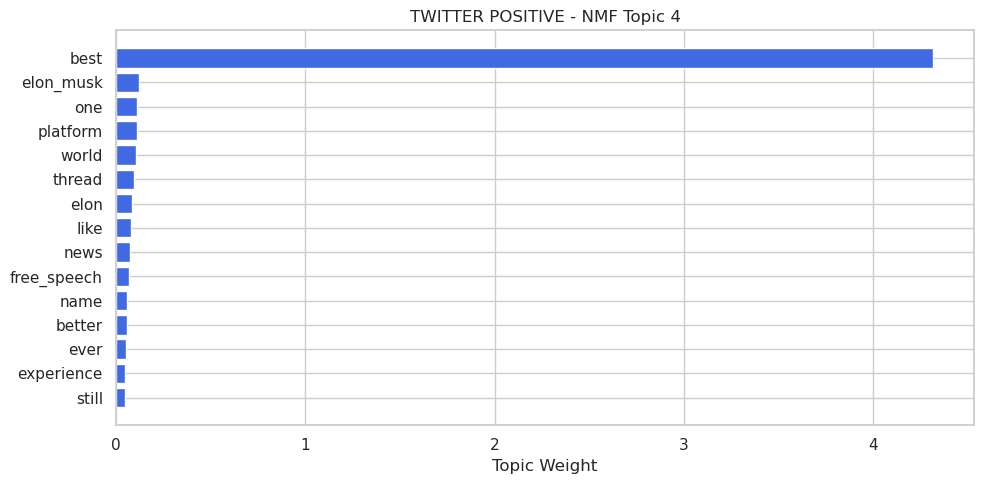

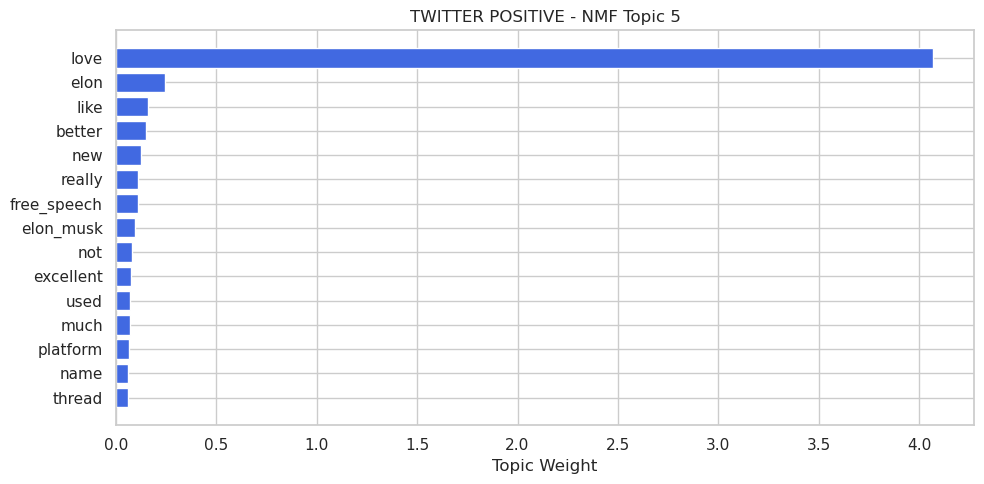


--- VISUALIZING NMF TOPICS: TWITTER NEUTRAL ---


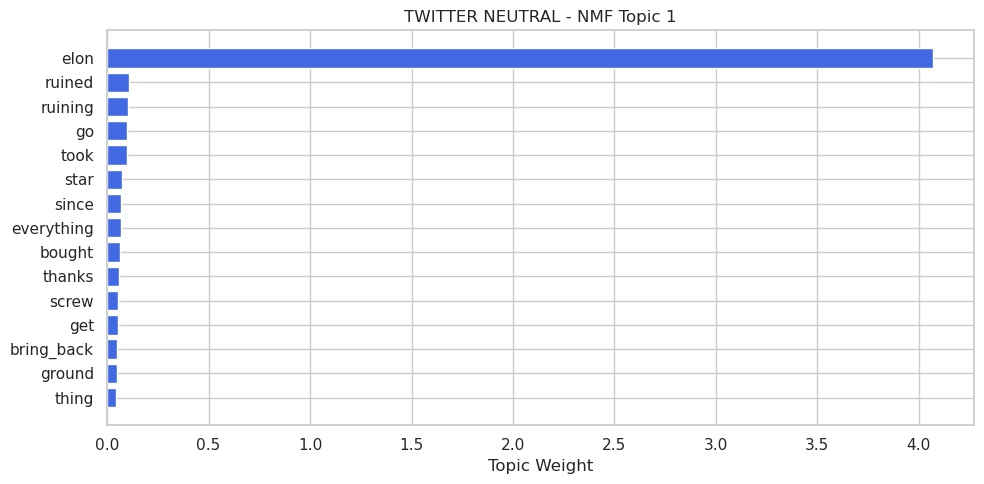

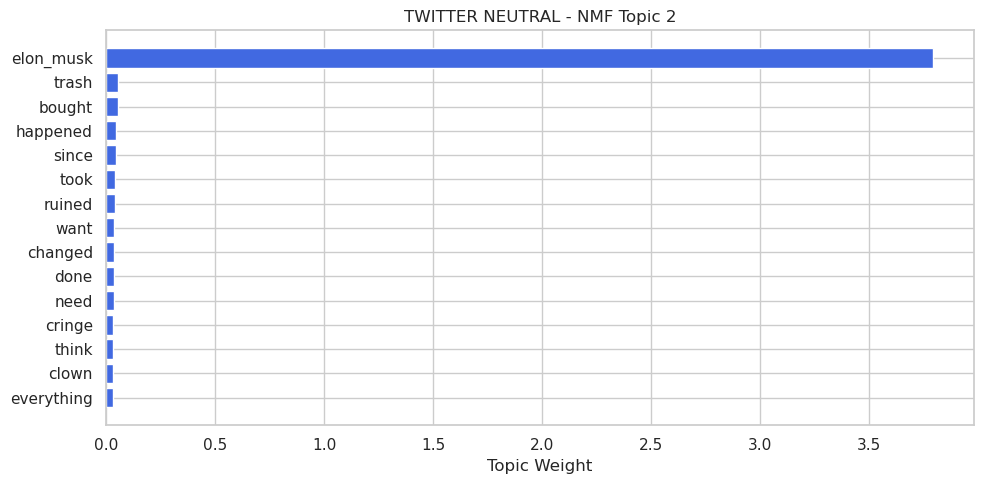

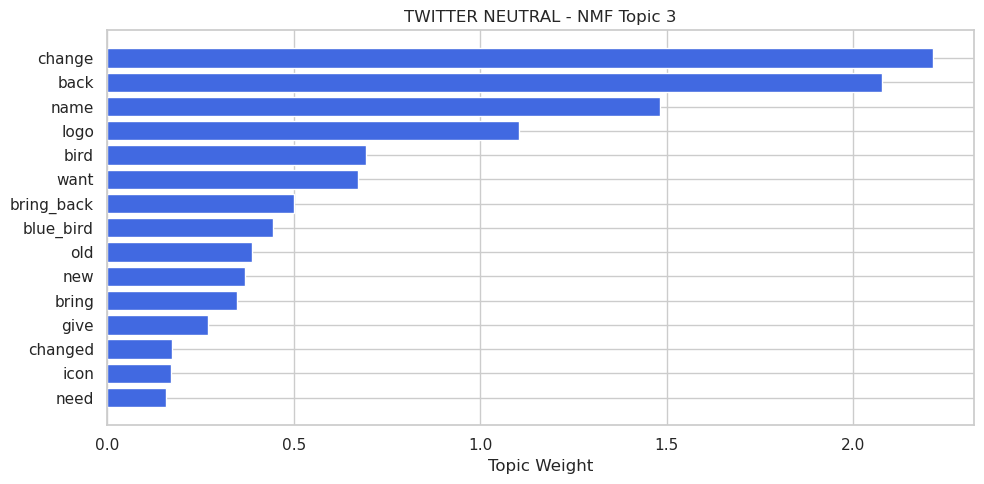

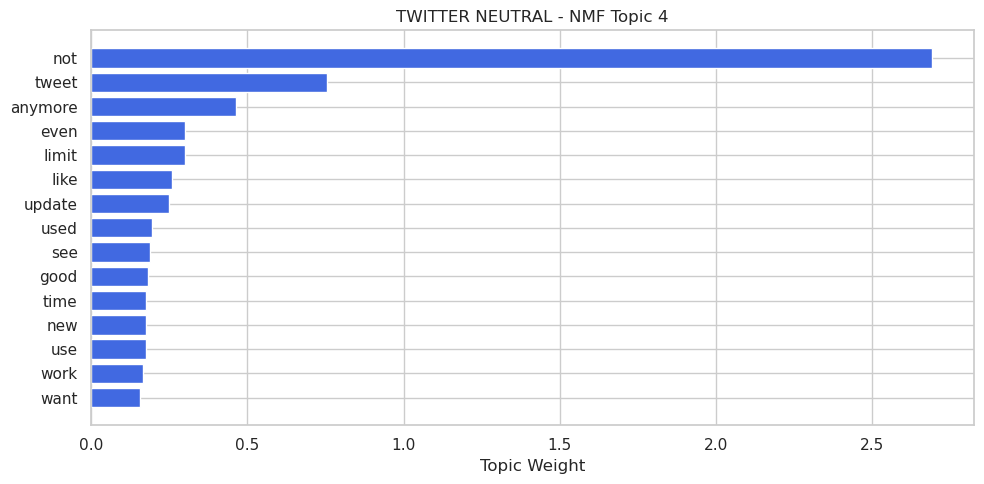


--- VISUALIZING NMF TOPICS: TWITTER NEGATIVE ---


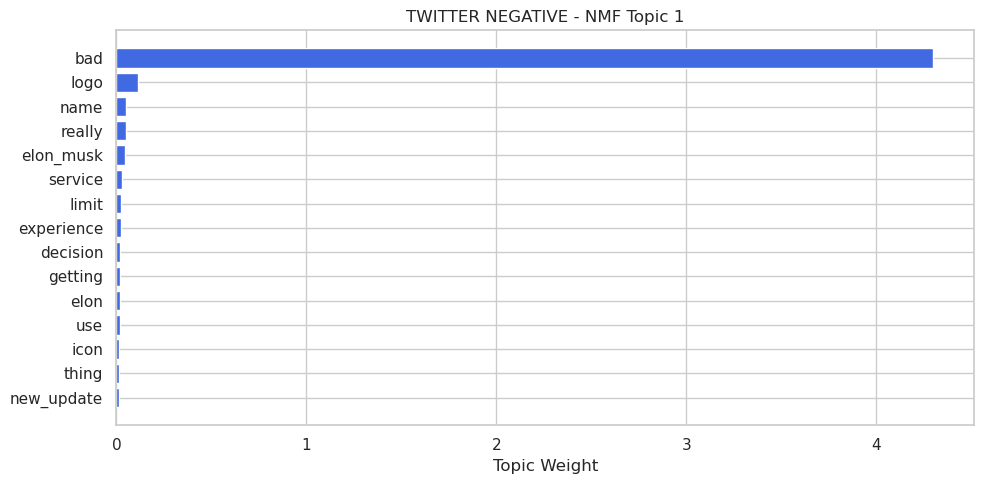

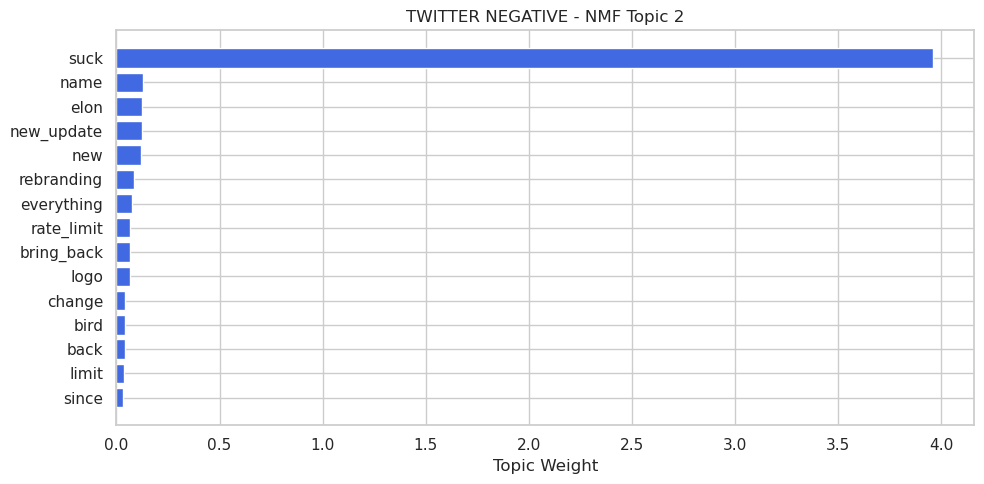

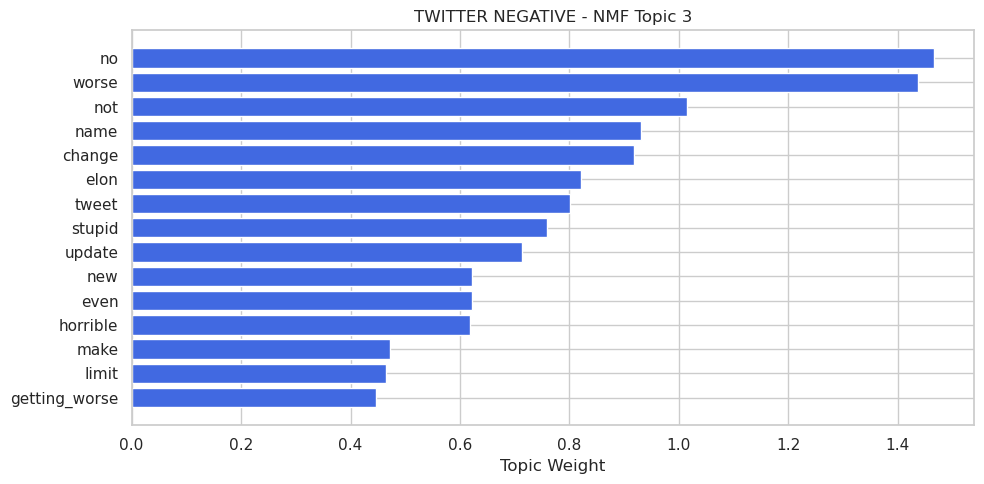

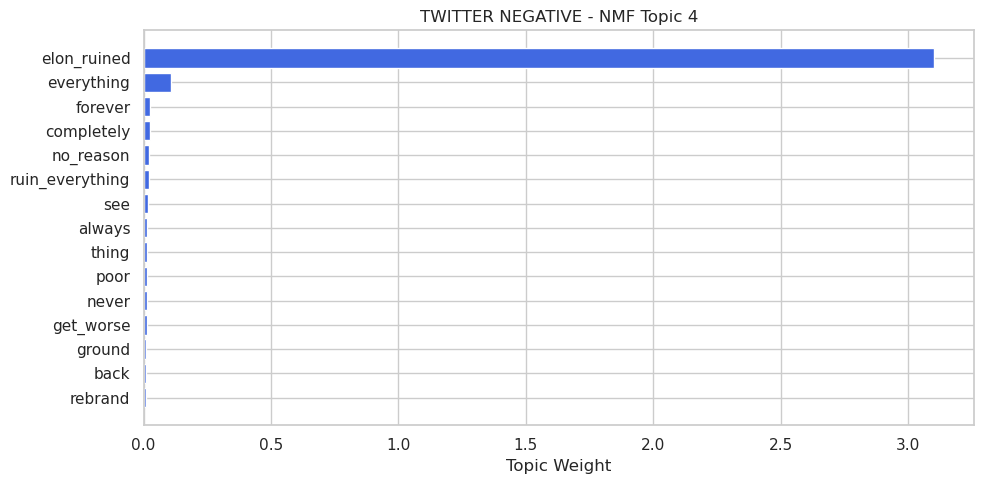

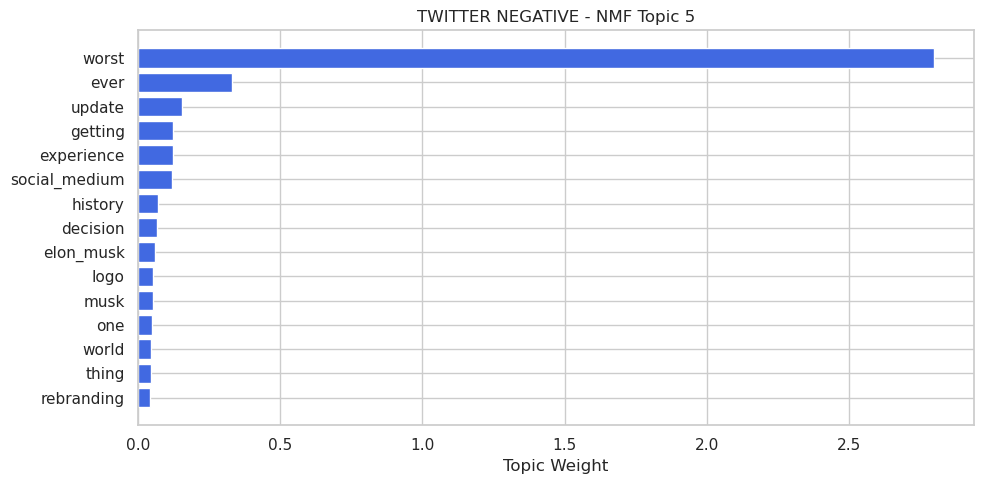

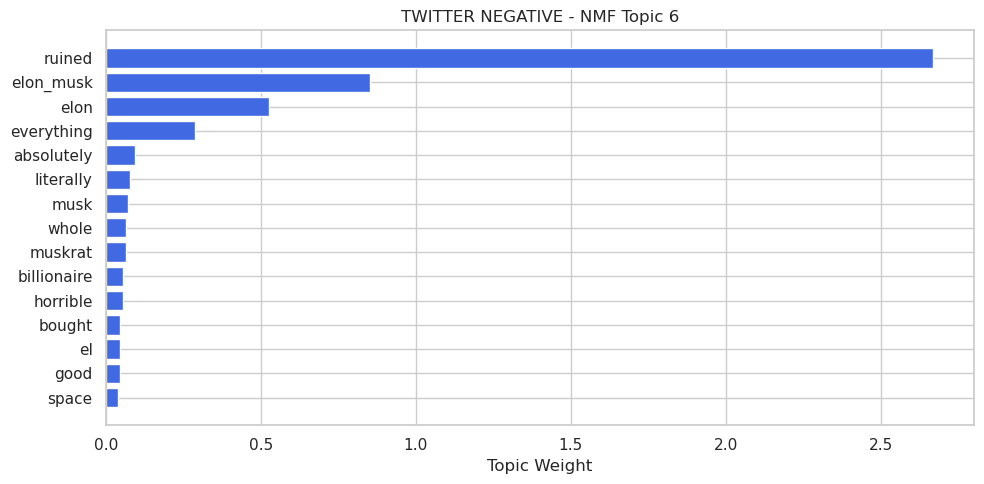

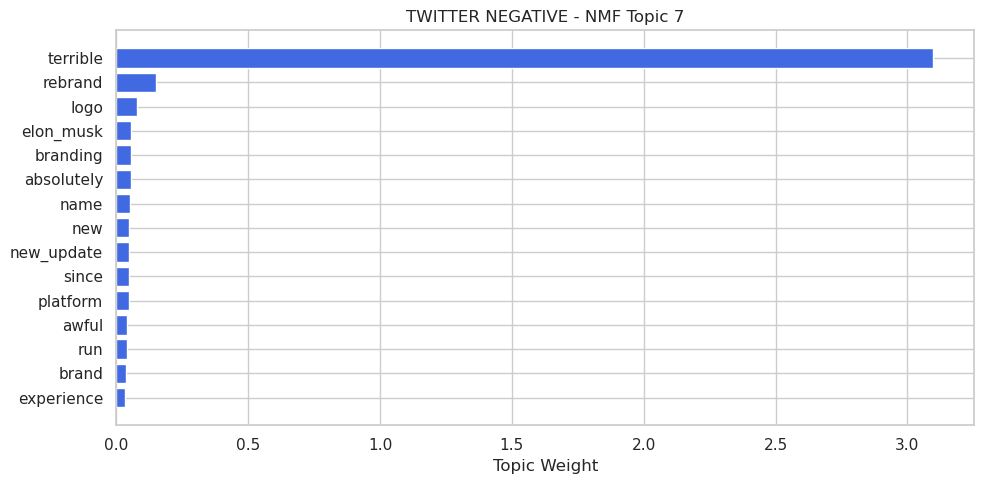

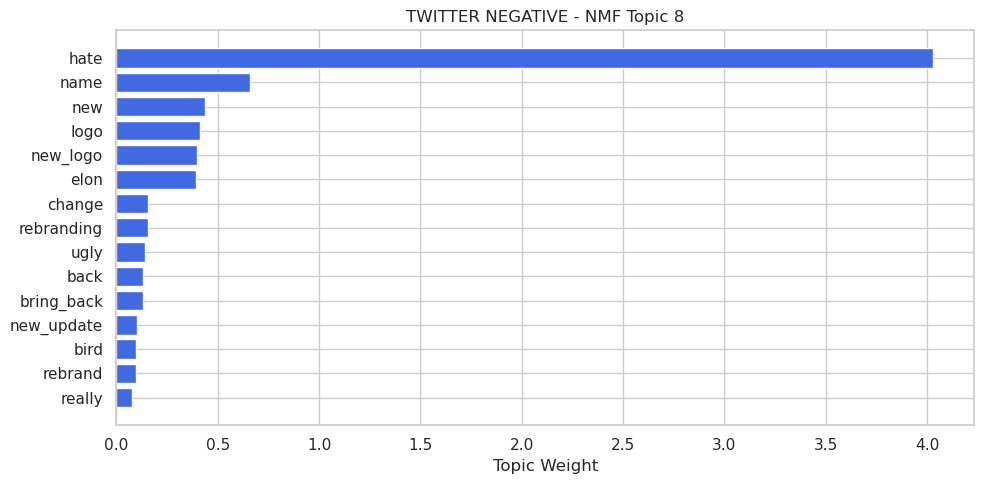

In [198]:
print("\n===== NMF TWITTER POSITIVE =====")
nmf_pos_tw, pos_feats_tw = run_nmf_block(twitter_pos)

print("\n===== NMF TWITTER NEUTRAL =====")
nmf_neu_tw, neu_feats_tw = run_nmf_block(twitter_neu)
print("\n===== NMF TWITTER NEGATIVE =====")
nmf_neg_tw, neg_feats_tw = run_nmf_block(twitter_neg)

visualize_nmf_block(nmf_pos_tw, pos_feats_tw, "Twitter Positive")
visualize_nmf_block(nmf_neu_tw, neu_feats_tw, "Twitter Neutral")
visualize_nmf_block(nmf_neg_tw, neg_feats_tw, "Twitter Negative")


**Overall Summary**

- Positive reviews: Users discuss good experiences, improvements, and positive reactions to updates, free speech features, and platform usability.

- Neutral reviews: Users comment on name/logo changes, rebranding elements, and general platform behavior in a matter-of-fact tone without emotional extremes.

- Negative reviews: Reviews focus heavily on frustration with updates, rebranding decisions, rate limits, and leadership choices that users feel have worsened the experience.

-------

**Positive Sentiment Analysis (NMF)**

Best model: k = 5 topics — Coherence = 0.4573

**1. General Platform Use & Engagement** - *thing, information, news, work, like, platform, good*

Users describe general usage patterns, mentioning news consumption and overall platform functionality in a positive light.

**2. Ease of Use & Interface Experience** - *people, thread, super, easy_use, update, name, platform*

Comments highlight user-friendly interactions, updates, and smooth platform behavior.

**3. Improvement-Oriented Praise** - *awesome, free_speech, better, elon_musk, update, great*

Reviewers appreciate enhancements, free speech elements, and updates viewed as beneficial.

**4. Positive Experiences With New Features** - *experience, better, free_speech, name, elon, world*

Users describe positive reactions to recent changes or new platform elements.

**5. Enjoyment of Threads & Features** - *thread, platform, excellent, free_speech, new, better, love*

Users express enthusiasm for usage, naming features they enjoy and pointing out improvements.

**Insight:**
Positive comments revolve around improved usability, updates perceived as beneficial, and general satisfaction with platform performance.

-------

**Neutral Sentiment Analysis (NMF)**

Best model: k = 4 topics — Coherence = 0.4540

**1. Practical Notes About Issues & Changes** - *thing, bring_back, star, go, ruined, elon*

Neutral observations about updates or features that have shifted, without strong emotional emphasis.

**2. Comments on Rebranding & Changes** - *clown, need, changed, want, trash, elon_musk*

Users mention changes to the platform, including rebranding effects, in a matter-of-fact way.

**3. Discussion of Icons & Logos** - *icon, changed, bring_back, blue_bird, bird, logo, name*

Comments focus on visual elements like icons and logos, typically descriptive rather than emotional.

**4. Functionality & Usage Notes** - *work, use, update, limit, tweet, not*

Users discuss how the platform functions—usage, limits, and general behavior.

**Insight:**
Neutral reviews focus on rebranding, logo/icon changes, and functional observations about usage and updates.

-------

**Negative Sentiment Analysis (NMF)**

Best model: k = 8 topics — Coherence = 0.4093

**1. Problems With Updates & Functionality** - *new_update, icon, use, limit, name, logo, bad*

Users complain about issues introduced by updates, particularly those impacting usability.

**2. Dislike of Rebranding Elements** - *limit, bird, change, logo, bring_back, suck*

Strong negative reactions toward the logo, name change, and related design or branding decisions.

**3. Worsening Experience After Updates** - *getting_worse, update, stupid, tweet, worse, no*

Comments describe the platform becoming less usable, with updates viewed as harmful.

**4. Criticism of Rebranding Direction** - *rebrand, get_worse, forever, elon_ruined, completely*

Users express that the rebranding has negatively impacted the platform.

**5. Leadership & Decision Concerns** - *rebranding, musk, decision, worst, update, ever*

Criticism is directed toward leadership decisions that users feel have worsened the experience.

**6. Strong Disapproval of Overall Changes** -*horrible, billionaire, muskrat, ruined, absolutely, musk*

Users voice intense dissatisfaction toward changes they perceive as disruptive.

**7. Negative Brand & Platform Sentiment** - *experience, brand, awful, branding, terrible, logo*

Comments express dislike for branding changes and their impact on platform identity.

**8. Complaints About New Logo & Rebranding** - *rebrand, new_logo, bring_back, ugly, change, hate*

Users strongly dislike the new logo and request returning to the previous design.

**Insight:**
Negative sentiment largely centers on update-related frustrations, strong dislike of the rebranding, and concern that recent decisions have significantly lowered platform quality.

##### NMF seems to have decent coherence for positive neutral and negative around 0.40 but it is significantly low than LDA and the insights found in LDA seem to be much better than NMF. Hence, LDA is the best choice for now.

## BERTopic  - remove this later

In [199]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import seaborn as sns
import matplotlib.pyplot as plt
'''
# Sentiment splits
positive_df = df[df["sentiment"] == "positive"].copy()
neutral_df  = df[df["sentiment"] == "neutral"].copy()
negative_df = df[df["sentiment"] == "negative"].copy()

positive_texts = positive_df["review_description"].tolist()
neutral_texts  = neutral_df["review_description"].tolist()
negative_texts = negative_df["review_description"].tolist()

print("Counts:", len(positive_texts), len(neutral_texts), len(negative_texts))

# Embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

def run_bertopic(texts, min_topic_size=20):
    embeddings = embedding_model.encode(texts, show_progress_bar=True)
    model = BERTopic(
        language="english",
        umap_model=None,
        min_topic_size=min_topic_size,
        top_n_words=15,
        calculate_probabilities=True,
        verbose=True
    )
    topics, probs = model.fit_transform(texts, embeddings)
    return model, topics, probs, embeddings

print("Running BERTopic on positive reviews...")
pos_model, pos_topics5, pos_probs5, pos_embeddings = run_bertopic(positive_texts, min_topic_size=20)

print("Running BERTopic on neutral reviews...")
neu_model, neu_topics5, neu_probs5, neu_embeddings = run_bertopic(neutral_texts, min_topic_size=20)

print("Running BERTopic on negative reviews...")
neg_model, neg_topics5, neg_probs5, neg_embeddings = run_bertopic(negative_texts, min_topic_size=20)

positive_df["topic5"] = pos_topics5
neutral_df["topic5"]  = neu_topics5
negative_df["topic5"] = neg_topics5
'''

'\n# Sentiment splits\npositive_df = df[df["sentiment"] == "positive"].copy()\nneutral_df  = df[df["sentiment"] == "neutral"].copy()\nnegative_df = df[df["sentiment"] == "negative"].copy()\n\npositive_texts = positive_df["review_description"].tolist()\nneutral_texts  = neutral_df["review_description"].tolist()\nnegative_texts = negative_df["review_description"].tolist()\n\nprint("Counts:", len(positive_texts), len(neutral_texts), len(negative_texts))\n\n# Embedding model\nembedding_model = SentenceTransformer("all-MiniLM-L6-v2")\n\ndef run_bertopic(texts, min_topic_size=20):\n    embeddings = embedding_model.encode(texts, show_progress_bar=True)\n    model = BERTopic(\n        language="english",\n        umap_model=None,\n        min_topic_size=min_topic_size,\n        top_n_words=15,\n        calculate_probabilities=True,\n        verbose=True\n    )\n    topics, probs = model.fit_transform(texts, embeddings)\n    return model, topics, probs, embeddings\n\nprint("Running BERTopic on 

In [200]:
# pos_model, pos_topics, pos_probs, pos_emb = run_bertopic(positive_texts)
# neu_model, neu_topics, neu_probs, neu_emb = run_bertopic(neutral_texts)
# neg_model, neg_topics, neg_probs, neg_emb = run_bertopic(negative_texts)
'''
def reduce_to_5(model, texts, embeddings):
    reduced_model = model.reduce_topics(texts, nr_topics=5)
    new_topics, new_probs = reduced_model.transform(texts, embeddings)
    return reduced_model, new_topics, new_probs

pos_model5, pos_topics5, pos_probs5 = reduce_to_5(pos_model, positive_texts, pos_embeddings)
neu_model5, neu_topics5, neu_probs5 = reduce_to_5(neu_model, neutral_texts, neu_embeddings)
neg_model5, neg_topics5, neg_probs5 = reduce_to_5(neg_model, negative_texts, neg_embeddings)
'''

'\ndef reduce_to_5(model, texts, embeddings):\n    reduced_model = model.reduce_topics(texts, nr_topics=5)\n    new_topics, new_probs = reduced_model.transform(texts, embeddings)\n    return reduced_model, new_topics, new_probs\n\npos_model5, pos_topics5, pos_probs5 = reduce_to_5(pos_model, positive_texts, pos_embeddings)\nneu_model5, neu_topics5, neu_probs5 = reduce_to_5(neu_model, neutral_texts, neu_embeddings)\nneg_model5, neg_topics5, neg_probs5 = reduce_to_5(neg_model, negative_texts, neg_embeddings)\n'

In [201]:
import matplotlib.pyplot as plt
'''
def plot_topic(words, weights, title):
    plt.figure(figsize=(10, 5))
    plt.barh(words[::-1], weights[::-1], color="royalblue")
    plt.title(title)
    plt.xlabel("Topic Weight")
    plt.tight_layout()
    plt.show()

'''

'\ndef plot_topic(words, weights, title):\n    plt.figure(figsize=(10, 5))\n    plt.barh(words[::-1], weights[::-1], color="royalblue")\n    plt.title(title)\n    plt.xlabel("Topic Weight")\n    plt.tight_layout()\n    plt.show()\n\n'

In [202]:
'''
def inspect_topics(model, df_sent, group_name):
    print(f"===== BERTOPIC SUMMARY ({group_name.upper()}) — 5 TOPICS =====")

    topic_info = model.get_topic_info()
    print(topic_info)

    print(f"\n--- TOP WORDS ({group_name}) ---")
    for tid in topic_info["Topic"]:
        if tid == -1:
            continue
        print(f"\nTopic {tid}:")
        print(model.get_topic(tid))

    # Topic distribution barplot
    plt.figure(figsize=(8,4))
    sns.barplot(x="Topic", y="Count", data=topic_info[topic_info["Topic"] != -1])
    plt.title(f"Topic Distribution ({group_name.capitalize()} Reviews)")
    plt.tight_layout()
    plt.show()

    for tid in topic_info["Topic"]:
        if tid == -1:
            continue

        words_scores = model.get_topic(tid)
        words = [w for (w, score) in words_scores]
        weights = [score for (w, score) in words_scores]

        plot_topic(words, weights, title=f"{group_name.upper()} - BERTopic {tid}")

    print(f"\n--- REPRESENTATIVE EXAMPLES ({group_name}) ---")
    repr_docs = model.get_representative_docs()
    for tid, docs in repr_docs.items():
        if tid == -1:
            continue
        print(f"\nTopic {tid} Examples:")
        for d in docs[:3]:
            print("-", d[:200], "...")
'''

'\ndef inspect_topics(model, df_sent, group_name):\n    print(f"===== BERTOPIC SUMMARY ({group_name.upper()}) — 5 TOPICS =====")\n\n    topic_info = model.get_topic_info()\n    print(topic_info)\n\n    print(f"\n--- TOP WORDS ({group_name}) ---")\n    for tid in topic_info["Topic"]:\n        if tid == -1:\n            continue\n        print(f"\nTopic {tid}:")\n        print(model.get_topic(tid))\n\n    # Topic distribution barplot\n    plt.figure(figsize=(8,4))\n    sns.barplot(x="Topic", y="Count", data=topic_info[topic_info["Topic"] != -1])\n    plt.title(f"Topic Distribution ({group_name.capitalize()} Reviews)")\n    plt.tight_layout()\n    plt.show()\n\n    for tid in topic_info["Topic"]:\n        if tid == -1:\n            continue\n\n        words_scores = model.get_topic(tid)\n        words = [w for (w, score) in words_scores]\n        weights = [score for (w, score) in words_scores]\n\n        plot_topic(words, weights, title=f"{group_name.upper()} - BERTopic {tid}")\n\n    pr

In [203]:
'''
inspect_topics(pos_model5, positive_df, "positive")
inspect_topics(neu_model5, neutral_df, "neutral")
inspect_topics(neg_model5, negative_df, "negative")
'''

'\ninspect_topics(pos_model5, positive_df, "positive")\ninspect_topics(neu_model5, neutral_df, "neutral")\ninspect_topics(neg_model5, negative_df, "negative")\n'

In [204]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
'''
def get_bertopic_top_words(model, top_n=15):
    topic_words = []
    for topic_num in model.get_topics().keys():
        if topic_num == -1:  # skip outlier topic
            continue
        words_probs = model.get_topic(topic_num)
        words = [w for w, _ in words_probs[:top_n]]
        topic_words.append(words)
    return topic_words

def tokenize_texts(texts):
    return [text.split() for text in texts]

def compute_bertopic_coherence(model, texts, top_n=15):
    tokenized_texts = tokenize_texts(texts)
    topic_word_lists = get_bertopic_top_words(model, top_n=top_n)
    dictionary = Dictionary(tokenized_texts)
    corpus = [dictionary.doc2bow(text) for text in tokenized_texts]
    cm = CoherenceModel(
        topics=topic_word_lists,
        texts=tokenized_texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    return cm.get_coherence()

# Compute coherence for each sentiment
pos_coherence = compute_bertopic_coherence(pos_model, positive_texts)
neu_coherence = compute_bertopic_coherence(neu_model, neutral_texts)
neg_coherence = compute_bertopic_coherence(neg_model, negative_texts)

print("Positive BERTopic Coherence:", pos_coherence)
print("Neutral BERTopic Coherence:", neu_coherence)
print("Negative BERTopic Coherence:", neg_coherence)
'''

'\ndef get_bertopic_top_words(model, top_n=15):\n    topic_words = []\n    for topic_num in model.get_topics().keys():\n        if topic_num == -1:  # skip outlier topic\n            continue\n        words_probs = model.get_topic(topic_num)\n        words = [w for w, _ in words_probs[:top_n]]\n        topic_words.append(words)\n    return topic_words\n\ndef tokenize_texts(texts):\n    return [text.split() for text in texts]\n\ndef compute_bertopic_coherence(model, texts, top_n=15):\n    tokenized_texts = tokenize_texts(texts)\n    topic_word_lists = get_bertopic_top_words(model, top_n=top_n)\n    dictionary = Dictionary(tokenized_texts)\n    corpus = [dictionary.doc2bow(text) for text in tokenized_texts]\n    cm = CoherenceModel(\n        topics=topic_word_lists,\n        texts=tokenized_texts,\n        dictionary=dictionary,\n        coherence=\'c_v\'\n    )\n    return cm.get_coherence()\n\n# Compute coherence for each sentiment\npos_coherence = compute_bertopic_coherence(pos_model,

BERTopic Analysis for Threads Reviews

---

Positive Sentiment Analysis
**Coherence Score:** 0.5980  


---

Neutral Sentiment Analysis
**Coherence Score:** 0.4907


---

Negative Sentiment Analysis
**Coherence Score:** 0.411


BERTopic does an impressive job in positive sentiment but performs pretty poorly in negative sentiment, hence we are not going to analyse each topic in the sentiments.

## FINAL VERDIT : LDA Performs the best among all the unsupervised models and provides the best coherence score and a good division of topics among the sentiments

## BERTopic

In [205]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary

# -----------------------------
# Embedding model (shared)
# -----------------------------
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# -----------------------------
# Plotting helper
# -----------------------------
def plot_topic(words, weights, title):
    plt.figure(figsize=(10,5))
    plt.barh(words[::-1], weights[::-1], color="royalblue")
    plt.title(title)
    plt.xlabel("Topic Weight")
    plt.tight_layout()
    plt.show()

# -----------------------------
# BERTopic pipeline
# -----------------------------
def run_bertopic_pipeline(df, sentiment_col="sentiment", review_col="review_description",
                          sentiment_value=None, min_topic_size=20, reduce_to=5):
    """
    Run BERTopic for a given sentiment subset of a DataFrame.
    Returns the fitted model, topics, probabilities, embeddings, and coherence score.
    """
    # Filter data
    subset = df[df[sentiment_col] == sentiment_value].copy()
    
    # Remove NaN values and convert to string
    subset = subset[subset[review_col].notna()].copy()  
    subset[review_col] = subset[review_col].astype(str)  
    texts = subset[review_col].tolist()

    texts = [t for t in texts if t.strip() != ""]
    
    # Compute embeddings
    embeddings = embedding_model.encode(texts, show_progress_bar=True)
    
    # Fit BERTopic
    model = BERTopic(
        language="english",
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        min_topic_size=min_topic_size,
        top_n_words=15,
        calculate_probabilities=True,
        verbose=False
    )
    
    topics, probs = model.fit_transform(texts, embeddings)
    
    # Reduce topics
    if reduce_to is not None:
        model = model.reduce_topics(texts, nr_topics=reduce_to)
        topics, probs = model.transform(texts, embeddings)
    
    # Inspect topics
    inspect_topics(model, texts, sentiment_value.capitalize())
    
    # Compute coherence
    coherence = compute_bertopic_coherence(model, texts)
    
    print(f"{sentiment_value.capitalize()} BERTopic Coherence:", coherence)
    
    return model, topics, probs, embeddings, coherence

# -----------------------------
# Inspect topics helper
# -----------------------------
def inspect_topics(model, texts, group_name):
    print(f"\n===== BERTOPIC SUMMARY ({group_name.upper()}) — 5 TOPICS =====")
    topic_info = model.get_topic_info()
    print(topic_info)

    # Topic distribution barplot
    plt.figure(figsize=(8,4))
    sns.barplot(x="Topic", y="Count", data=topic_info[topic_info["Topic"] != -1])
    plt.title(f"Topic Distribution ({group_name.capitalize()} Reviews)")
    plt.tight_layout()
    plt.show()

    # Plot top words per topic
    for tid in topic_info["Topic"]:
        if tid == -1:
            continue
        words_scores = model.get_topic(tid)
        words = [w for w, score in words_scores]
        weights = [score for w, score in words_scores]
        plot_topic(words, weights, title=f"{group_name.upper()} - BERTopic {tid}")

    # Representative examples
    print(f"\n--- REPRESENTATIVE EXAMPLES ({group_name}) ---")
    repr_docs = model.get_representative_docs()
    for tid, docs in repr_docs.items():
        if tid == -1:
            continue
        print(f"\nTopic {tid} Examples:")
        for d in docs[:3]:
            print("-", d[:200], "...")

# -----------------------------
# Coherence computation
# -----------------------------
def get_bertopic_top_words(model, top_n=15):
    topic_words = []
    for topic_num in model.get_topics().keys():
        if topic_num == -1:
            continue
        words_probs = model.get_topic(topic_num)
        words = [w for w, _ in words_probs[:top_n]]
        topic_words.append(words)
    return topic_words

def tokenize_texts(texts):
    return [text.split() for text in texts]

def compute_bertopic_coherence(model, texts, top_n=15):
    tokenized_texts = tokenize_texts(texts)
    topic_word_lists = get_bertopic_top_words(model, top_n=top_n)
    dictionary = Dictionary(tokenized_texts)
    cm = CoherenceModel(
        topics=topic_word_lists,
        texts=tokenized_texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    return cm.get_coherence()


### Threads BERTopic Analysis

Batches:   0%|          | 0/494 [00:00<?, ?it/s]


===== BERTOPIC SUMMARY (POSITIVE) — 5 TOPICS =====
   Topic  Count                             Name  \
0     -1   3578                -1_the_to_and_app   
1      0   4913            0_good_nice_very_best   
2      1   3870                  1_app_the_it_to   
3      2   3409             2_twitter_to_the_and   
4      3     30  3_copy_original_copycat_copying   

                                      Representation  \
0  [the, to, and, app, it, is, of, this, twitter,...   
1  [good, nice, very, best, super, wow, awesome, ...   
2  [app, the, it, to, this, good, is, and, nice, ...   
3  [twitter, to, the, and, is, better, app, it, t...   
4  [copy, original, copycat, copying, is, copyrig...   

                                 Representative_Docs  
0  [i love the vibes and the atmosphere and how i...  
1                                 [Good, good, Good]  
2  [It's a good app, This is a good app, It is a ...  
3  [It is just like Twitter and same as Instagram...  
4  [Nice copy, Good cop

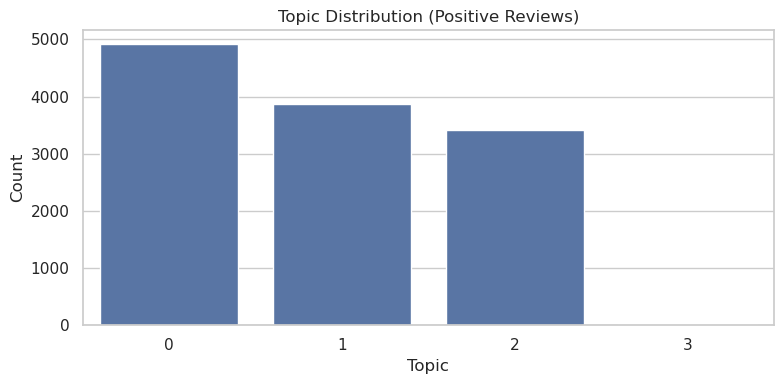

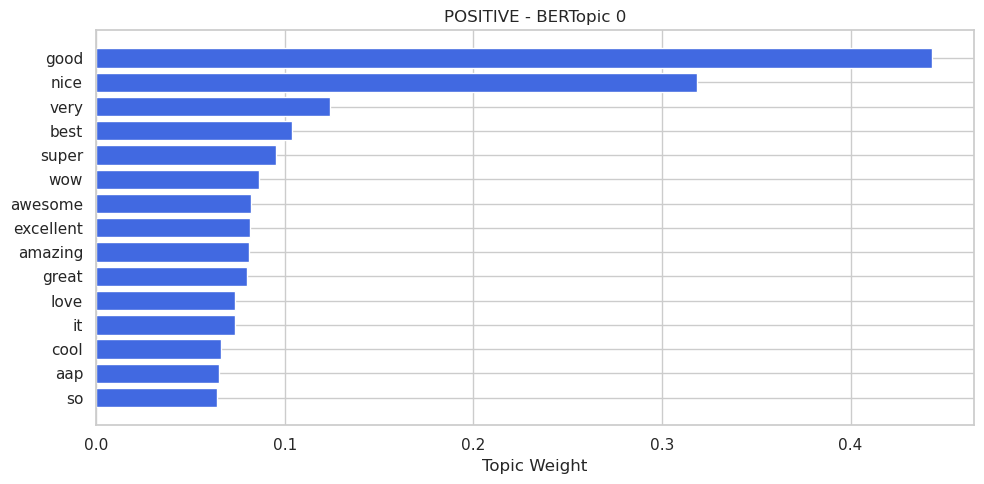

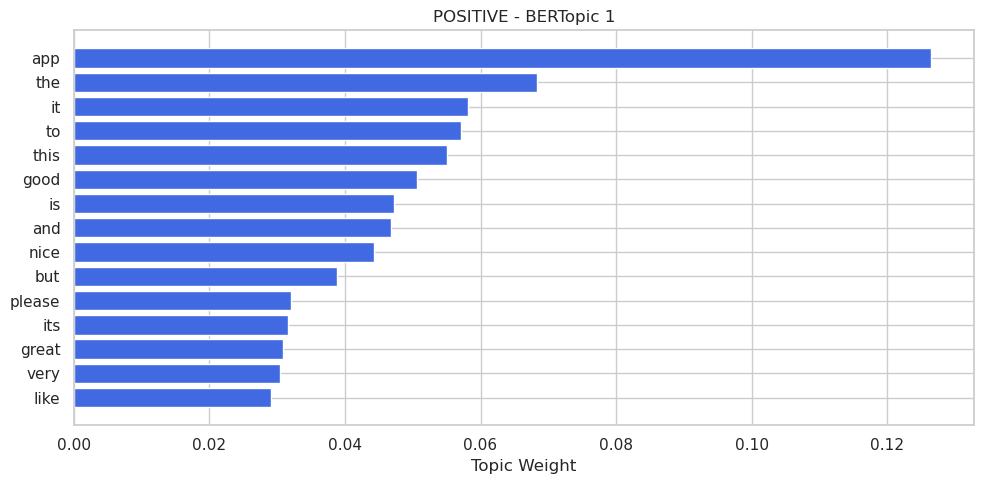

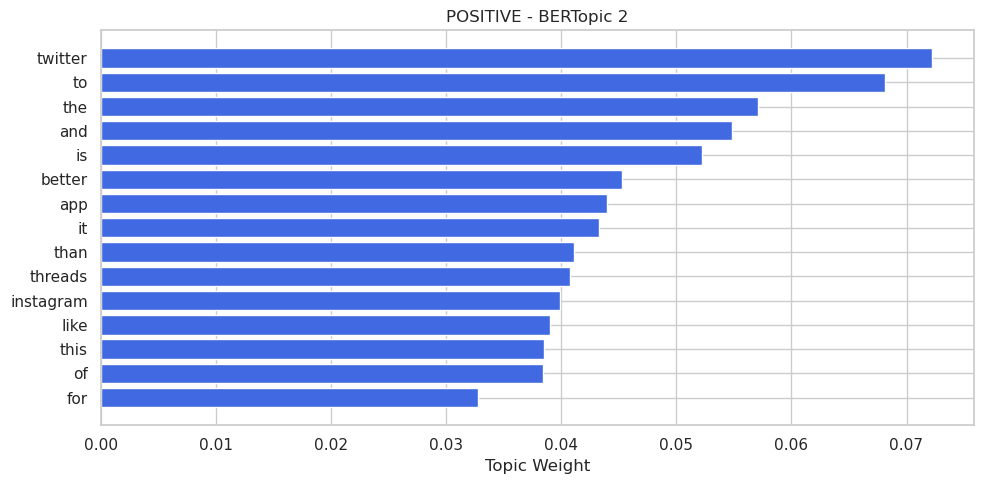

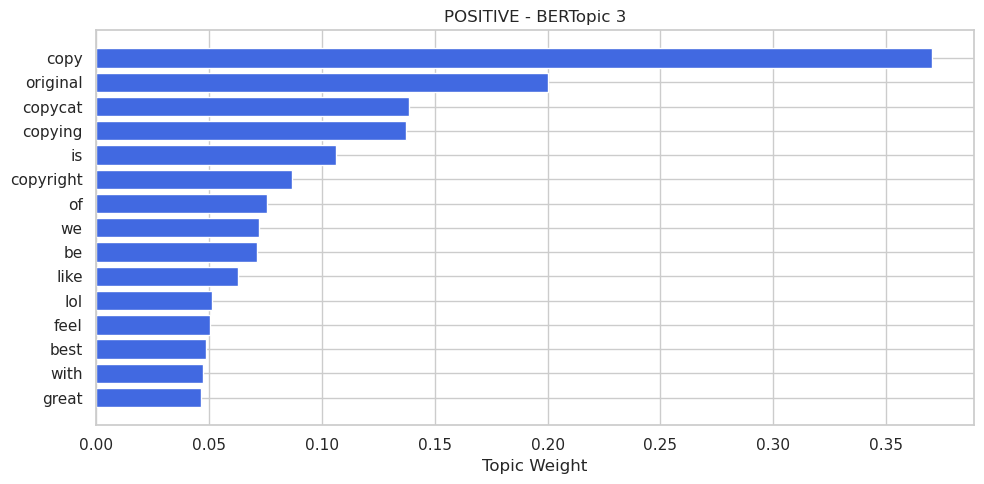


--- REPRESENTATIVE EXAMPLES (Positive) ---

Topic 0 Examples:
- Good ...
- good ...
- Good ...

Topic 1 Examples:
- It's a good app ...
- This is a good app ...
- It is a good app ...

Topic 2 Examples:
- It is just like Twitter and same as Instagram but it is a good app. I love it. ...
- The app is still new and I have installed the app for the first time. The setup was easy to do. One thing that I would love to see on the app is that you can upload videos on Threads and the other thi ...
- Not bad I guess there's not much to show it's just post from random people no way of messaging I guess need more updates Instagram is better than Threads as for twitter vs Threads - twitter win if Ins ...

Topic 3 Examples:
- Nice copy ...
- Good copy ...
- Copy is copy anyway , original is always best ...
Positive BERTopic Coherence: 0.5224446567623378


Batches:   0%|          | 0/298 [00:00<?, ?it/s]


===== BERTOPIC SUMMARY (NEUTRAL) — 5 TOPICS =====
   Topic  Count                       Name  \
0     -1   2851           -1_the_to_it_and   
1      0   2234  0_twitter_to_instagram_of   
2      1   2168          1_app_the_it_this   
3      2   2082   2_elon_first_review_musk   
4      3    190  3_copy_cat_copycat_copied   

                                      Representation  \
0  [the, to, it, and, app, is, twitter, this, of,...   
1  [twitter, to, instagram, of, account, the, and...   
2  [app, the, it, this, to, is, and, not, its, ca...   
3  [elon, first, review, musk, zuck, is, to, the,...   
4  [copy, cat, copycat, copied, cheap, app, clone...   

                                 Representative_Docs  
0  [So at the moment I have two issues with the a...  
1  [This app is a copy of twitter., copy of twitt...  
2  [The app is crashing., Doges's app, I download...  
3  [This... ELON MUSK !!, The first one to review...  
4                                 [Copy, copy, copy]  


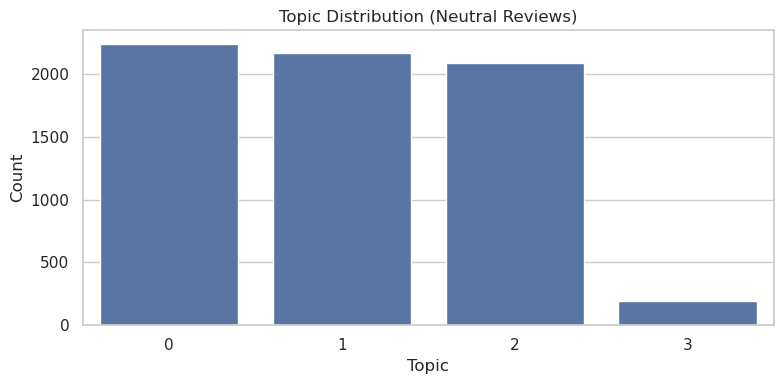

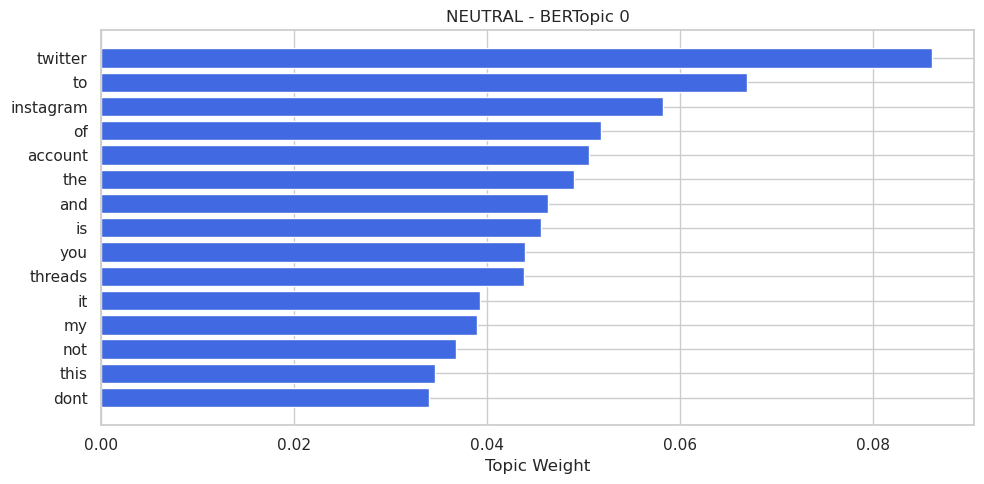

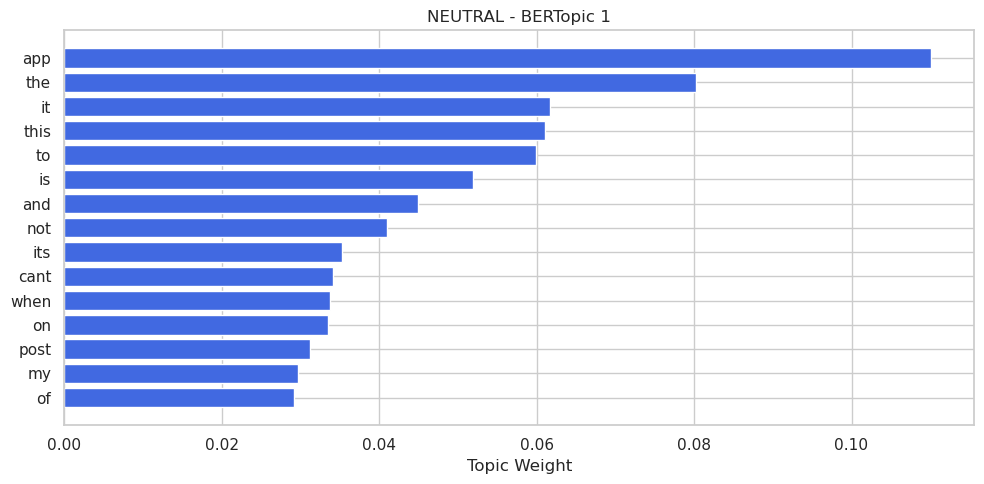

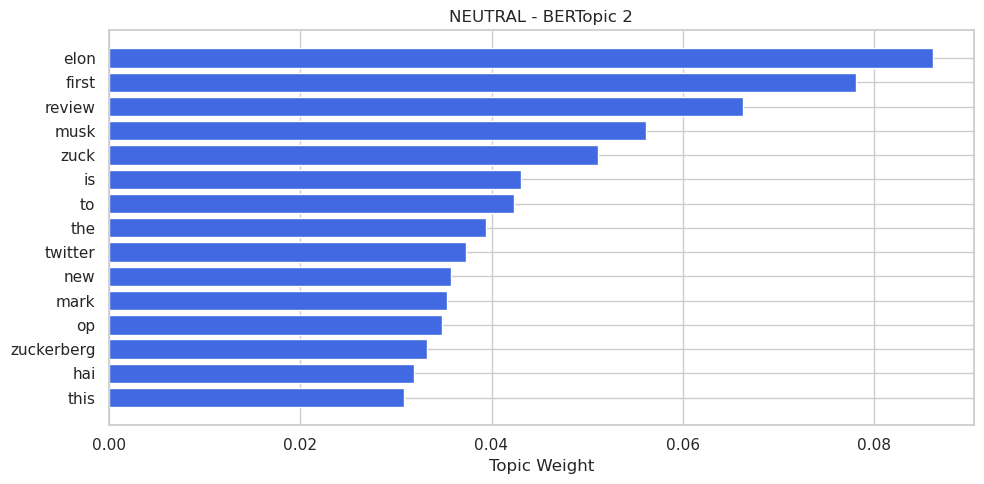

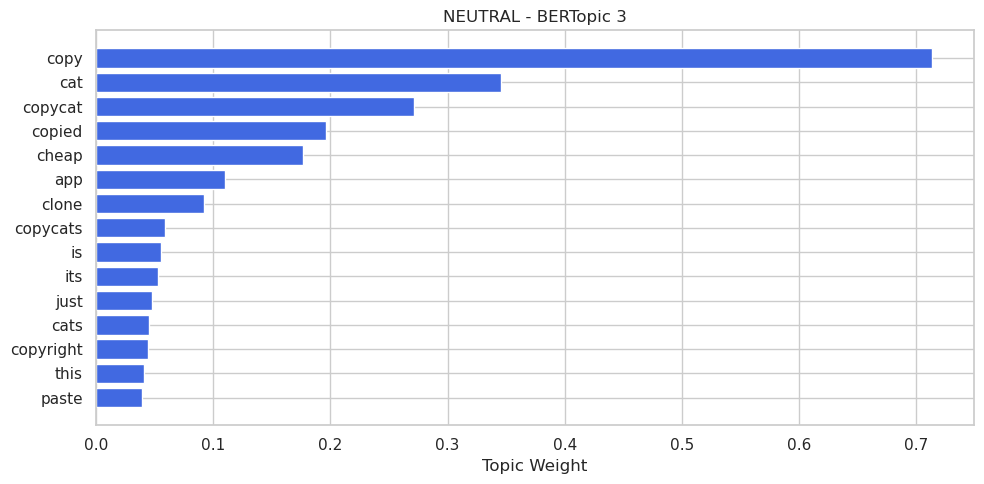


--- REPRESENTATIVE EXAMPLES (Neutral) ---

Topic 0 Examples:
- This app is a copy of twitter. ...
- copy of twitter. if you install it_no way to delite it_ (if you want to delete it, u will have to delete your Instagram account. ...
- The app is OK and it has a lot of bugs. It is not as good is twitter at all. I’ve had so many problems since this app has came out not only that it is a copy of Twitter and a jp app that is 90% just l ...

Topic 1 Examples:
- The app is crashing. ...
- Doges's app ...
- I downloaded this for the first time which is today, the problem is it keeps glitching... I already reinstalled this app 3 times and whenever I open it, it still glitch like the whole screen of thread ...

Topic 2 Examples:
- This... ELON MUSK !! ...
- The first one to review 😂 ...
- This is elon musk ...

Topic 3 Examples:
- Copy ...
- copy ...
- copy ...
Neutral BERTopic Coherence: 0.5924329501926741


Batches:   0%|          | 0/136 [00:00<?, ?it/s]


===== BERTOPIC SUMMARY (NEGATIVE) — 5 TOPICS =====
   Topic  Count                   Name  \
0     -1   1171      -1_the_to_and_app   
1      0   1207        0_to_the_and_of   
2      1   1199        1_app_the_to_it   
3      2    629  2_bad_boring_not_good   
4      3    115    3_elon_musk_zuck_is   

                                      Representation  \
0  [the, to, and, app, it, is, of, this, twitter,...   
1  [to, the, and, of, is, twitter, you, it, insta...   
2  [app, the, to, it, and, is, post, crashes, my,...   
3  [bad, boring, not, good, useless, very, experi...   
4  [elon, musk, zuck, is, hai, he, bhi, ki, the, ...   

                                 Representative_Docs  
0  [Don't download this app this app is block you...  
1  [There are no settings for you to control the ...  
2  [Bad app not to try it 🤮, I just installed the...  
3  [Very bad experience 🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮, ⚠️🛑⚠️Very Bad...  
4  [This is the real fight between Zuck and Elon ...  


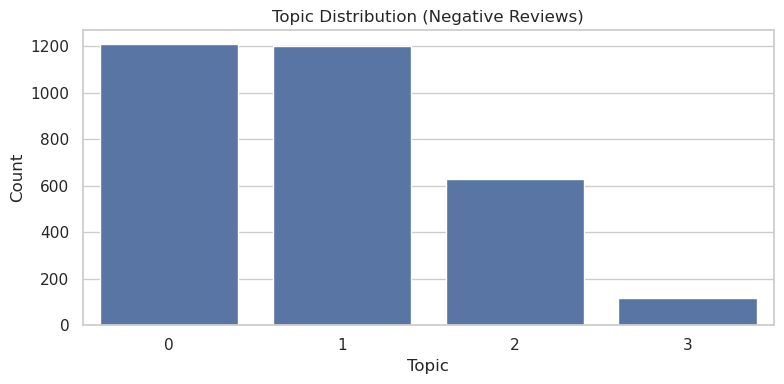

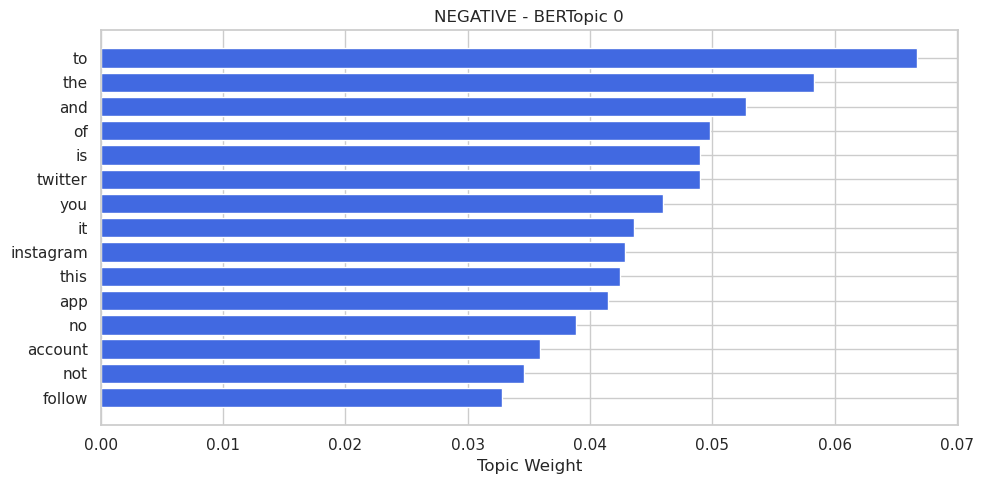

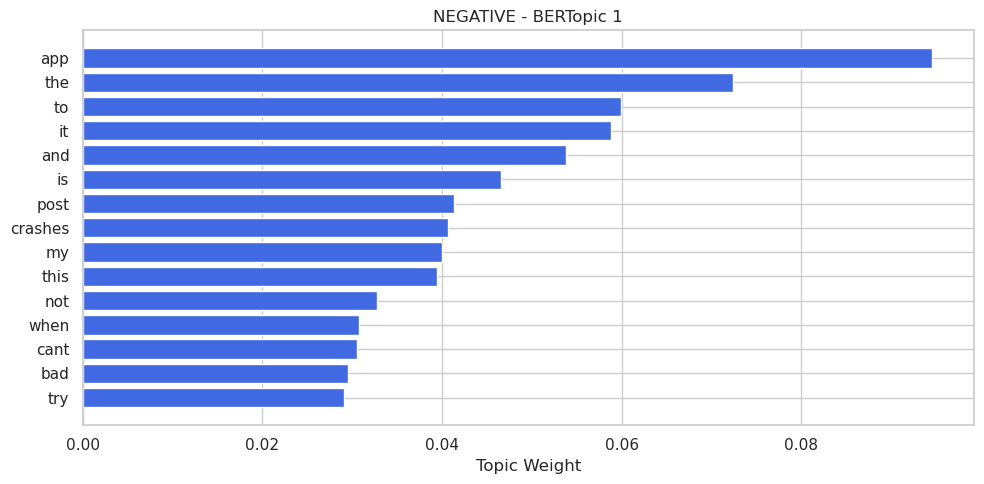

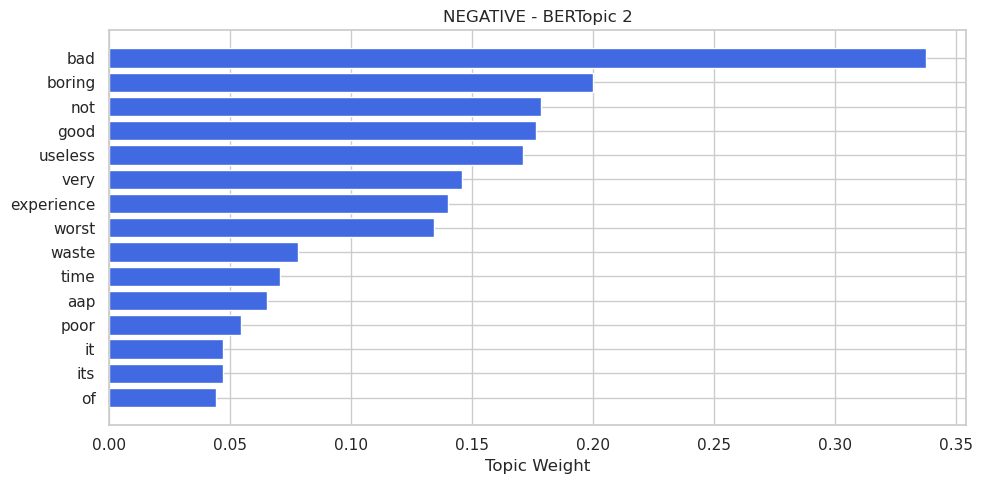

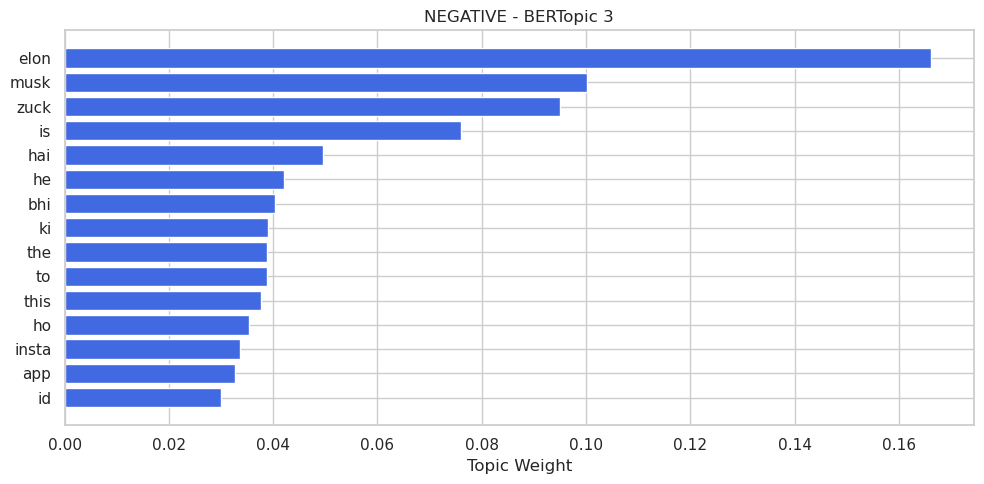


--- REPRESENTATIVE EXAMPLES (Negative) ---

Topic 0 Examples:
- There are no settings for you to control the experience. 

I made the mistake of refreshing my homepage and now I’m seeing accounts from the entire world — I can’t even find the people I follow anymor ...
- it's on a good start to be a good socmed app, i just have some problems with it: 1. there is only a for you page, you have to see what the algorithm wants you to see and there's no way to only see pos ...
- No interaction with people you follow. Period. You'll be lucky to see a post that isn't a business or verified account. No rhyme or reason to posts that the feed shows you. This is the same as the ad  ...

Topic 1 Examples:
- Bad app not to try it 🤮 ...
- I just installed the app. But when I try to open it it crashes. ...
- This app is THE WORST!!!!!!! Like seriously my gosh. I can't do anything in the app etohout it kicking me out and sending me to the home screen. I can see people’s threads, butbitbkicks me out an

In [206]:
threads_pos_model, threads_pos_topics, threads_pos_probs, threads_pos_emb, threads_pos_coh = \
    run_bertopic_pipeline(df_threads, sentiment_value="positive")

threads_neu_model, threads_neu_topics, threads_neu_probs, threads_neu_emb, threads_neu_coh = \
    run_bertopic_pipeline(df_threads, sentiment_value="neutral")

threads_neg_model, threads_neg_topics, threads_neg_probs, threads_neg_emb, threads_neg_coh = \
    run_bertopic_pipeline(df_threads, sentiment_value="negative")


[Summary]

Across positive, neutral, and negative reviews, BERTopic identifies consistent themes related to user experience, app design, comparisons to Twitter/Instagram, and reactions to platform stability and leadership.

- Positive reviews emphasize general satisfaction, ease of use, and comparisons to other platforms.
- Neutral reviews frequently discuss functionality, bugs, copying concerns, and technical behavior without strong sentiment.
- Negative reviews highlight crashes, poor usability, algorithm frustrations, and criticism toward the platform’s direction and leadership.

(Topic -1 = “outlier” or “miscellaneous garbage cluster.”)

**Positive Sentiment Topics**

Best Model: 5 Topics — Coherence = 0.522

**1. General Positive Impressions** — *good, nice, best, awesome, super*

Short, simple praises reflecting overall approval of the app.

**2. Basic App Satisfaction** — *app, good, nice, this, is*

Users describe the app as functional and enjoyable.

**3. Twitter Comparisons** — *twitter, better, app, new*

Positive remarks referencing similarity to Twitter or preferences over other platforms.

**4. Copy / Clone Comments (Positive Tone)** — *copy, original, copycat*

Light-hearted comments acknowledging similarities with other apps.

**Insight:**
Positive reviews center on general enjoyment, ease of use, and some appreciation of Twitter-like features.

------

**Neutral Sentiment Topics**

Best Model: 5 Topics — Coherence = 0.592

**1. Platform Comparisons** — *twitter, instagram, account, app*

Neutral evaluations of how Threads stacks up against other platforms.

**2. App Functionality & Bugs** — *app, crashing, glitching, bug*

Reports of technical issues or normal observations during use.

**3. Elon-Related Mentions** — *elon, musk, review, zuck*

Neutral remarks referencing public figures associated with social media platforms.

**4. Rebranding / Copying Discussions** — *copy, cat, copycat, copied*

Matter-of-fact comments about Threads resembling Twitter.

**Insight:**
Neutral reviews typically describe features, bugs, and platform comparisons without emotional judgment.

------

**Negative Sentiment Topics**

Best Model: 5 Topics — Coherence = 0.492

**1. Poor User Experience** — *post, crashes, app, my, bad*

Users complain about app instability, crashes, and general performance issues.

**2. Algorithm & Feed Problems** — *settings, see, follow, for-you*

Frustration with the lack of control over what appears in the feed.

**3. Strong Negative Reactions** — *bad, boring, not good, useless*

Explicit negative sentiment about the overall experience.

**4. Elon/Zuck Mentions (Negative Tone)** — *elon, musk, zuck*

Criticism directed toward platform leadership or comparisons to other social media companies.

**Insight:**
Negative reviews focus heavily on app crashes, poor usability, and dissatisfaction with algorithmic content and platform direction.

### Twitter BERTopic Analysis

Batches:   0%|          | 0/338 [00:00<?, ?it/s]


===== BERTOPIC SUMMARY (POSITIVE) — 5 TOPICS =====
   Topic  Count                     Name  \
0     -1   2492         -1_the_to_and_it   
1      0   4258          0_app_the_to_it   
2      1   3136   1_good_nice_very_great   
3      2    838  2_elon_speech_musk_free   
4      3     87     3_account_my_to_help   

                                      Representation  \
0  [the, to, and, it, is, app, twitter, of, for, ...   
1  [app, the, to, it, and, twitter, is, this, its...   
2  [good, nice, very, great, best, love, excellen...   
3  [elon, speech, musk, free, freedom, of, the, i...   
4  [account, my, to, help, number, please, me, ca...   

                                 Representative_Docs  
0  [Used to be my favorite social media apps but ...  
1  [This is the best social media app., I love th...  
2                                 [Good, Good, Good]  
3  [Elon Musk X is the best, Freedom of speech th...  
4  [Can anyone help me to get back my Twitter acc...  


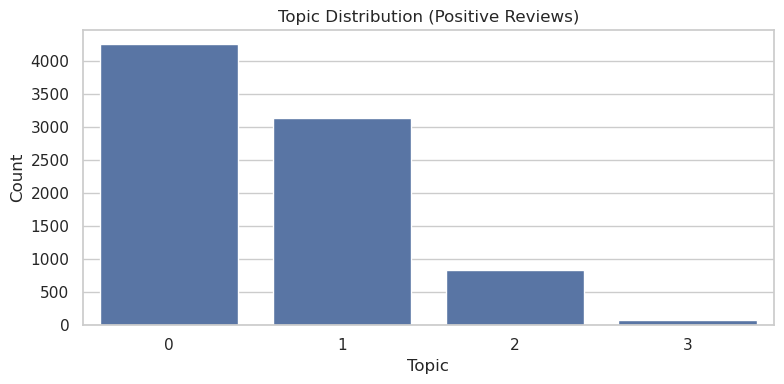

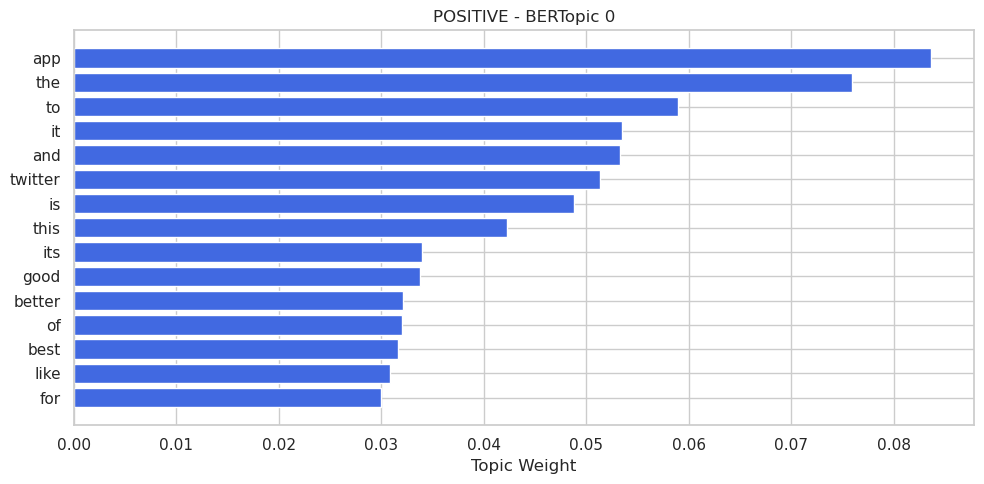

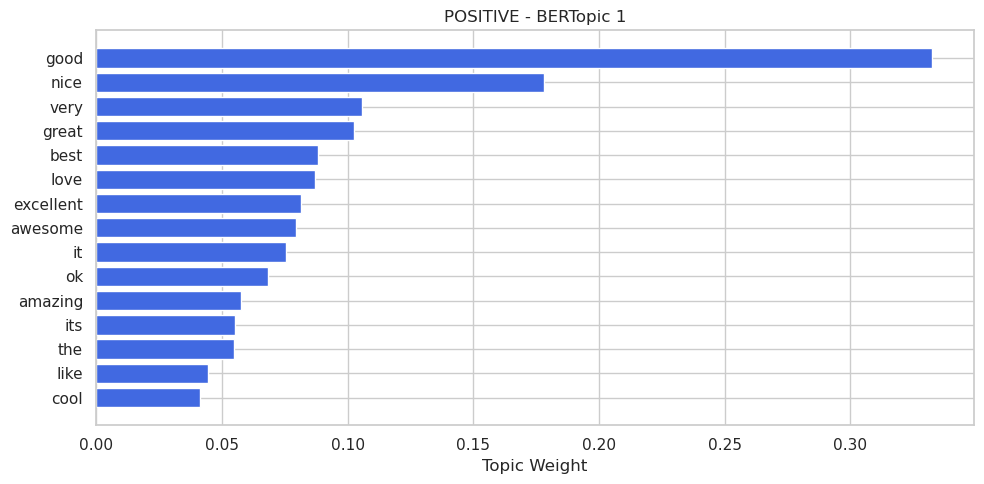

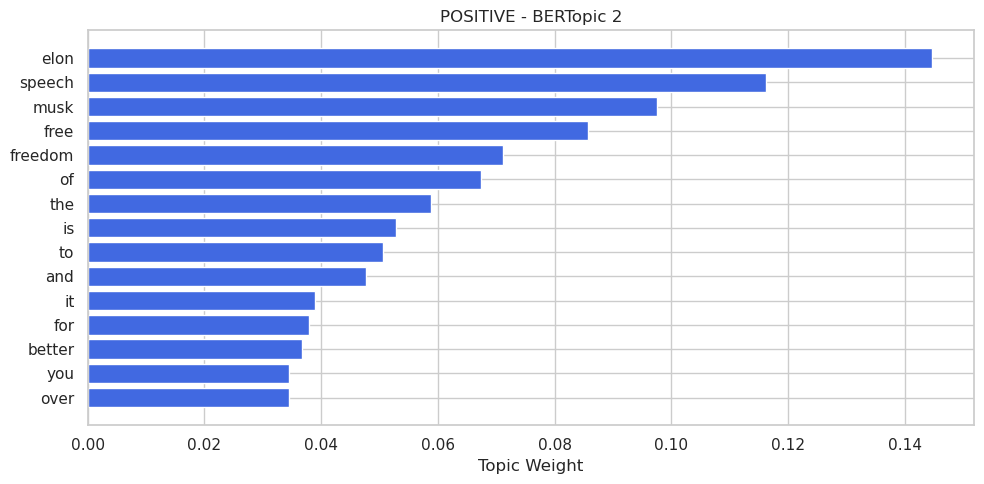

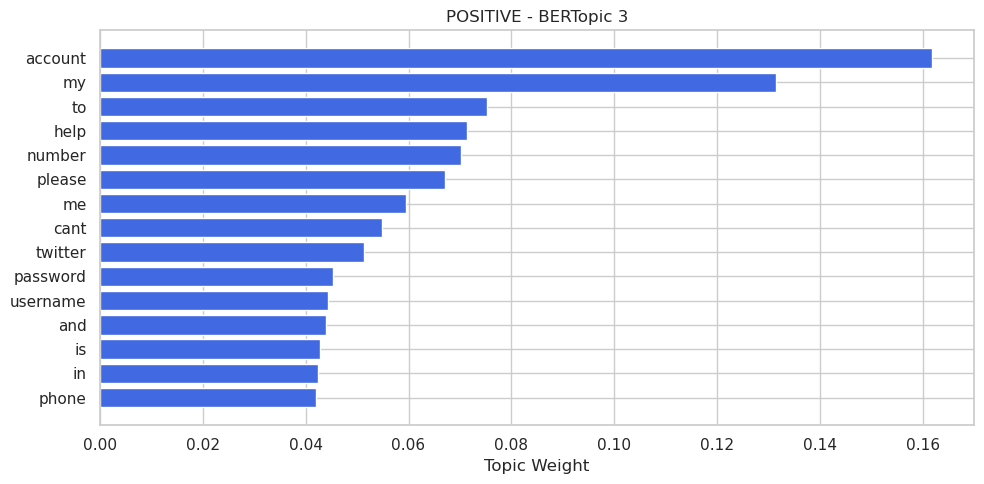


--- REPRESENTATIVE EXAMPLES (Positive) ---

Topic 0 Examples:
- This is the best social media app. ...
- I love this app it's the best ...
- Twitter is the best app f you ...

Topic 1 Examples:
- Good ...
- Good ...
- Good ...

Topic 2 Examples:
- Elon Musk X is the best ...
- Freedom of speech thanks Elon ...
- thanks twitter and elon musk for freedom of speech ...

Topic 3 Examples:
- Can anyone help me to get back my Twitter account. I did not have email or phone number under my profile. I always log in through the app but I logged out as I changed to a new device. Thinking Twitte ...
- My twitter account has been hacked and i am unable to login or change password and can't even report cause whoever hacked my account changed everything like username password and maybe phone number so ...
- I asked you for help to recover my account that is with my number, and you sent me solutions where i have to do into the account, i cant enter to my account i know my password but i dont remember

Batches:   0%|          | 0/321 [00:00<?, ?it/s]


===== BERTOPIC SUMMARY (NEUTRAL) — 5 TOPICS =====
   Topic  Count                          Name  \
0     -1   3406              -1_the_to_and_it   
1      0   3980          0_the_twitter_app_to   
2      1   1836              1_is_to_trash_it   
3      2    892          2_elon_musk_jelek_is   
4      3    136  3_limit_rate_exceeded_limits   

                                      Representation  \
0  [the, to, and, it, is, app, twitter, this, of,...   
1  [the, twitter, app, to, it, this, and, is, not...   
2  [is, to, trash, it, the, of, its, now, what, t...   
3  [elon, musk, jelek, is, it, since, elvish, for...   
4  [limit, rate, exceeded, limits, the, view, lim...   

                                 Representative_Docs  
0  [Switching the name was unnecessary and ruined...  
1  [Change the name back to Twitter, Change the n...  
2  [Dropping this back down to 1 star until the n...  
3               [Elon Musk🔥, Elon musk, Elon musk 💩]  
4                        [limit, Limit, LI

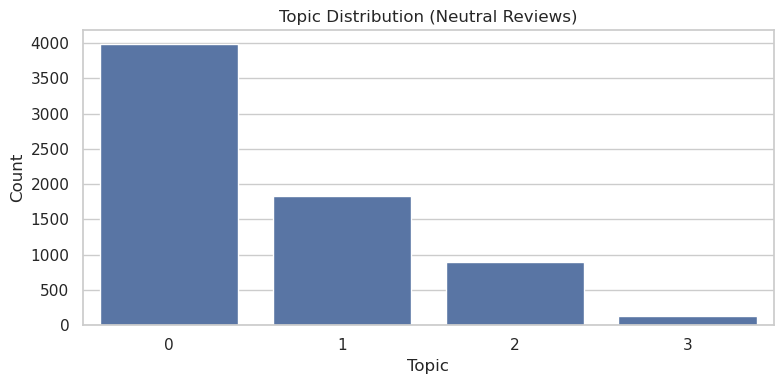

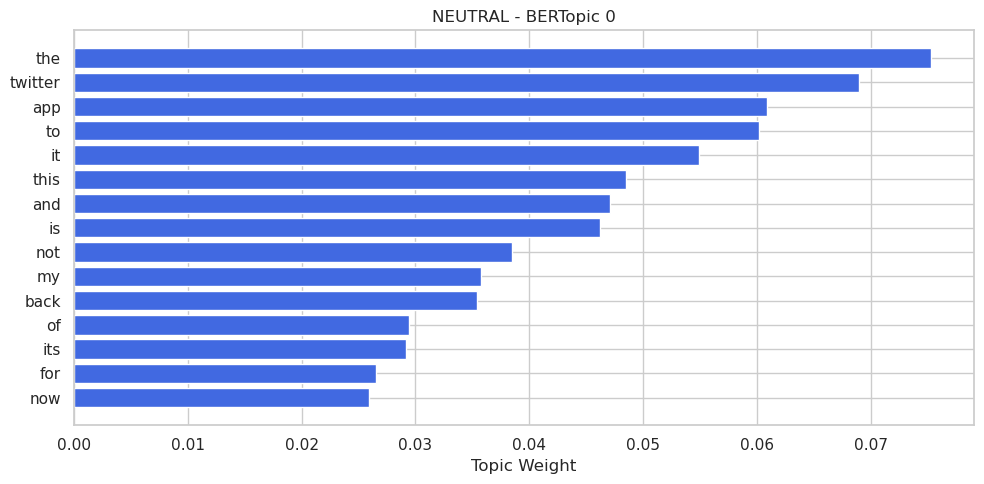

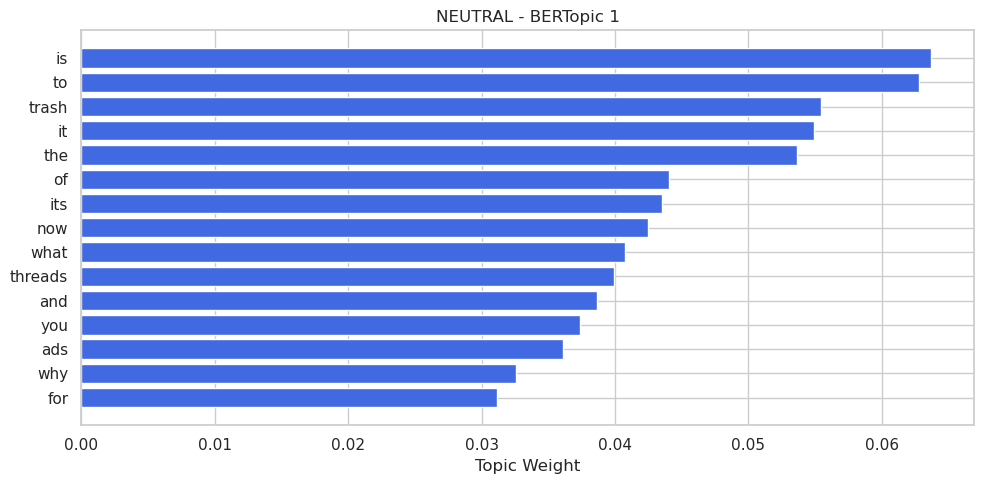

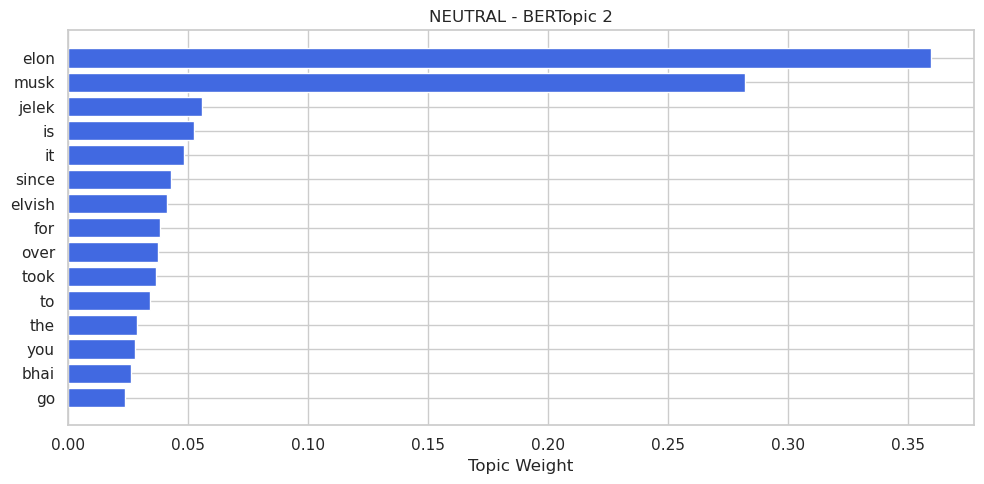

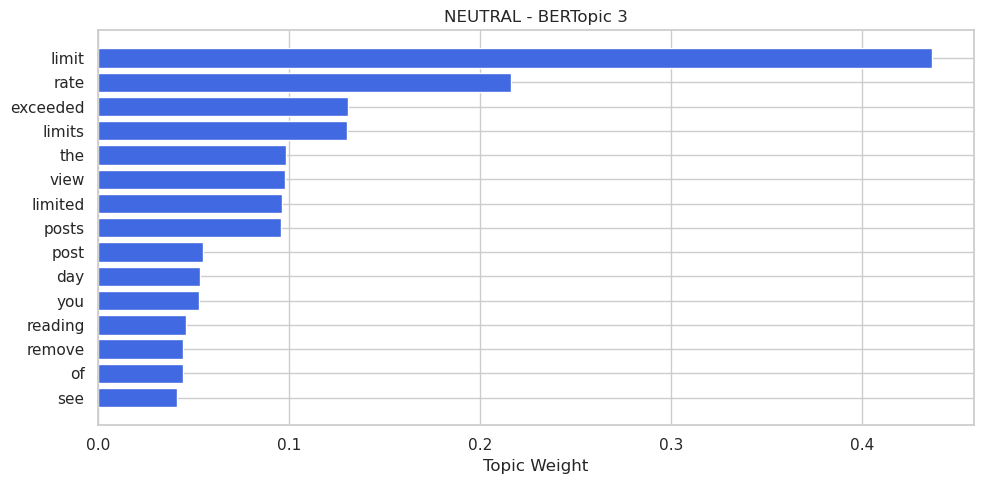


--- REPRESENTATIVE EXAMPLES (Neutral) ---

Topic 0 Examples:
- Change the name back to Twitter ...
- Change the name back to Twitter ...
- Bro wth heck happened to the app? Where is the bird? Where is twitter? What is x???? Why the amount of tweets we can see for a day is limited?? Why blue mark is now paywalled? İt has no reason now! İt ...

Topic 1 Examples:
- Dropping this back down to 1 star until the nonsense stops, go ahead and say "it's only $8 a month" I DON'T CARE!!! This used to be a fun place to roleplay with friend and talk to artists but instead  ...
- Awful. Used to be so much better, but now it's buggy, full of ads, and half the features are unusable ...
- It's not anymore what its used to be ...

Topic 2 Examples:
- Elon Musk🔥 ...
- Elon musk ...
- Elon musk 💩 ...

Topic 3 Examples:
- limit ...
- Limit ...
- LIMIT???!!! ...
Neutral BERTopic Coherence: 0.5569544147092252


Batches:   0%|          | 0/268 [00:00<?, ?it/s]


===== BERTOPIC SUMMARY (NEGATIVE) — 5 TOPICS =====
   Topic  Count                              Name  \
0     -1   2854                  -1_the_to_and_it   
1      0   4622                  0_the_and_app_to   
2      1    920            1_bad_worse_getting_it   
3      2    130           2_limit_rate_the_limits   
4      3     21  3_fire_dumpster_garbage_absolute   

                                      Representation  \
0  [the, to, and, it, is, app, of, this, twitter,...   
1  [the, and, app, to, is, it, this, twitter, elo...   
2  [bad, worse, getting, it, sucks, worst, terrib...   
3  [limit, rate, the, limits, is, view, limiting,...   
4  [fire, dumpster, garbage, absolute, dumpser, r...   

                                 Representative_Docs  
0  [Why do I have to pay for everything? Will you...  
1  [They just added a limit to how many posts use...  
2                        [bad, Bad, It's bad :(((((]  
3  [rate limit sucks., The rate limit sucks, THE ...  
4      [Dumpster 

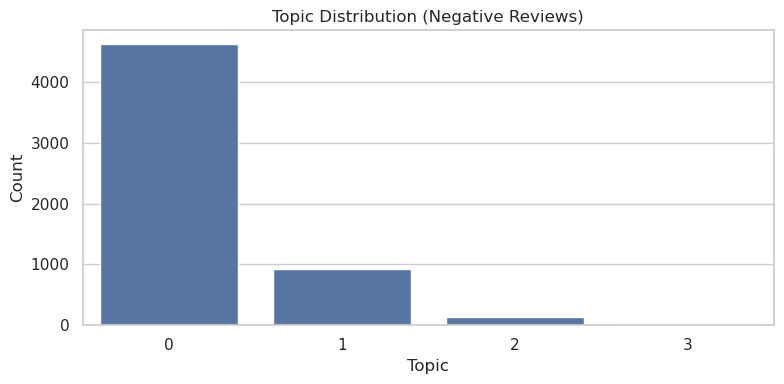

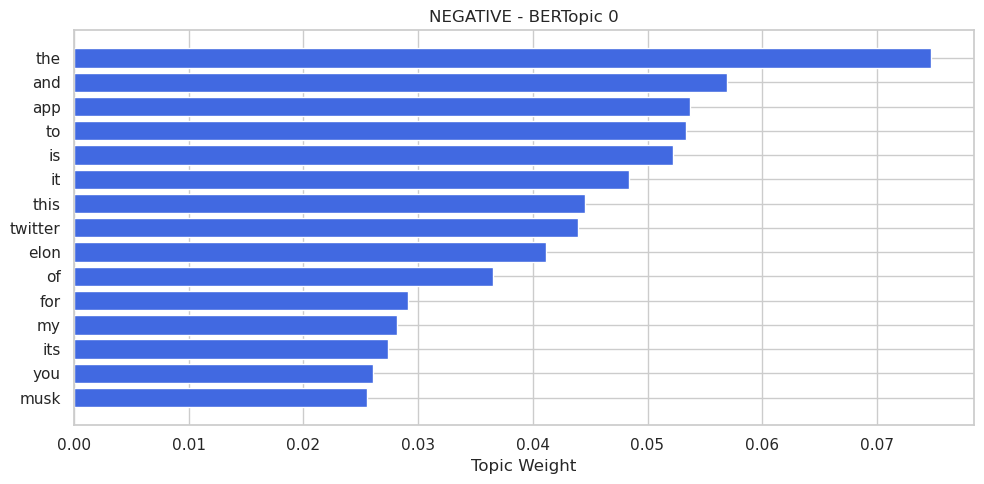

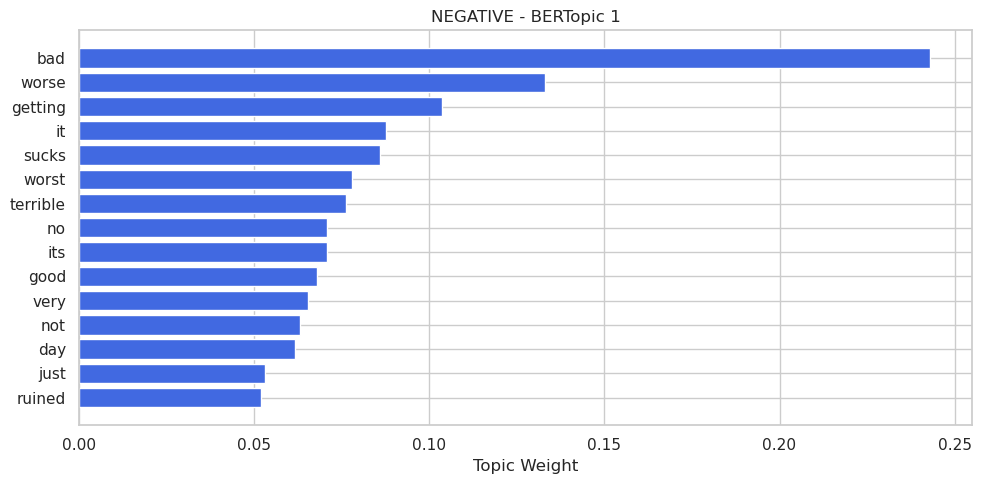

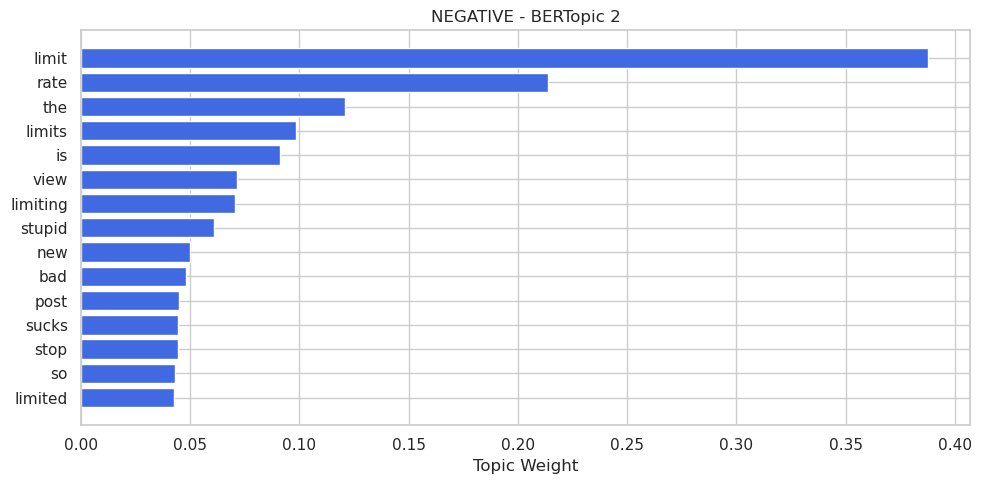

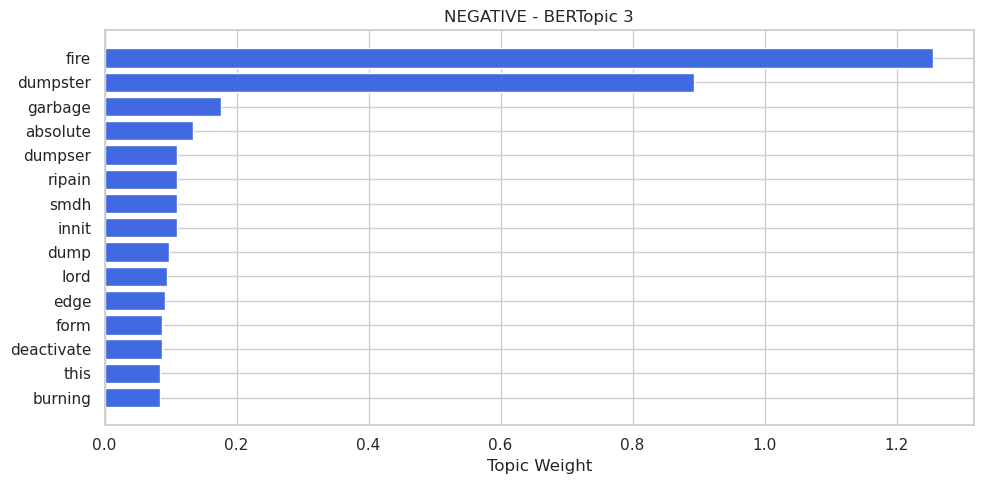


--- REPRESENTATIVE EXAMPLES (Negative) ---

Topic 0 Examples:
- They just added a limit to how many posts users can view a day. That should so obviously have been a bad decision, how its passed off as a good change is beyond me. The way this app has been handled i ...
- Ever since it was sold to some one it's been bad and worst of all the change in name and logo ...
- Don't update the app, Elon Musk ruined it. ...

Topic 1 Examples:
- bad ...
- Bad ...
- It's bad :((((( ...

Topic 2 Examples:
- rate limit sucks. ...
- The rate limit sucks ...
- THE RATE LIMIT SUCKS !!???!!! ...

Topic 3 Examples:
- Dumpster fire ...
- Dumpster fire ...
- Dumpster Fire ...
Negative BERTopic Coherence: 0.4390977222184451


In [207]:
twitter_pos_model, twitter_pos_topics, twitter_pos_probs, twitter_pos_emb, twitter_pos_coh = \
    run_bertopic_pipeline(twitter_pos, sentiment_value="positive", review_col= "review_text")

twitter_neu_model, twitter_neu_topics, twitter_neu_probs, twitter_neu_emb, twitter_neu_coh = \
    run_bertopic_pipeline(twitter_neu, sentiment_value="neutral", review_col = "review_text")

twitter_neg_model, twitter_neg_topics, twitter_neg_probs, twitter_neg_emb, twitter_neg_coh = \
    run_bertopic_pipeline(twitter_neg, sentiment_value="negative",review_col="review_text")


[Summary]
Across positive, neutral, and negative sentiment groups, BERTopic uncovers themes related to app usability, branding changes, user expectations, and reactions to platform leadership.

- Positive reviews highlight general satisfaction, ease of use, appreciation for free speech, and occasional account-related inquiries.
- Neutral reviews are centered on name/logo changes, mixed platform behavior, and recurring mentions of Elon Musk.
- Negative reviews emphasize poor updates, rate limits, worsening performance, and frustration with decisions impacting user experience.

(Topic -1 = “outlier” or “miscellaneous garbage cluster.”)

------

**Positive Sentiment Topics**

Best Model: 5 Topics — Coherence = 0.606

**1. General Positive App Feedback** — *app, good, best, to, this*

Users describe the app as functional, enjoyable, and one of their preferred social platforms.

**2. Straightforward Praise** — *good, nice, very, great, excellent*

Short, repetitive expressions of satisfaction.

**3. Free Speech / Elon Musk Appreciation** — *elon, speech, musk, freedom*

Positive comments linking the platform to free expression and its public figure association.

**4. Account Recovery & Help Requests** — *account, help, please, number*

Users ask for assistance recovering accounts or dealing with login issues.

**Insight:**
Positive sentiment is driven by general satisfaction, praise for platform values, and a subset of users seeking account-related support.

------

**Neutral Sentiment Topics**

Best Model: 5 Topics — Coherence = 0.557

**1. Rebranding & Name Changes** — *the, to, and, it, twitter*

Neutral reactions to the platform’s transition from Twitter to X.

**2. App Quality Over Time** — *trash, not, better, used*

Observations about how app quality has changed, shared without strong emotional tone.

**3. Elon Musk Mentions** — *elon, musk, jelek*

Comments referencing Musk in a descriptive or observational way.

**4. Rate Limit Discussions** — *limit, rate, exceeded, limits*

Matter-of-fact statements about limitations or system messages.

**Insight:**
Neutral reviews focus on factual descriptions of rebranding, platform changes, and rate limits, without strong approval or criticism.

------

**Negative Sentiment Topics**

Best Model: 5 Topics — Coherence = 0.439

**1. Platform Issues & Poor Decisions** — *the, app, to, ruined*

Users express frustration with updates, name changes, or perceived decline in quality.

**2. Bad Experiences / Declining Quality**— *bad, worse, getting, sucks*

Direct complaints about deteriorating performance.

**3. Rate Limit Complaints** — *limit, rate, limits, view*

Strong frustration with daily view limits and restrictive features.

**4. Strong Negative Labels** — *dumpster, garbage, fire*

Highly negative language describing the platform or recent changes.

**Insight:**
Negative sentiment is driven by worsening user experience, dissatisfaction with imposed limits, and strong reactions to platform management.

##### BERTopic performs quite well on twitter data with coherence scores of 0.53 for positive topics, 0.57 for neutral topics and 0.54 for negative topics with an average coherence of 0.55 which is good for the data. It seems to capture the clusters quite well in neutral as well which is best among all other modelling techniques we used till now.
##### It seems to also capture the issues with X such as update issues, logo, payment and rate limit which were major issues faced by users and comparing it to twitter before it changed to X, hence being the best model among all

[Overall Comparison Summary - BERTopic]

**Threads**
Users talk about app usability, bugs, and feature completeness.

- Positivity is simple (“good app”).
- Negativity is functional (crashes, missing features).

**Twitter**

Users focus heavily on platform direction, rebranding, policy changes, and Elon Musk.

- Positivity often ties to ideological values (free speech).

- Negativity is intense and expressive (rate limits, major changes).

### Test on the best topic modelling model - BERTopic

#### BERTopic managed to perform quite well on the test set as well with a coherence scores of 0.54 for positive topics, 0.52 for neutral topics, and finally 0.57 on negative topics proving that it is a better model among all the topic models.

#### More interpretation of topics: